# Notebook to perform all evaluations of models against human psychophysical data, and generate all psychophysical plots and statistics in paper
---

## Preliminaries

In [267]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, ttest_rel, ttest_ind, ttest_1samp
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.anova import AnovaRM


sns.set_context('poster')
sns.set_style('dark')

## Pilot experiment
Pilot experiment to decide on a latent dimensionality for the unsupervised PixelVAE models by testing the visual quality of samples generated from five networks of different dimensionalities.

In [2]:
expt_path = './analysis_data/psychophysics/expt0/'

In [3]:
# load psychophysics data
data_files = [f for f in os.listdir(expt_path) if f.endswith('.csv')]
len(data_files)

20

In [4]:
# look at participants' demographic information
demographics = pd.DataFrame(columns=['ID','age','gender','vision','colourvision', 'frameRate'])
usecols = ['participant ID (two digits', ' e.g. 01)', 'age', 'gender (m/f/-)', 'normal or corrected-to-normal vision (y/n)', 'expName'] # nb original columns are weirdly broken up due to a string formatting error in PsychoPy script
for s in range(len(data_files)):
    this_subj = pd.read_csv(os.path.join(expt_path, data_files[s]))
    subj_dems = []
    for c in usecols:
        subj_dems.append(this_subj.iloc[0][c])
    demographics.loc[s] = subj_dems
    
print('N = {}'.format(len(demographics)))
print('Mean age = {}'.format(demographics['age'].mean()))
print('\nGender identity:')
print(demographics['gender'].value_counts())
print('\nNormal or corrected-to-normal vision?')
print(demographics['vision'].value_counts())
print('\nFull colour vision?')
print(demographics['colourvision'].value_counts())

N = 20
Mean age = 23.45

Gender identity:
f    16
m     4
Name: gender, dtype: int64

Normal or corrected-to-normal vision?
y    19
n     1
Name: vision, dtype: int64

Full colour vision?
y    19
n     1
Name: colourvision, dtype: int64


### _Supplementary Figure 1b: pilot experiment testing of models with different latent dimensionality_

In [5]:
# extract placement order for each trial from participant responses:
order_per_subj = []
for s in range(len(data_files)):
    this_subj = pd.read_csv(os.path.join(expt_path, data_files[s]))
    subj_resps = []
    for row in range(this_subj.shape[0]):
        _resps = [int(i) for i in this_subj['placement_order'][row] if i=='1' or i=='2' or i=='3' or i=='4' or i=='5']
        subj_resps.append(_resps)
    subj_resps = np.array(subj_resps)
    mean_order = subj_resps.mean(axis=0)
    order_per_subj.append(mean_order)
order_per_subj = np.array(order_per_subj)

means = order_per_subj.mean(axis=0)
sems = order_per_subj.std(axis=0)/np.sqrt(len(data_files))

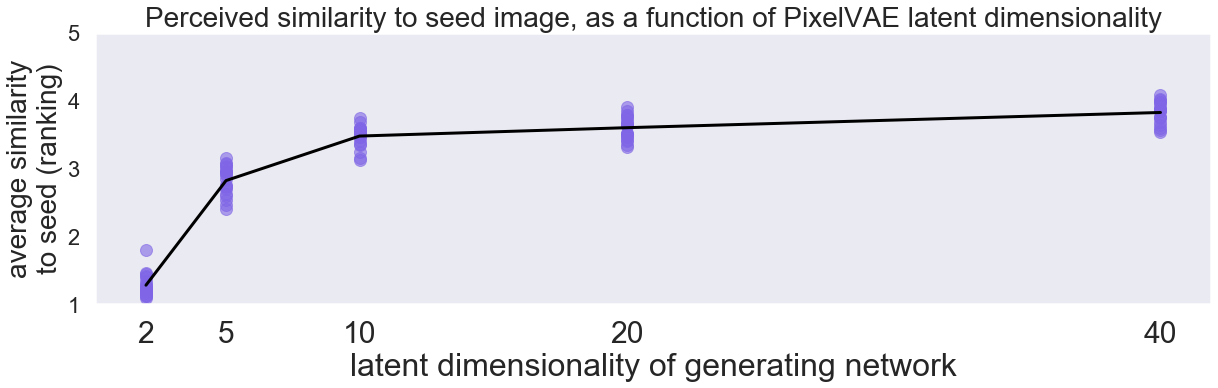

In [6]:
_col = [0.5, 0.4, 0.9]

plt.figure(figsize=(20,5))
plt.plot(2*np.ones([len(data_files),1]), order_per_subj[:,0], 'o', color=_col, alpha=0.6)
plt.plot(5*np.ones([len(data_files),1]), order_per_subj[:,1], 'o', color=_col, alpha=0.6)
plt.plot(10*np.ones([len(data_files),1]), order_per_subj[:,2], 'o', color=_col, alpha=0.6)
plt.plot(20*np.ones([len(data_files),1]), order_per_subj[:,3], 'o', color=_col, alpha=0.6)
plt.plot(40*np.ones([len(data_files),1]), order_per_subj[:,4], 'o', color=_col, alpha=0.6)
plt.plot([2,5,10,20,40],means,'k-')
plt.xticks([2,5,10,20,40], fontsize=30)
plt.ylim([1,5])
plt.title('Perceived similarity to seed image, as a function of PixelVAE latent dimensionality', fontsize=28)
plt.xlabel('latent dimensionality of generating network', fontsize=32)
plt.ylabel('average similarity\nto seed (ranking)', fontsize=28)
plt.show()

## Experiment 1 (gloss ratings for random novel images)
First psychophysical experiment reported in main paper, shown in Figure 4, in which participants rate gloss of new rendered images of random levels of specular reflectance.
- nb. This was conducted in same session as pilot experiment, so demographics are same as above.

In [230]:
expt_path = './analysis_data/psychophysics/expt1/'

In [231]:
data_files = [f for f in os.listdir(expt_path) if f.endswith('.csv')]
len(data_files)

20

In [232]:
# extract ratings for each participant for each stimulus
rating_per_subj = []
for s in range(len(data_files)):
    this_subj = pd.read_csv(os.path.join(expt_path, data_files[s]))
    sorted_ratings = np.array(this_subj.sort_values(by='stimOne')['rating'])
    mean_rating = [sorted_ratings[i:i+3].mean() for i in range(0,150,3)]
    rating_per_subj.append(mean_rating)
    
# keep raw ratings for scatterplotting
rating_per_subj_raw = np.array(rating_per_subj)
means_raw = rating_per_subj_raw.mean(axis=0)
sems_raw = rating_per_subj_raw.std(axis=0)/np.sqrt(len(data_files))

# calculate ratings normed to 0-1 range for RMSE calculations
rating_per_subj = (rating_per_subj_raw-1)/5.0
means = rating_per_subj.mean(axis=0)
sems = rating_per_subj.std(axis=0)/np.sqrt(len(data_files))

rating_per_subj.shape # ratings by 20 participants of 50 images

(20, 50)

In [233]:
# load all main model predictions:
model_path = './analysis_data/model_predicted_gloss/expt1_images/'

groundtruth = np.load(os.path.join(model_path,'ground_truth_gloss_expt1.npy'))

# unsupervised PixelVAE models, and average over the 10 training instances:
pixelVAE = np.load(os.path.join(model_path,'gloss_vals_all_pixelVAEs_expt1.npy'))
pixelVAE_avg = pixelVAE.mean(axis=0)
pixelVAE_sem = pixelVAE.std(axis=0)/np.sqrt(pixelVAE_avg.shape[0])

# supervised ResNet models, and average over the 10 training instances:
resnet = np.load(os.path.join(model_path,'gloss_vals_all_Resnets_expt1.npy'))
resnet_avg = resnet.mean(axis=0)
resnet_sem = resnet.std(axis=0)/np.sqrt(resnet_avg.shape[0])

# alternative comparison models
MDS = np.load(os.path.join(model_path,'gloss_vals_pixel-10D-embedding_MDS_expt1.npy'))
tSNE = np.load(os.path.join(model_path,'gloss_vals_pixel-10D-embedding_tSNE_expt1.npy'))
LLE = np.load(os.path.join(model_path,'gloss_vals_pixel-10D-embedding_LLE_expt1.npy'))
texture = np.load(os.path.join(model_path,'gloss_vals_ps_texturefeats_expt1.npy'))
skew = np.load(os.path.join(model_path,'gloss_vals_skewness_expt1.npy'))
imagenet = np.load(os.path.join(model_path,'gloss_vals_imagenetDNN_expt1.npy'))
simpleAE = np.load(os.path.join(model_path,'gloss_vals_simpleAE_expt1.npy'))

# also load PixelVAE variants, which will be evaluated later (Figure 7):
contPVAE = np.load(os.path.join(model_path,'gloss_vals_continuous_gloss_trained_pixelVAEs_expt1.npy'))
contPVAE_avg = contPVAE.mean(axis=0)
contPVAE_sem = contPVAE.std(axis=0)/np.sqrt(contPVAE_avg.shape[0])

highvarPVAE = np.load(os.path.join(model_path,'gloss_vals_higher_variance_trained_pixelVAE_expt1.npy'))

regPVAE00 = np.load(os.path.join(model_path,'gloss_vals_contPixelVAE00_expt1.npy'))
regPVAE00 = regPVAE00[0]
regPVAE01 = np.load(os.path.join(model_path,'gloss_vals_contPixelVAE01_expt1.npy'))
regPVAE01 = regPVAE01[0]

# also load hyperparameter-search PixelVAE and Resnet variants,
# which will be evaluated later (Supplementary Figure 5)

# unsupervised pixelVAEs
modelID = 'filters-80_resnets-2_logmixes-12_lr-0.001_decay-1.0'
pvae_f80l2 = np.load(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'filters-48_resnets-4_logmixes-12_lr-0.001_decay-1.0'
pvae_f48l4 = np.load(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_{}_expt1.npy').format(modelID))

modelID = 'filters-64_resnets-3_logmixes-4_lr-0.001_decay-1.0'
pvae_log4 = np.load(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'filters-64_resnets-3_logmixes-6_lr-0.001_decay-1.0'
pvae_log6 = np.load(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'filters-64_resnets-3_logmixes-24_lr-0.001_decay-1.0'
pvae_log24 = np.load(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'filters-64_resnets-3_logmixes-30_lr-0.001_decay-1.0'
pvae_log30 = np.load(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_{}_expt1.npy').format(modelID))

modelID = 'filters-64_resnets-3_logmixes-12_lr-0.01_decay-1.0'
pvae_lr01 = np.load(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'filters-64_resnets-3_logmixes-12_lr-0.005_decay-1.0'
pvae_lr005 = np.load(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'filters-64_resnets-3_logmixes-12_lr-0.0005_decay-1.0'
pvae_lr0005 = np.load(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'filters-64_resnets-3_logmixes-12_lr-0.0001_decay-1.0'
pvae_lr0001 = np.load(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_{}_expt1.npy').format(modelID))

modelID = 'filters-64_resnets-3_logmixes-12_lr-0.001_decay-0.25'
pvae_d0_25 = np.load(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'filters-64_resnets-3_logmixes-12_lr-0.001_decay-0.5'
pvae_d0_50 = np.load(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'filters-64_resnets-3_logmixes-12_lr-0.001_decay-2.0'
pvae_d2_00 = np.load(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'filters-64_resnets-3_logmixes-12_lr-0.001_decay-4.0'
pvae_d4_00 = np.load(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_{}_expt1.npy').format(modelID))

# supervised Resnets
modelID = 'logs_filters-80_resnets-2_batchsize-32_lr-0.01_decay-0.1'
res_f80l2 = np.load(os.path.join(model_path,'hyperparam_resnets/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'logs_filters-48_resnets-4_batchsize-32_lr-0.01_decay-0.1'
res_f48l4 = np.load(os.path.join(model_path,'hyperparam_resnets/gloss_vals_{}_expt1.npy').format(modelID))

modelID = 'logs_filters-56_resnets-3_batchsize-12_lr-0.001_decay-1.0'
res_b12 = np.load(os.path.join(model_path,'hyperparam_resnets/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'logs_filters-56_resnets-3_batchsize-22_lr-0.001_decay-1.0'
res_b22 = np.load(os.path.join(model_path,'hyperparam_resnets/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'logs_filters-56_resnets-3_batchsize-42_lr-0.001_decay-1.0'
res_b42 = np.load(os.path.join(model_path,'hyperparam_resnets/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'logs_filters-56_resnets-3_batchsize-50_lr-0.001_decay-1.0'
res_b50 = np.load(os.path.join(model_path,'hyperparam_resnets/gloss_vals_{}_expt1.npy').format(modelID))

modelID = 'logs_filters-56_resnets-3_batchsize-32_lr-0.01_decay-1.0'
res_lr01 = np.load(os.path.join(model_path,'hyperparam_resnets/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'logs_filters-56_resnets-3_batchsize-32_lr-0.005_decay-1.0'
res_lr005 = np.load(os.path.join(model_path,'hyperparam_resnets/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'logs_filters-56_resnets-3_batchsize-32_lr-0.0005_decay-1.0'
res_lr0005 = np.load(os.path.join(model_path,'hyperparam_resnets/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'logs_filters-56_resnets-3_batchsize-32_lr-0.0001_decay-1.0'
res_lr0001 = np.load(os.path.join(model_path,'hyperparam_resnets/gloss_vals_{}_expt1.npy').format(modelID))

modelID = 'logs_filters-56_resnets-3_batchsize-32_lr-0.001_decay-0.25'
res_d0_25 = np.load(os.path.join(model_path,'hyperparam_resnets/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'logs_filters-56_resnets-3_batchsize-32_lr-0.001_decay-0.50'
res_d0_50 = np.load(os.path.join(model_path,'hyperparam_resnets/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'logs_filters-56_resnets-3_batchsize-32_lr-0.001_decay-2.00'
res_d2_00 = np.load(os.path.join(model_path,'hyperparam_resnets/gloss_vals_{}_expt1.npy').format(modelID))
modelID = 'logs_filters-56_resnets-3_batchsize-32_lr-0.001_decay-4.00'
res_d4_00 = np.load(os.path.join(model_path,'hyperparam_resnets/gloss_vals_{}_expt1.npy').format(modelID))

# conv layers of a PixelVAE (needed for Supplementary Figure 4):
pvae_conv1 = np.load(os.path.join(model_path,'gloss_vals_pixelVAE01_conv1_expt1.npy'))
pvae_conv2 = np.load(os.path.join(model_path,'gloss_vals_pixelVAE01_conv2_expt1.npy'))
pvae_conv3 = np.load(os.path.join(model_path,'gloss_vals_pixelVAE01_conv3_expt1.npy'))

# conv layers of a Resnet (needed for Supplementary Figure 4)
res_conv1 = np.load(os.path.join(model_path,'gloss_vals_resnet09_conv1_expt1.npy'))
res_conv2 = np.load(os.path.join(model_path,'gloss_vals_resnet09_conv2_expt1.npy'))
res_conv3 = np.load(os.path.join(model_path,'gloss_vals_resnet09_conv3_expt1.npy'))

# continuous regression supervised Resnets (needed for Supplementary Figure 4)
res_cont00 = np.load(os.path.join(model_path,'gloss_vals_contResnet00_expt1.npy'))
res_cont01 = np.load(os.path.join(model_path,'gloss_vals_contResnet01_expt1.npy'))
res_cont02 = np.load(os.path.join(model_path,'gloss_vals_contResnet02_expt1.npy'))
res_cont03 = np.load(os.path.join(model_path,'gloss_vals_contResnet03_expt1.npy'))
res_cont04 = np.load(os.path.join(model_path,'gloss_vals_contResnet04_expt1.npy'))

### _Figure 4a (left panel): Experiment 1 data vs PixelVAE model predictions scatterplot_

In [122]:
def norm_to_rating_range(v):
    '''
    Normalise model prediction 
    data into range 0-1 (human
    1-6 ratings have been divided 
    by 6 for comparability).
    '''
    tmp = v - v.min()
    v_norm = tmp/tmp.max()
    return v_norm

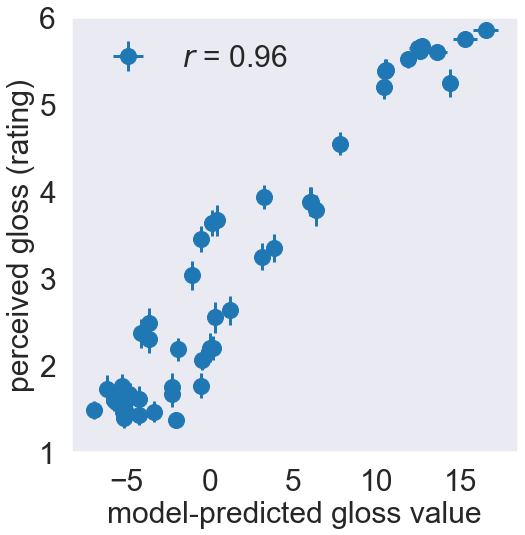

In [280]:
plt.figure(figsize=(8,8))
plt.errorbar(pixelVAE_avg, means_raw, yerr=sems_raw, xerr=pixelVAE_sem, fmt='o', label='$r$ = {}'.format(round(pearsonr(pixelVAE_avg, means)[0],2)), markersize=16, linewidth=3)
plt.xlabel('model-predicted gloss value', fontsize=30)
plt.ylabel('perceived gloss (rating)', fontsize=30)
# plt.title('Perceived vs unsupervised-model-predicted \n gloss for example rendered stimuli', fontsize=24)
plt.legend(fontsize=30, frameon=False)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim([1,6])
plt.show()

In [283]:
# Calculate and compare each training instance's explained variance against mean human data
print('PixelVAE instance average R-squared = {}'.format(np.mean([r2_score(means, norm_to_rating_range(pixelVAE[i,:])) for i in range(10)])))
print('Resnet instance average R-squared = {}\n'.format(np.mean([r2_score(means, norm_to_rating_range(resnet[i,:])) for i in range(10)])))

ttest_ind([r2_score(means, norm_to_rating_range(pixelVAE[i,:])) for i in range(10)], [r2_score(means, norm_to_rating_range(resnet[i,:])) for i in range(10)])

PixelVAE instance average R-squared = 0.8352007666723276
Resnet instance average R-squared = 0.399209425858538



Ttest_indResult(statistic=12.453644814246848, pvalue=2.77051950052797e-10)

In [284]:
# Test superiority to ground truth over training instances
print('Ground-truth R-squared = {}'.format(r2_score(means, norm_to_rating_range(groundtruth))))
ttest_1samp([r2_score(means, norm_to_rating_range(pixelVAE[i,:])) - r2_score(means, norm_to_rating_range(groundtruth)) for i in range(10)], 0)

Ground-truth R-squared = 0.7345122077043214


Ttest_1sampResult(statistic=4.740262624056085, pvalue=0.0010585425340732839)

### _Figure 4a (right panel): Experiment 1 data vs all model predictions summary barplot_

In [285]:
# calculate Root Mean Squared Error for all models

# noise ceilings (measure inter-subject reliability)
lower_ceiling_rmse_expt1 = []
upper_ceiling_rmse_expt1 = []

# core models
groundtruth_rmse_expt1 = []
pixelVAE_rmse_expt1 = []
resnet_rmse_expt1 = []
MDS_rmse_expt1 = []
tSNE_rmse_expt1 = []
LLE_rmse_expt1 = []
texture_rmse_expt1 = []
skew_rmse_expt1 = []
imagenet_rmse_expt1 = []
simpleAE_rmse_expt1 = []

# testing each pixelVAE individually
pixelVAE00_rmse_expt1 = []
pixelVAE01_rmse_expt1 = []
pixelVAE02_rmse_expt1 = []
pixelVAE03_rmse_expt1 = []
pixelVAE04_rmse_expt1 = []
pixelVAE05_rmse_expt1 = []
pixelVAE06_rmse_expt1 = []
pixelVAE07_rmse_expt1 = []
pixelVAE08_rmse_expt1 = []
pixelVAE09_rmse_expt1 = []

# testing each resnet individually
resnet00_rmse_expt1 = []
resnet01_rmse_expt1 = []
resnet02_rmse_expt1 = []
resnet03_rmse_expt1 = []
resnet04_rmse_expt1 = []
resnet05_rmse_expt1 = []
resnet06_rmse_expt1 = []
resnet07_rmse_expt1 = []
resnet08_rmse_expt1 = []
resnet09_rmse_expt1 = []

# PixelVAE variants for Figure 7
contPVAE00_rmse_expt1 = []
contPVAE01_rmse_expt1 = []
contPVAE02_rmse_expt1 = []
contPVAE03_rmse_expt1 = []
contPVAE04_rmse_expt1 = []

highvarPVAE_rmse_expt1 = []

regPVAE00_rmse_expt1 = []
regPVAE01_rmse_expt1 = []

# hyperparameter variant PixelVAEs for Supplementary Figure 5
pvae_f80l2_rmse_expt1 = []
pvae_f48l4_rmse_expt1 = []
pvae_log4_rmse_expt1 = []
pvae_log6_rmse_expt1 = []
pvae_log24_rmse_expt1 = []
pvae_log30_rmse_expt1 = []
pvae_lr01_rmse_expt1 = []
pvae_lr005_rmse_expt1 = []
pvae_lr0005_rmse_expt1 = []
pvae_lr0001_rmse_expt1 = []
pvae_d0_25_rmse_expt1 = []
pvae_d0_50_rmse_expt1 = []
pvae_d2_00_rmse_expt1 = []
pvae_d4_00_rmse_expt1 = []

# hyperparameter variant Resnets for Supplementary Figure 5
res_f80l2_rmse_expt1 = []
res_f48l4_rmse_expt1 = []
res_b12_rmse_expt1 = []
res_b22_rmse_expt1 = []
res_b42_rmse_expt1 = []
res_b50_rmse_expt1 = []
res_lr01_rmse_expt1 = []
res_lr005_rmse_expt1 = []
res_lr0005_rmse_expt1 = []
res_lr0001_rmse_expt1 = []
res_d0_25_rmse_expt1 = []
res_d0_50_rmse_expt1 = []
res_d2_00_rmse_expt1 = []
res_d4_00_rmse_expt1 = []

# conv layers for Supplementary Figure 4
pvae_c1_rmse_expt1 = []
pvae_c2_rmse_expt1 = []
pvae_c3_rmse_expt1 = []

res_c1_rmse_expt1 = []
res_c2_rmse_expt1 = []
res_c3_rmse_expt1 = []

# continuous regression Resnets for Supplementary Figure 4
res_cont00_rmse_expt1 = []
res_cont01_rmse_expt1 = []
res_cont02_rmse_expt1 = []
res_cont03_rmse_expt1 = []
res_cont04_rmse_expt1 = []

# cycle through, calculating error of each model against each individual participant's data
for p in range(rating_per_subj.shape[0]):
    tmp_data = np.delete(rating_per_subj, p, axis=0)
    tmp_means = tmp_data.mean(axis=0)
    
    upper_ceiling_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], means)))
    lower_ceiling_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], tmp_means)))
    
    groundtruth_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(groundtruth))))
    pixelVAE_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pixelVAE_avg))))
    resnet_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(resnet_avg))))
    MDS_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(MDS))))
    tSNE_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(tSNE))))
    LLE_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(LLE))))
    texture_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(texture))))
    skew_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(skew))))
    imagenet_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(imagenet))))
    simpleAE_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(simpleAE))))
    
    # testing each pixelVAE individually
    pixelVAE00_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[0,:]))))
    pixelVAE01_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[1,:]))))
    pixelVAE02_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[2,:]))))
    pixelVAE03_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[3,:]))))
    pixelVAE04_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[4,:]))))
    pixelVAE05_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[5,:]))))
    pixelVAE06_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[6,:]))))
    pixelVAE07_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[7,:]))))
    pixelVAE08_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[8,:]))))
    pixelVAE09_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[9,:]))))
    
    # testing each resnet individually
    resnet00_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(resnet[0,:]))))
    resnet01_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(resnet[1,:]))))
    resnet02_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(resnet[2,:]))))
    resnet03_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(resnet[3,:]))))
    resnet04_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(resnet[4,:]))))
    resnet05_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(resnet[5,:]))))
    resnet06_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(resnet[6,:]))))
    resnet07_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(resnet[7,:]))))
    resnet08_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(resnet[8,:]))))
    resnet09_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(resnet[9,:]))))
 
    contPVAE00_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(contPVAE[0,:]))))
    contPVAE01_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(contPVAE[1,:]))))
    contPVAE02_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(contPVAE[2,:]))))
    contPVAE03_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(contPVAE[3,:]))))
    contPVAE04_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(contPVAE[4,:]))))
    
    highvarPVAE_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(highvarPVAE))))
    
    regPVAE00_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(regPVAE00))))
    regPVAE01_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(regPVAE01))))

    pvae_f80l2_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pvae_f80l2))))
    pvae_f48l4_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pvae_f48l4))))
    pvae_log4_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pvae_log4))))
    pvae_log6_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pvae_log6))))
    pvae_log24_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pvae_log24))))
    pvae_log30_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pvae_log30))))
    pvae_lr01_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pvae_lr01))))
    pvae_lr005_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pvae_lr005))))
    pvae_lr0005_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pvae_lr0005))))
    pvae_lr0001_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pvae_lr0001))))
    pvae_d0_25_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pvae_d0_25))))
    pvae_d0_50_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pvae_d0_50))))
    pvae_d2_00_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pvae_d2_00))))
    pvae_d4_00_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pvae_d4_00))))

    res_f80l2_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_f80l2))))
    res_f48l4_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_f48l4))))
    res_b12_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_b12))))
    res_b22_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_b22))))
    res_b42_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_b42))))
    res_b50_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_b50))))
    res_lr01_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_lr01))))
    res_lr005_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_lr005))))
    res_lr0005_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_lr0005))))
    res_lr0001_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_lr0001))))
    res_d0_25_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_d0_25))))
    res_d0_50_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_d0_50))))
    res_d2_00_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_d2_00))))
    res_d4_00_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_d4_00))))
    
    pvae_c1_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pvae_conv1))))
    pvae_c2_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pvae_conv2))))
    pvae_c3_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(pvae_conv3))))
    
    res_c1_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_conv1))))
    res_c2_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_conv2))))
    res_c3_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_conv3))))
    
    res_cont00_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_cont00))))
    res_cont01_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_cont01))))
    res_cont02_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_cont02))))
    res_cont03_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_cont03))))
    res_cont04_rmse_expt1.append(np.sqrt(mean_squared_error(rating_per_subj[p,:], norm_to_rating_range(res_cont04))))


In [286]:
# calculate Pearson Correlation for all models

# noise ceilings (measure inter-subject reliability)
lower_ceiling_corr_expt1 = []
upper_ceiling_corr_expt1 = []

# core models
groundtruth_corr_expt1 = []
pixelVAE_corr_expt1 = []
resnet_corr_expt1 = []
MDS_corr_expt1 = []
tSNE_corr_expt1 = []
LLE_corr_expt1 = []
texture_corr_expt1 = []
skew_corr_expt1 = []
imagenet_corr_expt1 = []
simpleAE_corr_expt1 = []

# testing each pixelVAE individually
pixelVAE00_corr_expt1 = []
pixelVAE01_corr_expt1 = []
pixelVAE02_corr_expt1 = []
pixelVAE03_corr_expt1 = []
pixelVAE04_corr_expt1 = []
pixelVAE05_corr_expt1 = []
pixelVAE06_corr_expt1 = []
pixelVAE07_corr_expt1 = []
pixelVAE08_corr_expt1 = []
pixelVAE09_corr_expt1 = []

# testing each resnet individually
resnet00_corr_expt1 = []
resnet01_corr_expt1 = []
resnet02_corr_expt1 = []
resnet03_corr_expt1 = []
resnet04_corr_expt1 = []
resnet05_corr_expt1 = []
resnet06_corr_expt1 = []
resnet07_corr_expt1 = []
resnet08_corr_expt1 = []
resnet09_corr_expt1 = []

# PixelVAE variants for Figure 7
contPVAE00_corr_expt1 = []
contPVAE01_corr_expt1 = []
contPVAE02_corr_expt1 = []
contPVAE03_corr_expt1 = []
contPVAE04_corr_expt1 = []

highvarPVAE_corr_expt1 = []

regPVAE00_corr_expt1 = []
regPVAE01_corr_expt1 = []

# hyperparameter variant PixelVAEs for Supplementary Figure 5
pvae_f80l2_corr_expt1 = []
pvae_f48l4_corr_expt1 = []
pvae_log4_corr_expt1 = []
pvae_log6_corr_expt1 = []
pvae_log24_corr_expt1 = []
pvae_log30_corr_expt1 = []
pvae_lr01_corr_expt1 = []
pvae_lr005_corr_expt1 = []
pvae_lr0005_corr_expt1 = []
pvae_lr0001_corr_expt1 = []
pvae_d0_25_corr_expt1 = []
pvae_d0_50_corr_expt1 = []
pvae_d2_00_corr_expt1 = []
pvae_d4_00_corr_expt1 = []

# hyperparameter variant Resnets for Supplementary Figure 5
res_f80l2_corr_expt1 = []
res_f48l4_corr_expt1 = []
res_b12_corr_expt1 = []
res_b22_corr_expt1 = []
res_b42_corr_expt1 = []
res_b50_corr_expt1 = []
res_lr01_corr_expt1 = []
res_lr005_corr_expt1 = []
res_lr0005_corr_expt1 = []
res_lr0001_corr_expt1 = []
res_d0_25_corr_expt1 = []
res_d0_50_corr_expt1 = []
res_d2_00_corr_expt1 = []
res_d4_00_corr_expt1 = []

# conv layers for Supplementary Figure 4
pvae_c1_corr_expt1 = []
pvae_c2_corr_expt1 = []
pvae_c3_corr_expt1 = []

res_c1_corr_expt1 = []
res_c2_corr_expt1 = []
res_c3_corr_expt1 = []

# continuous regression Resnets for Supplementary Figure 4
res_cont00_corr_expt1 = []
res_cont01_corr_expt1 = []
res_cont02_corr_expt1 = []
res_cont03_corr_expt1 = []
res_cont04_corr_expt1 = []


# cycle through, calculating error of each model against each individual participant's data
for p in range(rating_per_subj.shape[0]):
    tmp_data = np.delete(rating_per_subj, p, axis=0)
    tmp_means = tmp_data.mean(axis=0)
    
    
    upper_ceiling_corr_expt1.append(pearsonr(rating_per_subj[p,:], means)[0])
    lower_ceiling_corr_expt1.append(pearsonr(rating_per_subj[p,:], tmp_means)[0])
    
    groundtruth_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(groundtruth))[0])
    pixelVAE_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pixelVAE_avg))[0])
    resnet_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(resnet_avg))[0])
    MDS_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(MDS))[0])
    tSNE_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(tSNE))[0])
    LLE_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(LLE))[0])
    texture_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(texture))[0])
    skew_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(skew))[0])
    imagenet_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(imagenet))[0])
    simpleAE_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(simpleAE))[0])
    
    # testing each pixelVAE individually
    pixelVAE00_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[0,:]))[0])
    pixelVAE01_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[1,:]))[0])
    pixelVAE02_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[2,:]))[0])
    pixelVAE03_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[3,:]))[0])
    pixelVAE04_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[4,:]))[0])
    pixelVAE05_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[5,:]))[0])
    pixelVAE06_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[6,:]))[0])
    pixelVAE07_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[7,:]))[0])
    pixelVAE08_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[8,:]))[0])
    pixelVAE09_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pixelVAE[9,:]))[0])
    
    # testing each resnet individually
    resnet00_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(resnet[0,:]))[0])
    resnet01_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(resnet[1,:]))[0])
    resnet02_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(resnet[2,:]))[0])
    resnet03_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(resnet[3,:]))[0])
    resnet04_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(resnet[4,:]))[0])
    resnet05_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(resnet[5,:]))[0])
    resnet06_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(resnet[6,:]))[0])
    resnet07_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(resnet[7,:]))[0])
    resnet08_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(resnet[8,:]))[0])
    resnet09_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(resnet[9,:]))[0])
 
    contPVAE00_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(contPVAE[0,:]))[0])
    contPVAE01_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(contPVAE[1,:]))[0])
    contPVAE02_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(contPVAE[2,:]))[0])
    contPVAE03_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(contPVAE[3,:]))[0])
    contPVAE04_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(contPVAE[4,:]))[0])
    
    highvarPVAE_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(highvarPVAE))[0])
    
    regPVAE00_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(regPVAE00))[0])
    regPVAE01_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(regPVAE01))[0])

    pvae_f80l2_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pvae_f80l2))[0])
    pvae_f48l4_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pvae_f48l4))[0])
    pvae_log4_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pvae_log4))[0])
    pvae_log6_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pvae_log6))[0])
    pvae_log24_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pvae_log24))[0])
    pvae_log30_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pvae_log30))[0])
    pvae_lr01_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pvae_lr01))[0])
    pvae_lr005_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pvae_lr005))[0])
    pvae_lr0005_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pvae_lr0005))[0])
    pvae_lr0001_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pvae_lr0001))[0])
    pvae_d0_25_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pvae_d0_25))[0])
    pvae_d0_50_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pvae_d0_50))[0])
    pvae_d2_00_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pvae_d2_00))[0])
    pvae_d4_00_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pvae_d4_00))[0])

    res_f80l2_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_f80l2))[0])
    res_f48l4_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_f48l4))[0])
    res_b12_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_b12))[0])
    res_b22_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_b22))[0])
    res_b42_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_b42))[0])
    res_b50_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_b50))[0])
    res_lr01_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_lr01))[0])
    res_lr005_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_lr005))[0])
    res_lr0005_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_lr0005))[0])
    res_lr0001_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_lr0001))[0])
    res_d0_25_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_d0_25))[0])
    res_d0_50_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_d0_50))[0])
    res_d2_00_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_d2_00))[0])
    res_d4_00_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_d4_00))[0])
    
    pvae_c1_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pvae_conv1))[0])
    pvae_c2_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pvae_conv2))[0])
    pvae_c3_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(pvae_conv3))[0])
    
    res_c1_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_conv1))[0])
    res_c2_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_conv2))[0])
    res_c3_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_conv3))[0])
    
    res_cont00_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_cont00))[0])
    res_cont01_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_cont01))[0])
    res_cont02_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_cont02))[0])
    res_cont03_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_cont03))[0])
    res_cont04_corr_expt1.append(pearsonr(rating_per_subj[p,:], norm_to_rating_range(res_cont04))[0])


In [287]:
# also calculate R2 scores for model(s) against average human data, disregarding inter-subject reliability
pixelVAE_instances_r2agg_expt1 = [r2_score(means, norm_to_rating_range(pixelVAE[i,:])) for i in range(10)]
resnet_instances_r2agg_expt1 = [r2_score(means, norm_to_rating_range(resnet[i,:])) for i in range(10)]

groundtruth_r2agg_expt1 = r2_score(means, norm_to_rating_range(groundtruth))
MDS_r2agg_expt1 = r2_score(means, norm_to_rating_range(MDS))
tSNE_r2agg_expt1 = r2_score(means, norm_to_rating_range(tSNE))
LLE_r2agg_expt1 = r2_score(means, norm_to_rating_range(LLE))
texture_r2agg_expt1 = r2_score(means, norm_to_rating_range(texture))
skew_r2agg_expt1 = r2_score(means, norm_to_rating_range(skew))
imagenet_r2agg_expt1 = r2_score(means, norm_to_rating_range(imagenet))
simpleAE_r2agg_expt1 = r2_score(means, norm_to_rating_range(simpleAE))

In [288]:
# specify model colours to use throughout plotting
pal = sns.color_palette("Set2",7)

human_col = [0.2, 0.2, 0.2] 
groundtruth_col = [0.9, 0.9, 0.9]
pixelVAE_col = [0.6, 0.2, 0.6]
resnet_col = [0.2, 0.5, 0.6]
MDS_col = pal[2] 
tSNE_col = pal[0]
LLE_col = pal[4] 
texture_col = pal[5]
skew_col = pal[6]
imagenet_col = pal[1]
simpleAE_col = pal[3]

In [289]:
resnet_instances_rmse_expt1 = np.mean([resnet00_rmse_expt1,
                                       resnet01_rmse_expt1,
                                       resnet02_rmse_expt1,
                                       resnet03_rmse_expt1,
                                       resnet04_rmse_expt1,
                                       resnet05_rmse_expt1,
                                       resnet06_rmse_expt1,
                                       resnet07_rmse_expt1,
                                       resnet08_rmse_expt1,
                                       resnet09_rmse_expt1], axis=0)

pixelVAE_instances_rmse_expt1 = np.mean([pixelVAE00_rmse_expt1,
                                         pixelVAE01_rmse_expt1,
                                         pixelVAE02_rmse_expt1,
                                         pixelVAE03_rmse_expt1,
                                         pixelVAE04_rmse_expt1,
                                         pixelVAE05_rmse_expt1,
                                         pixelVAE06_rmse_expt1,
                                         pixelVAE07_rmse_expt1,
                                         pixelVAE08_rmse_expt1,
                                         pixelVAE09_rmse_expt1], axis=0)

contPVAE_instances_rmse_expt1 = np.mean([contPVAE00_rmse_expt1,
                                         contPVAE01_rmse_expt1,
                                         contPVAE02_rmse_expt1,
                                         contPVAE03_rmse_expt1,
                                         contPVAE04_rmse_expt1], axis=0)

# also variances
resnet_instances_rmse_sem_expt1 = np.mean([np.std(resnet00_rmse_expt1)/np.sqrt(20),
                                       np.std(resnet01_rmse_expt1)/np.sqrt(20),
                                       np.std(resnet02_rmse_expt1)/np.sqrt(20),
                                       np.std(resnet03_rmse_expt1)/np.sqrt(20),
                                       np.std(resnet04_rmse_expt1)/np.sqrt(20),
                                       np.std(resnet05_rmse_expt1)/np.sqrt(20),
                                       np.std(resnet06_rmse_expt1)/np.sqrt(20),
                                       np.std(resnet07_rmse_expt1)/np.sqrt(20),
                                       np.std(resnet08_rmse_expt1)/np.sqrt(20),
                                       np.std(resnet09_rmse_expt1)/np.sqrt(20)], axis=0)

pixelVAE_instances_rmse_sem_expt1 = np.mean([np.std(pixelVAE00_rmse_expt1)/np.sqrt(20),
                                         np.std(pixelVAE01_rmse_expt1)/np.sqrt(20),
                                         np.std(pixelVAE02_rmse_expt1)/np.sqrt(20),
                                         np.std(pixelVAE03_rmse_expt1)/np.sqrt(20),
                                         np.std(pixelVAE04_rmse_expt1)/np.sqrt(20),
                                         np.std(pixelVAE05_rmse_expt1)/np.sqrt(20),
                                         np.std(pixelVAE06_rmse_expt1)/np.sqrt(20),
                                         np.std(pixelVAE07_rmse_expt1)/np.sqrt(20),
                                         np.std(pixelVAE08_rmse_expt1)/np.sqrt(20),
                                         np.std(pixelVAE09_rmse_expt1)/np.sqrt(20)], axis=0)

contPVAE_instances_rmse_sem_expt1 = np.mean([np.std(contPVAE00_rmse_expt1)/np.sqrt(20),
                                         np.std(contPVAE01_rmse_expt1)/np.sqrt(20),
                                         np.std(contPVAE02_rmse_expt1)/np.sqrt(20),
                                         np.std(contPVAE03_rmse_expt1)/np.sqrt(20),
                                         np.std(contPVAE04_rmse_expt1)/np.sqrt(20)], axis=0)

In [290]:
# and for correlation

resnet_instances_corr_expt1 = np.mean([resnet00_corr_expt1,
                                       resnet01_corr_expt1,
                                       resnet02_corr_expt1,
                                       resnet03_corr_expt1,
                                       resnet04_corr_expt1,
                                       resnet05_corr_expt1,
                                       resnet06_corr_expt1,
                                       resnet07_corr_expt1,
                                       resnet08_corr_expt1,
                                       resnet09_corr_expt1], axis=0)

pixelVAE_instances_corr_expt1 = np.mean([pixelVAE00_corr_expt1,
                                         pixelVAE01_corr_expt1,
                                         pixelVAE02_corr_expt1,
                                         pixelVAE03_corr_expt1,
                                         pixelVAE04_corr_expt1,
                                         pixelVAE05_corr_expt1,
                                         pixelVAE06_corr_expt1,
                                         pixelVAE07_corr_expt1,
                                         pixelVAE08_corr_expt1,
                                         pixelVAE09_corr_expt1], axis=0)

contPVAE_instances_corr_expt1 = np.mean([contPVAE00_corr_expt1,
                                         contPVAE01_corr_expt1,
                                         contPVAE02_corr_expt1,
                                         contPVAE03_corr_expt1,
                                         contPVAE04_corr_expt1], axis=0)

# also variances
resnet_instances_corr_sem_expt1 = np.mean([np.std(resnet00_corr_expt1)/np.sqrt(20),
                                       np.std(resnet01_corr_expt1)/np.sqrt(20),
                                       np.std(resnet02_corr_expt1)/np.sqrt(20),
                                       np.std(resnet03_corr_expt1)/np.sqrt(20),
                                       np.std(resnet04_corr_expt1)/np.sqrt(20),
                                       np.std(resnet05_corr_expt1)/np.sqrt(20),
                                       np.std(resnet06_corr_expt1)/np.sqrt(20),
                                       np.std(resnet07_corr_expt1)/np.sqrt(20),
                                       np.std(resnet08_corr_expt1)/np.sqrt(20),
                                       np.std(resnet09_corr_expt1)/np.sqrt(20)], axis=0)

pixelVAE_instances_corr_sem_expt1 = np.mean([np.std(pixelVAE00_corr_expt1)/np.sqrt(20),
                                         np.std(pixelVAE01_corr_expt1)/np.sqrt(20),
                                         np.std(pixelVAE02_corr_expt1)/np.sqrt(20),
                                         np.std(pixelVAE03_corr_expt1)/np.sqrt(20),
                                         np.std(pixelVAE04_corr_expt1)/np.sqrt(20),
                                         np.std(pixelVAE05_corr_expt1)/np.sqrt(20),
                                         np.std(pixelVAE06_corr_expt1)/np.sqrt(20),
                                         np.std(pixelVAE07_corr_expt1)/np.sqrt(20),
                                         np.std(pixelVAE08_corr_expt1)/np.sqrt(20),
                                         np.std(pixelVAE09_corr_expt1)/np.sqrt(20)], axis=0)

contPVAE_instances_corr_sem_expt1 = np.mean([np.std(contPVAE00_corr_expt1)/np.sqrt(20),
                                         np.std(contPVAE01_corr_expt1)/np.sqrt(20),
                                         np.std(contPVAE02_corr_expt1)/np.sqrt(20),
                                         np.std(contPVAE03_corr_expt1)/np.sqrt(20),
                                         np.std(contPVAE04_corr_expt1)/np.sqrt(20)], axis=0)

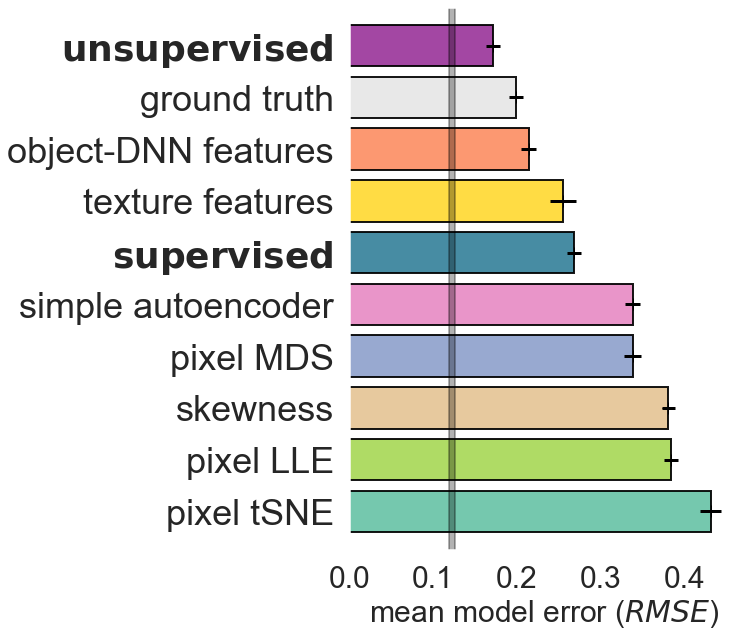

In [291]:
# summary barchart for Figure 4a (right panel)

plt.figure(figsize=(7,10))

# bars - nb. these are manually ordered to display ranked by performance
plt.barh(9, np.mean(pixelVAE_instances_rmse_expt1), edgecolor='k', alpha=0.9, color=pixelVAE_col)
plt.barh(8, np.mean(groundtruth_rmse_expt1), edgecolor='k', alpha=0.9, color=groundtruth_col)
plt.barh(7, np.mean(imagenet_rmse_expt1), edgecolor='k', alpha=0.9, color=imagenet_col)
plt.barh(6, np.mean(texture_rmse_expt1), edgecolor='k', alpha=0.9, color=texture_col)
plt.barh(5, np.mean(resnet_instances_rmse_expt1), edgecolor='k', alpha=0.9, color=resnet_col)
plt.barh(4, np.mean(simpleAE_rmse_expt1), edgecolor='k', alpha=0.9, color=simpleAE_col)
plt.barh(3, np.mean(MDS_rmse_expt1), edgecolor='k', alpha=0.9, color=MDS_col)
plt.barh(2, np.mean(skew_rmse_expt1), edgecolor='k', alpha=0.9, color=skew_col)
plt.barh(1, np.mean(LLE_rmse_expt1), edgecolor='k', alpha=0.9, color=LLE_col)
plt.barh(0, np.mean(tSNE_rmse_expt1), edgecolor='k', alpha=0.9, color=tSNE_col)

# SEM errors
plt.errorbar(np.mean(pixelVAE_instances_rmse_expt1), 9, xerr=np.mean(pixelVAE_instances_rmse_sem_expt1), fmt='k+-')
plt.errorbar(np.mean(groundtruth_rmse_expt1), 8, xerr=np.std(groundtruth_rmse_expt1)/np.sqrt(len(rating_per_subj)), fmt='k+-')
plt.errorbar(np.mean(imagenet_rmse_expt1),7, xerr=np.std(imagenet_rmse_expt1)/np.sqrt(len(rating_per_subj)), fmt='k+-')
plt.errorbar(np.mean(texture_rmse_expt1), 6, xerr=np.std(texture_rmse_expt1)/np.sqrt(len(rating_per_subj)), fmt='k+-')
plt.errorbar(np.mean(resnet_instances_rmse_expt1), 5, xerr=np.mean(pixelVAE_instances_rmse_sem_expt1), fmt='k+-')
plt.errorbar(np.mean(simpleAE_rmse_expt1), 4, xerr=np.std(simpleAE_rmse_expt1)/np.sqrt(len(rating_per_subj)), fmt='k+-')
plt.errorbar(np.mean(MDS_rmse_expt1),3, xerr=np.std(MDS_rmse_expt1)/np.sqrt(len(rating_per_subj)), fmt='k+-')
plt.errorbar(np.mean(skew_rmse_expt1), 2, xerr=np.std(skew_rmse_expt1)/np.sqrt(len(rating_per_subj)), fmt='k+-')
plt.errorbar(np.mean(LLE_rmse_expt1), 1, xerr=np.std(LLE_rmse_expt1)/np.sqrt(len(rating_per_subj)), fmt='k+-')
plt.errorbar(np.mean(tSNE_rmse_expt1), 0, xerr=np.std(tSNE_rmse_expt1)/np.sqrt(len(rating_per_subj)), fmt='k+-')

# add noise floor
plt.fill_between([np.mean(lower_ceiling_rmse_expt1), np.mean(upper_ceiling_rmse_expt1)], -1, 12, alpha=0.3, edgecolor='k', facecolor='k', zorder=2)

plt.yticks(range(10))
ax = plt.gca()
ax.set_yticklabels(['pixel tSNE',
                    'pixel LLE',
                    'skewness',
                    'pixel MDS',
                    'simple autoencoder',
                    '$\mathbf{supervised}$',
                    'texture features',
                    'object-DNN features',
                    'ground truth',
                    '$\mathbf{unsupervised}$'], fontsize=36)
ax.set_facecolor('w')
plt.plot([0,0],[-1,10],'k-', linewidth=2)
plt.xlabel('mean model error ($RMSE$)', fontsize=30)
plt.xticks(fontsize=30)
plt.ylim([-0.75,9.75])
plt.show()


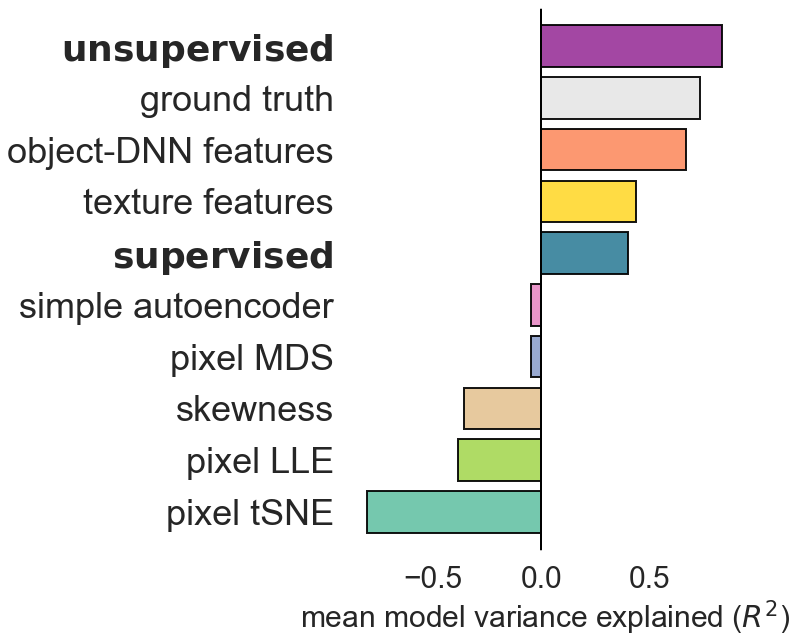

In [296]:
# summary barchart for Figure 4a (right panel)

plt.figure(figsize=(7,10))

# bars - nb. these are manually ordered to display ranked by performance
plt.barh(9, np.mean(pixelVAE_instances_r2agg_expt1), edgecolor='k', alpha=0.9, color=pixelVAE_col)
plt.barh(8, np.mean(groundtruth_r2agg_expt1), edgecolor='k', alpha=0.9, color=groundtruth_col)
plt.barh(7, np.mean(imagenet_r2agg_expt1), edgecolor='k', alpha=0.9, color=imagenet_col)
plt.barh(6, np.mean(texture_r2agg_expt1), edgecolor='k', alpha=0.9, color=texture_col)
plt.barh(5, np.mean(resnet_instances_r2agg_expt1), edgecolor='k', alpha=0.9, color=resnet_col)
plt.barh(4, np.mean(simpleAE_r2agg_expt1), edgecolor='k', alpha=0.9, color=simpleAE_col)
plt.barh(3, np.mean(MDS_r2agg_expt1), edgecolor='k', alpha=0.9, color=MDS_col)
plt.barh(2, np.mean(skew_r2agg_expt1), edgecolor='k', alpha=0.9, color=skew_col)
plt.barh(1, np.mean(LLE_r2agg_expt1), edgecolor='k', alpha=0.9, color=LLE_col)
plt.barh(0, np.mean(tSNE_r2agg_expt1), edgecolor='k', alpha=0.9, color=tSNE_col)

plt.yticks(range(10))
ax = plt.gca()
ax.set_yticklabels(['pixel tSNE',
                    'pixel LLE',
                    'skewness',
                    'pixel MDS',
                    'simple autoencoder',
                    '$\mathbf{supervised}$',
                    'texture features',
                    'object-DNN features',
                    'ground truth',
                    '$\mathbf{unsupervised}$'], fontsize=36)
ax.set_facecolor('w')
plt.plot([0,0],[-1,10],'k-', linewidth=2)
plt.xlabel('mean model variance explained ($R^2$)', fontsize=30)
plt.xticks(fontsize=30)
plt.ylim([-0.75,9.75])
plt.show()


In [298]:
# finally, calculate representational similarity between model predictions
# (needed for Figure 7b)

from scipy.spatial.distance import pdist, squareform

# manually ordered here following grouping in Figure 7b
predictions = np.array([norm_to_rating_range(pixelVAE_avg),
                        norm_to_rating_range(contPVAE_avg),
                        norm_to_rating_range(highvarPVAE),
                        norm_to_rating_range(groundtruth),
                        norm_to_rating_range(texture),
                        norm_to_rating_range(imagenet),
                        norm_to_rating_range(resnet_avg),
                        norm_to_rating_range(LLE),
                        norm_to_rating_range(simpleAE),
                        norm_to_rating_range(MDS),
                        norm_to_rating_range(skew),
                        norm_to_rating_range(tSNE)])
         
intermodelRDM_expt1 = pdist(predictions, metric='euclidean')

## Experiment 2 (gloss-modulated images generated by PixelVAE models)
Gloss-modulated images are generated from PixelVAE models by sampling in steps along the axis in latent space that best separates high- from low-gloss images. In Experiment 2, participants sort the members of each sequence according to perceived gloss. Here we don't compare to any other model predictions, since some are undefined (i.e. ground truth).
- nb. This was conducted in same session as pilot experiment, so demographics are same as above.

In [299]:
expt_path = './analysis_data/psychophysics/expt2/'
data_files = [f for f in os.listdir(expt_path) if f.endswith('.csv')]
len(data_files)

20

In [300]:
# extract each participant's ordering of each stimulus sequence
order_per_subj_per_seq = []
for s in range(len(data_files)):
    this_subj = pd.read_csv(os.path.join(expt_path, data_files[s]))
    sorted_subj = this_subj.sort_values(by=['trials_1.thisIndex'])['placement_order']
    subj_resps = []
    for row in range(sorted_subj.shape[0]):
        _resps = [int(i) for i in sorted_subj.iloc[row] if i=='1' or i=='2' or i=='3' or i=='4' or i=='5']
        subj_resps.append(_resps)
    order_per_subj_per_seq.append(subj_resps)
order_per_subj_per_seq = np.array(order_per_subj_per_seq)
order_per_subj_per_seq.shape

# group data according to gloss level of seed image used to create that sequence
gloss_idx = [i for i in range(0,80,8)]
glossy_seeds = []
matte_seeds = []
for i in gloss_idx:
    glossy_seeds.append(order_per_subj_per_seq[:, i:i+4, :])
    matte_seeds.append(order_per_subj_per_seq[:, i+4:i+8, :])
glossy_seeds = np.array(glossy_seeds).mean(axis=0).mean(axis=1) # collapse over both models and seeds
matte_seeds = np.array(matte_seeds).mean(axis=0).mean(axis=1)

### _Figure 4b: Experiment 2 data vs PixelVAE model predictions line graph_

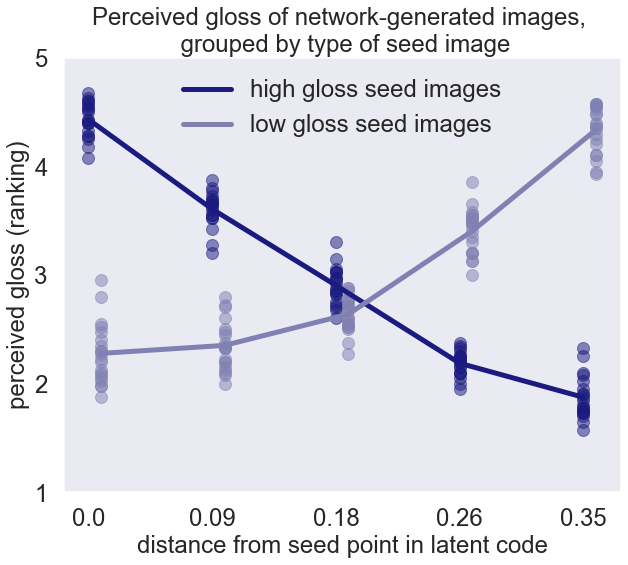

In [301]:
gloss_col = [0.1, 0.1, 0.5]
matte_col = [0.5, 0.5, 0.7]

plt.figure(figsize=(10,8))
for i in range(5):
    plt.plot(i*np.ones([20,1]), glossy_seeds[:,4-i], 'o', color=gloss_col, alpha=0.5) # flip plot ordering of glossy seeds
    plt.plot(i*np.ones([20,1])+0.1, matte_seeds[:,i], 'o', color=matte_col, alpha=0.5)
# add trendlines
plt.plot(range(5), glossy_seeds.mean(axis=0)[::-1], '-', color=gloss_col, linewidth=5, label='high gloss seed images')  # flip plot ordering of glossy seeds
plt.plot([i+0.1 for i in range(5)], matte_seeds.mean(axis=0), '-', color=matte_col, linewidth=5, label='low gloss seed images')
plt.title('Perceived gloss of network-generated images, \n grouped by type of seed image')
plt.xlabel('distance from seed point in latent code')
plt.ylabel('perceived gloss (ranking)')
plt.yticks(range(1,6),fontsize=24)
ax = plt.gca()
plt.xticks(range(5), fontsize=24)
ax.set_xticklabels([round(i,2) for i in np.linspace(0,0.35,5)])
plt.legend(fontsize=24, loc='upper center', frameon=False) 
plt.show()

In [302]:
# wrangle data into dataframe format required, 
# and run one-way ANOVA on glossy-seed images:

for step in range(5):
    
    if step == 0:
        gloss_df = pd.DataFrame([glossy_seeds[:,step],[i for i in range(20)],[step for i in range(20)]])
        gloss_df = gloss_df.transpose()
        gloss_df.columns = ['glossval','subj','step']
    
    else:
        _df = pd.DataFrame([glossy_seeds[:,step],[i for i in range(20)],[step for i in range(20)]])
        _df = _df.transpose()
        _df.columns = ['glossval','subj','step']
        gloss_df = gloss_df.append(_df)

aovrm = AnovaRM(gloss_df, depvar='glossval', subject='subj', within=['step'])
res = aovrm.fit()
print(res)
print(res.anova_table['Pr > F']) # see full p value

               Anova
     F Value  Num DF  Den DF Pr > F
-----------------------------------
step 649.8220 4.0000 76.0000 0.0000

step    6.452216e-58
Name: Pr > F, dtype: float64


In [303]:
# wrangle data into dataframe format required, 
# and run one-way ANOVA on matte-seed images

for step in range(5):
    
    if step == 0:
        matte_df = pd.DataFrame([matte_seeds[:,step],[i for i in range(20)],[step for i in range(20)]])
        matte_df = matte_df.transpose()
        matte_df.columns = ['glossval','subj','step']
    
    else:
        _df = pd.DataFrame([matte_seeds[:,step],[i for i in range(20)],[step for i in range(20)]])
        _df = _df.transpose()
        _df.columns = ['glossval','subj','step']
        matte_df = matte_df.append(_df)

aovrm = AnovaRM(matte_df, depvar='glossval', subject='subj', within=['step'])
res = aovrm.fit()
print(res)
print(res.anova_table['Pr > F']) # see full p value

               Anova
     F Value  Num DF  Den DF Pr > F
-----------------------------------
step 244.1151 4.0000 76.0000 0.0000

step    1.536298e-42
Name: Pr > F, dtype: float64


## Experiment 3 (patterns of gloss-constancy along continuous sequences of images varying in shape)
- 3a = 10 sequences optimised for model discriminability and then eyeballed for perceptual quality
- 3b = 10 sequences entirely automatically optimised for model discriminability and prediction pattern diversity

In [304]:
expt_path_3a = './analysis_data/psychophysics/expt3/expt3a/'
expt_path_3b = './analysis_data/psychophysics/expt3/expt3b/'

In [305]:
data_files_3a = [f for f in os.listdir(expt_path_3a) if f.endswith('.csv')]
data_files_3b = [f for f in os.listdir(expt_path_3b) if f.endswith('.csv')]

In [306]:
# look at participants' demographic information expt 3a
demographics = pd.DataFrame(columns=['ID','age','gender','vision','colourvision', 'frameRate'])
usecols = ['participant ID (two digits', ' e.g. 01)', 'age', 'gender (m/f/-)', 'normal or corrected-to-normal vision (y/n)', 'expName'] # nb original columns are weirdly broken up due to a string formatting error in PsychoPy script
for s in range(len(data_files_3a)):
    this_subj = pd.read_csv(os.path.join(expt_path_3a, data_files_3a[s]))
    subj_dems = []
    for c in usecols:
        subj_dems.append(this_subj.iloc[0][c])
    demographics.loc[s] = subj_dems
    
print('N = {}'.format(len(demographics)))
print('Mean age = {}'.format(demographics['age'].mean()))
print('\nGender identity:')
print(demographics['gender'].value_counts())
print('\nNormal or corrected-to-normal vision?')
print(demographics['vision'].value_counts())
print('\nFull colour vision?')
print(demographics['colourvision'].value_counts())

N = 20
Mean age = 23.45

Gender identity:
f    16
m     4
Name: gender, dtype: int64

Normal or corrected-to-normal vision?
y    20
Name: vision, dtype: int64

Full colour vision?
y    20
Name: colourvision, dtype: int64


In [307]:
# look at participants' demographic information expt 3b
demographics = pd.DataFrame(columns=['ID','age','gender','vision','colourvision', 'frameRate'])
usecols = ['participant ID (two digits', ' e.g. 01)', 'age', 'gender (m/f/-)', 'normal or corrected-to-normal vision (y/n)', 'expName'] # nb original columns are weirdly broken up due to a string formatting error in PsychoPy script
for s in range(len(data_files_3b)):
    this_subj = pd.read_csv(os.path.join(expt_path_3b, data_files_3b[s]))
    subj_dems = []
    for c in usecols:
        subj_dems.append(this_subj.iloc[0][c])
    demographics.loc[s] = subj_dems
    
print('N = {}'.format(len(demographics)))
print('Mean age = {}'.format(demographics['age'].mean()))
print('\nGender identity:')
print(demographics['gender'].value_counts())
print('\nNormal or corrected-to-normal vision?')
print(demographics['vision'].value_counts())
print('\nFull colour vision?')
print(demographics['colourvision'].value_counts())

N = 20
Mean age = 24.25

Gender identity:
f    14
m     6
Name: gender, dtype: int64

Normal or corrected-to-normal vision?
y    19
n     1
Name: vision, dtype: int64

Full colour vision?
y    19
n     1
Name: colourvision, dtype: int64


**Get and format response data for all participants in both experiments 3a and 3b:**

In [308]:
# list of permutations of the 7 image steps shown in the experiment
step_comparisons = np.array([[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[1,2],[1,3],[1,4],[1,5],[1,6],[2,3],[2,4],[2,5],[2,6],[3,4],[3,5],[3,6],[4,5],[4,6],[5,6]])

In [309]:
# first get expt 3a
expt_path = expt_path_3a
data_files = data_files_3a

# 'all_data' is all individual 2AFC curves for every Sequence x Step length x N Subjects
all_data = np.empty([20, 7, len(data_files)])

for s in range(len(data_files)):
    this_subj = pd.read_csv(os.path.join(expt_path, data_files[s]))
    # separately counting up within each of the two repetition runs, for now, for simplicity
    sorted_ratings1 = this_subj[this_subj['trials_1.thisRepN']==0].sort_values(by='trials_1.thisIndex')['corresponding_image']
    sorted_ratings2 = this_subj[this_subj['trials_1.thisRepN']==1].sort_values(by='trials_1.thisIndex')['corresponding_image']

    per_seq1 = [sorted_ratings1[i:i+21] for i in range(0,210,21)]
    per_seq1 = np.array(per_seq1)
    per_seq2 = [sorted_ratings2[i:i+21] for i in range(0,210,21)]
    per_seq2 = np.array(per_seq2)
    
    # nb. order is stored in original data such that a "1" response means that pp chose 2nd item in step_comparisons as glossier
    # so now we can just brute force work out the proportion of times each step was chosen as glossiest
    for seq in range(10):
        glossier_list1 = [step_comparisons[i][per_seq1[seq][i]] for i in range(len(step_comparisons))]
        glossier_list2 = [step_comparisons[i][per_seq2[seq][i]] for i in range(len(step_comparisons))]
        # calculate 2 separate afc curves initially, one from each repetition
        afc_curve1 = [glossier_list1.count(i) for i in range(7)]
        afc_curve2 = [glossier_list2.count(i) for i in range(7)]
        # calculate an aggregated and normalised curve for this participant
        afc_curve = [(afc_curve1[i] + afc_curve2[i])/14 for i in range(7)]
        all_data[seq,:,s] = afc_curve

# then get and append expt 3b
expt_path = expt_path_3b
data_files = data_files_3b

for s in range(len(data_files)):
    this_subj = pd.read_csv(os.path.join(expt_path, data_files[s]))
    # separately counting up within each of the two repetition runs, for now, for simplicity
    sorted_ratings1 = this_subj[this_subj['trials_1.thisRepN']==0].sort_values(by='trials_1.thisIndex')['corresponding_image']
    sorted_ratings2 = this_subj[this_subj['trials_1.thisRepN']==1].sort_values(by='trials_1.thisIndex')['corresponding_image']

    per_seq1 = [sorted_ratings1[i:i+21] for i in range(0,210,21)]
    per_seq1 = np.array(per_seq1)
    per_seq2 = [sorted_ratings2[i:i+21] for i in range(0,210,21)]
    per_seq2 = np.array(per_seq2)
    
    # nb. order is stored in original data such that a "1" response means that pp chose 2nd item in step_comparisons as glossier
    # so now we can just brute force work out the proportion of times each step was chosen as glossiest
    for seq in range(10):
        glossier_list1 = [step_comparisons[i][per_seq1[seq][i]] for i in range(len(step_comparisons))]
        glossier_list2 = [step_comparisons[i][per_seq2[seq][i]] for i in range(len(step_comparisons))]
        # calculate 2 separate afc curves initially, one from each repetition
        afc_curve1 = [glossier_list1.count(i) for i in range(7)]
        afc_curve2 = [glossier_list2.count(i) for i in range(7)]
        # calculate an aggregated and normalised curve for this participant
        afc_curve = [(afc_curve1[i] + afc_curve2[i])/14 for i in range(7)]
        all_data[seq+10,:,s] = afc_curve # append at end of 3a data

all_data.shape

(20, 7, 20)

**Get and combine predictions from 2AFC simulations for all models for both expts 3a and 3b:**
- Note that these overwrite the model variable names used in Expt 1 analysis.

In [310]:
model_path = './analysis_data/model_predicted_gloss/expt3_images/'

# once loaded, select only those candidate sequences actually used in experiment:
expt_seqs_3a = [4, 5, 12, 90, 95, 96, 102, 113, 146, 195] # nb corresponding file names start at 1, not 0
expt_seqs_3b = [42, 47, 56, 66, 147, 150, 160, 165, 169, 196] # nb corresponding file names start at 1, not 0

# unsupervised PixelVAE models
pixelVAE_3a = np.load(os.path.join(model_path,'2AFC_simulation_all_pixelVAEs_expt3a.npy'))
pixelVAE_3a = pixelVAE_3a[[i-1 for i in expt_seqs_3a],:,:]
pixelVAE_3b = np.load(os.path.join(model_path,'2AFC_simulation_all_pixelVAEs_expt3b.npy'))
pixelVAE_3b = pixelVAE_3b[[i-1 for i in expt_seqs_3b],:,:]
pixelVAE = np.concatenate((pixelVAE_3a, pixelVAE_3b),axis=0)

# supervised ResNet models
resnet_3a = np.load(os.path.join(model_path,'2AFC_simulation_all_Resnets_expt3a.npy'))
resnet_3a = resnet_3a[[i-1 for i in expt_seqs_3a],:,:]
resnet_3b = np.load(os.path.join(model_path,'2AFC_simulation_all_Resnets_expt3b.npy'))
resnet_3b = resnet_3b[[i-1 for i in expt_seqs_3b],:,:]
resnet = np.concatenate((resnet_3a, resnet_3b),axis=0)

# alternative comparison models
texture_3a = np.load(os.path.join(model_path,'2AFC_simulation_ps_texturefeats_expt3a.npy'))
texture_3a = texture_3a[[i-1 for i in expt_seqs_3a],:,:]
texture_3b = np.load(os.path.join(model_path,'2AFC_simulation_ps_texturefeats_expt3b.npy'))
texture_3b = texture_3b[[i-1 for i in expt_seqs_3b],:,:]
texture = np.concatenate((texture_3a, texture_3b),axis=0)

skew_3a = np.load(os.path.join(model_path,'2AFC_simulation_skewness_expt3a.npy'))
skew_3a = skew_3a[[i-1 for i in expt_seqs_3a],:,:]
skew_3b = np.load(os.path.join(model_path,'2AFC_simulation_skewness_expt3b.npy'))
skew_3b = skew_3b[[i-1 for i in expt_seqs_3b],:,:]
skew = np.concatenate((skew_3a, skew_3b),axis=0)

simpleAE_3a = np.load(os.path.join(model_path,'2AFC_simulation_simpleAE_expt3a.npy'))
simpleAE_3a = simpleAE_3a[[i-1 for i in expt_seqs_3a],:,:]
simpleAE_3b = np.load(os.path.join(model_path,'2AFC_simulation_simpleAE_expt3b.npy'))
simpleAE_3b = simpleAE_3b[[i-1 for i in expt_seqs_3b],:,:]
simpleAE = np.concatenate((simpleAE_3a, simpleAE_3b),axis=0)

MDS_3a = np.load(os.path.join(model_path,'2AFC_simulation_pixel-10D-embedding_MDS_expt3a.npy')) # only calculated for experimental sequences
MDS_3b = np.load(os.path.join(model_path,'2AFC_simulation_pixel-10D-embedding_MDS_expt3b.npy')) # only calculated for experimental sequences
MDS = np.concatenate((MDS_3a, MDS_3b),axis=0)

tSNE_3a = np.load(os.path.join(model_path,'2AFC_simulation_pixel-10D-embedding_tSNE_expt3a.npy')) # only calculated for experimental sequences
tSNE_3b = np.load(os.path.join(model_path,'2AFC_simulation_pixel-10D-embedding_tSNE_expt3b.npy')) # only calculated for experimental sequences
tSNE = np.concatenate((tSNE_3a, tSNE_3b),axis=0)

LLE_3a = np.load(os.path.join(model_path,'2AFC_simulation_pixel-10D-embedding_LLE_expt3a.npy')) # only calculated for experimental sequences
LLE_3b = np.load(os.path.join(model_path,'2AFC_simulation_pixel-10D-embedding_LLE_expt3b.npy')) # only calculated for experimental sequences
LLE = np.concatenate((LLE_3a, LLE_3b),axis=0)

imagenet_3a = np.load(os.path.join(model_path,'2AFC_simulation_imagenetDNN_expt3a.npy')) # only calculated for experimental sequences
imagenet_3b = np.load(os.path.join(model_path,'2AFC_simulation_imagenetDNN_expt3b.npy')) # only calculated for experimental sequences
imagenet = np.concatenate((imagenet_3a, imagenet_3b),axis=0)

# also load PixelVAE variants, which will be evaluated later (Figure 7):
contPVAE_3a = np.load(os.path.join(model_path,'2AFC_simulation_continuous_gloss_trained_pixelVAEs_expt3a.npy'))
contPVAE_3a = contPVAE_3a[[i-1 for i in expt_seqs_3a],:,:]
contPVAE_3b = np.load(os.path.join(model_path,'2AFC_simulation_continuous_gloss_trained_pixelVAEs_expt3b.npy'))
contPVAE_3b = contPVAE_3b[[i-1 for i in expt_seqs_3b],:,:]
contPVAE = np.concatenate((contPVAE_3a, contPVAE_3b),axis=0)

highvarPVAE_3a = np.load(os.path.join(model_path,'2AFC_simulation_higher_variance_trained_pixelVAE_expt3a.npy'))
highvarPVAE_3a = highvarPVAE_3a[[i-1 for i in expt_seqs_3a],:,:]
highvarPVAE_3b = np.load(os.path.join(model_path,'2AFC_simulation_higher_variance_trained_pixelVAE_expt3b.npy'))
highvarPVAE_3b = highvarPVAE_3b[[i-1 for i in expt_seqs_3b],:,:]
highvarPVAE = np.concatenate((highvarPVAE_3a, highvarPVAE_3b),axis=0)

regPVAE00_3a = np.load(os.path.join(model_path,'2AFC_simulation_contPixelVAE00_expt3a.npy'))
regPVAE00_3a = regPVAE00_3a[[i-1 for i in expt_seqs_3a],:,:]
regPVAE00_3b = np.load(os.path.join(model_path,'2AFC_simulation_contPixelVAE00_expt3b.npy'))
regPVAE00_3b = regPVAE00_3b[[i-1 for i in expt_seqs_3b],:,:]
regPVAE00 = np.concatenate((regPVAE00_3a, regPVAE00_3b),axis=0)

regPVAE01_3a = np.load(os.path.join(model_path,'2AFC_simulation_contPixelVAE01_expt3a.npy'))
regPVAE01_3a = regPVAE01_3a[[i-1 for i in expt_seqs_3a],:,:]
regPVAE01_3b = np.load(os.path.join(model_path,'2AFC_simulation_contPixelVAE01_expt3b.npy'))
regPVAE01_3b = regPVAE01_3b[[i-1 for i in expt_seqs_3b],:,:]
regPVAE01 = np.concatenate((regPVAE01_3a, regPVAE01_3b),axis=0)

# also load hyperparameter-search PixelVAE and Resnet variants,
# which will be evaluated later (Supplementary Figure 5)

# unsupervised pixelVAEs
modelID = 'filters-80_resnets-2_logmixes-12_lr-0.001_decay-1.0'
pvae_f80l2_3a = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3a.npy').format(modelID))
pvae_f80l2_3a = pvae_f80l2_3a[[i-1 for i in expt_seqs_3a],:,:]
pvae_f80l2_3b = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3b.npy').format(modelID))
pvae_f80l2_3b = pvae_f80l2_3b[[i-1 for i in expt_seqs_3b],:,:]
pvae_f80l2 = np.concatenate((pvae_f80l2_3a, pvae_f80l2_3b),axis=0)

modelID = 'filters-48_resnets-4_logmixes-12_lr-0.001_decay-1.0'
pvae_f48l4_3a = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3a.npy').format(modelID))
pvae_f48l4_3a = pvae_f48l4_3a[[i-1 for i in expt_seqs_3a],:,:]
pvae_f48l4_3b = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3b.npy').format(modelID))
pvae_f48l4_3b = pvae_f48l4_3b[[i-1 for i in expt_seqs_3b],:,:]
pvae_f48l4 = np.concatenate((pvae_f48l4_3a, pvae_f48l4_3b),axis=0)

modelID = 'filters-64_resnets-3_logmixes-4_lr-0.001_decay-1.0'
pvae_log4_3a = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3a.npy').format(modelID))
pvae_log4_3a = pvae_log4_3a[[i-1 for i in expt_seqs_3a],:,:]
pvae_log4_3b = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3b.npy').format(modelID))
pvae_log4_3b = pvae_log4_3b[[i-1 for i in expt_seqs_3b],:,:]
pvae_log4 = np.concatenate((pvae_log4_3a, pvae_log4_3b),axis=0)

modelID = 'filters-64_resnets-3_logmixes-6_lr-0.001_decay-1.0'
pvae_log6_3a = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3a.npy').format(modelID))
pvae_log6_3a = pvae_log6_3a[[i-1 for i in expt_seqs_3a],:,:]
pvae_log6_3b = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3b.npy').format(modelID))
pvae_log6_3b = pvae_log6_3b[[i-1 for i in expt_seqs_3b],:,:]
pvae_log6 = np.concatenate((pvae_log6_3a, pvae_log6_3b),axis=0)

modelID = 'filters-64_resnets-3_logmixes-24_lr-0.001_decay-1.0'
pvae_log24_3a = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3a.npy').format(modelID))
pvae_log24_3a = pvae_log24_3a[[i-1 for i in expt_seqs_3a],:,:]
pvae_log24_3b = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3b.npy').format(modelID))
pvae_log24_3b = pvae_log24_3b[[i-1 for i in expt_seqs_3b],:,:]
pvae_log24 = np.concatenate((pvae_log24_3a, pvae_log24_3b),axis=0)

modelID = 'filters-64_resnets-3_logmixes-30_lr-0.001_decay-1.0'
pvae_log30_3a = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3a.npy').format(modelID))
pvae_log30_3a = pvae_log30_3a[[i-1 for i in expt_seqs_3a],:,:]
pvae_log30_3b = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3b.npy').format(modelID))
pvae_log30_3b = pvae_log30_3b[[i-1 for i in expt_seqs_3b],:,:]
pvae_log30 = np.concatenate((pvae_log30_3a, pvae_log30_3b),axis=0)

modelID = 'filters-64_resnets-3_logmixes-12_lr-0.01_decay-1.0'
pvae_lr01_3a = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3a.npy').format(modelID))
pvae_lr01_3a = pvae_lr01_3a[[i-1 for i in expt_seqs_3a],:,:]
pvae_lr01_3b = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3b.npy').format(modelID))
pvae_lr01_3b = pvae_lr01_3b[[i-1 for i in expt_seqs_3b],:,:]
pvae_lr01 = np.concatenate((pvae_lr01_3a, pvae_lr01_3b),axis=0)

modelID = 'filters-64_resnets-3_logmixes-12_lr-0.005_decay-1.0'
pvae_lr005_3a = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3a.npy').format(modelID))
pvae_lr005_3a = pvae_lr005_3a[[i-1 for i in expt_seqs_3a],:,:]
pvae_lr005_3b = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3b.npy').format(modelID))
pvae_lr005_3b = pvae_lr005_3b[[i-1 for i in expt_seqs_3b],:,:]
pvae_lr005 = np.concatenate((pvae_lr005_3a, pvae_lr005_3b),axis=0)

modelID = 'filters-64_resnets-3_logmixes-12_lr-0.0005_decay-1.0'
pvae_lr0005_3a = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3a.npy').format(modelID))
pvae_lr0005_3a = pvae_lr0005_3a[[i-1 for i in expt_seqs_3a],:,:]
pvae_lr0005_3b = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3b.npy').format(modelID))
pvae_lr0005_3b = pvae_lr0005_3b[[i-1 for i in expt_seqs_3b],:,:]
pvae_lr0005 = np.concatenate((pvae_lr0005_3a, pvae_lr0005_3b),axis=0)

modelID = 'filters-64_resnets-3_logmixes-12_lr-0.0001_decay-1.0'
pvae_lr0001_3a = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3a.npy').format(modelID))
pvae_lr0001_3a = pvae_lr0001_3a[[i-1 for i in expt_seqs_3a],:,:]
pvae_lr0001_3b = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3b.npy').format(modelID))
pvae_lr0001_3b = pvae_lr0001_3b[[i-1 for i in expt_seqs_3b],:,:]
pvae_lr0001 = np.concatenate((pvae_lr0001_3a, pvae_lr0001_3b),axis=0)

modelID = 'filters-64_resnets-3_logmixes-12_lr-0.001_decay-0.25'
pvae_d0_25_3a = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3a.npy').format(modelID))
pvae_d0_25_3a = pvae_d0_25_3a[[i-1 for i in expt_seqs_3a],:,:]
pvae_d0_25_3b = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3b.npy').format(modelID))
pvae_d0_25_3b = pvae_d0_25_3b[[i-1 for i in expt_seqs_3b],:,:]
pvae_d0_25 = np.concatenate((pvae_d0_25_3a, pvae_d0_25_3b),axis=0)

modelID = 'filters-64_resnets-3_logmixes-12_lr-0.001_decay-0.5'
pvae_d0_50_3a = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3a.npy').format(modelID))
pvae_d0_50_3a = pvae_d0_50_3a[[i-1 for i in expt_seqs_3a],:,:]
pvae_d0_50_3b = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3b.npy').format(modelID))
pvae_d0_50_3b = pvae_d0_50_3b[[i-1 for i in expt_seqs_3b],:,:]
pvae_d0_50 = np.concatenate((pvae_d0_50_3a, pvae_d0_50_3b),axis=0)

modelID = 'filters-64_resnets-3_logmixes-12_lr-0.001_decay-2.0'
pvae_d2_00_3a = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3a.npy').format(modelID))
pvae_d2_00_3a = pvae_d2_00_3a[[i-1 for i in expt_seqs_3a],:,:]
pvae_d2_00_3b = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3b.npy').format(modelID))
pvae_d2_00_3b = pvae_d2_00_3b[[i-1 for i in expt_seqs_3b],:,:]
pvae_d2_00 = np.concatenate((pvae_d2_00_3a, pvae_d2_00_3b),axis=0)

modelID = 'filters-64_resnets-3_logmixes-12_lr-0.001_decay-4.0'
pvae_d4_00_3a = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3a.npy').format(modelID))
pvae_d4_00_3a = pvae_d4_00_3a[[i-1 for i in expt_seqs_3a],:,:]
pvae_d4_00_3b = np.load(os.path.join(model_path,'hyperparam_pixelvaes/2AFC_simulation_{}_expt3b.npy').format(modelID))
pvae_d4_00_3b = pvae_d4_00_3b[[i-1 for i in expt_seqs_3b],:,:]
pvae_d4_00 = np.concatenate((pvae_d4_00_3a, pvae_d4_00_3b),axis=0)

# supervised Resnets
modelID = 'logs_filters-80_resnets-2_batchsize-32_lr-0.01_decay-0.1'
res_f80l2_3a = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3a.npy').format(modelID))
res_f80l2_3a = res_f80l2_3a[[i-1 for i in expt_seqs_3a],:,:]
res_f80l2_3b = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3b.npy').format(modelID))
res_f80l2_3b = res_f80l2_3b[[i-1 for i in expt_seqs_3b],:,:]
res_f80l2 = np.concatenate((res_f80l2_3a, res_f80l2_3b),axis=0)

modelID = 'logs_filters-48_resnets-4_batchsize-32_lr-0.01_decay-0.1'
res_f48l4_3a = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3a.npy').format(modelID))
res_f48l4_3a = res_f48l4_3a[[i-1 for i in expt_seqs_3a],:,:]
res_f48l4_3b = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3b.npy').format(modelID))
res_f48l4_3b = res_f48l4_3b[[i-1 for i in expt_seqs_3b],:,:]
res_f48l4 = np.concatenate((res_f48l4_3a, res_f48l4_3b),axis=0)

modelID = 'logs_filters-56_resnets-3_batchsize-12_lr-0.001_decay-1.0'
res_b12_3a = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3a.npy').format(modelID))
res_b12_3a = res_b12_3a[[i-1 for i in expt_seqs_3a],:,:]
res_b12_3b = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3b.npy').format(modelID))
res_b12_3b = res_b12_3b[[i-1 for i in expt_seqs_3b],:,:]
res_b12 = np.concatenate((res_b12_3a, res_b12_3b),axis=0)

modelID = 'logs_filters-56_resnets-3_batchsize-22_lr-0.001_decay-1.0'
res_b22_3a = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3a.npy').format(modelID))
res_b22_3a = res_b22_3a[[i-1 for i in expt_seqs_3a],:,:]
res_b22_3b = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3b.npy').format(modelID))
res_b22_3b = res_b22_3b[[i-1 for i in expt_seqs_3b],:,:]
res_b22 = np.concatenate((res_b22_3a, res_b22_3b),axis=0)

modelID = 'logs_filters-56_resnets-3_batchsize-42_lr-0.001_decay-1.0'
res_b42_3a = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3a.npy').format(modelID))
res_b42_3a = res_b42_3a[[i-1 for i in expt_seqs_3a],:,:]
res_b42_3b = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3b.npy').format(modelID))
res_b42_3b = res_b42_3b[[i-1 for i in expt_seqs_3b],:,:]
res_b42 = np.concatenate((res_b42_3a, res_b42_3b),axis=0)

modelID = 'logs_filters-56_resnets-3_batchsize-50_lr-0.001_decay-1.0'
res_b50_3a = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3a.npy').format(modelID))
res_b50_3a = res_b50_3a[[i-1 for i in expt_seqs_3a],:,:]
res_b50_3b = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3b.npy').format(modelID))
res_b50_3b = res_b50_3b[[i-1 for i in expt_seqs_3b],:,:]
res_b50 = np.concatenate((res_b50_3a, res_b50_3b),axis=0)

modelID = 'logs_filters-56_resnets-3_batchsize-32_lr-0.01_decay-1.0'
res_lr01_3a = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3a.npy').format(modelID))
res_lr01_3a = res_lr01_3a[[i-1 for i in expt_seqs_3a],:,:]
res_lr01_3b = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3b.npy').format(modelID))
res_lr01_3b = res_lr01_3b[[i-1 for i in expt_seqs_3b],:,:]
res_lr01 = np.concatenate((res_lr01_3a, res_lr01_3b),axis=0)

modelID = 'logs_filters-56_resnets-3_batchsize-32_lr-0.005_decay-1.0'
res_lr005_3a = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3a.npy').format(modelID))
res_lr005_3a = res_lr005_3a[[i-1 for i in expt_seqs_3a],:,:]
res_lr005_3b = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3b.npy').format(modelID))
res_lr005_3b = res_lr005_3b[[i-1 for i in expt_seqs_3b],:,:]
res_lr005 = np.concatenate((res_lr005_3a, res_lr005_3b),axis=0)

modelID = 'logs_filters-56_resnets-3_batchsize-32_lr-0.0005_decay-1.0'
res_lr0005_3a = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3a.npy').format(modelID))
res_lr0005_3a = res_lr0005_3a[[i-1 for i in expt_seqs_3a],:,:]
res_lr0005_3b = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3b.npy').format(modelID))
res_lr0005_3b = res_lr0005_3b[[i-1 for i in expt_seqs_3b],:,:]
res_lr0005 = np.concatenate((res_lr0005_3a, res_lr0005_3b),axis=0)

modelID = 'logs_filters-56_resnets-3_batchsize-32_lr-0.0001_decay-1.0'
res_lr0001_3a = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3a.npy').format(modelID))
res_lr0001_3a = res_lr0001_3a[[i-1 for i in expt_seqs_3a],:,:]
res_lr0001_3b = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3b.npy').format(modelID))
res_lr0001_3b = res_lr0001_3b[[i-1 for i in expt_seqs_3b],:,:]
res_lr0001 = np.concatenate((res_lr0001_3a, res_lr0001_3b),axis=0)

modelID = 'logs_filters-56_resnets-3_batchsize-32_lr-0.001_decay-0.25'
res_d0_25_3a = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3a.npy').format(modelID))
res_d0_25_3a = res_d0_25_3a[[i-1 for i in expt_seqs_3a],:,:]
res_d0_25_3b = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3b.npy').format(modelID))
res_d0_25_3b = res_d0_25_3b[[i-1 for i in expt_seqs_3b],:,:]
res_d0_25 = np.concatenate((res_d0_25_3a, res_d0_25_3b),axis=0)

modelID = 'logs_filters-56_resnets-3_batchsize-32_lr-0.001_decay-0.50'
res_d0_50_3a = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3a.npy').format(modelID))
res_d0_50_3a = res_d0_50_3a[[i-1 for i in expt_seqs_3a],:,:]
res_d0_50_3b = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3b.npy').format(modelID))
res_d0_50_3b = res_d0_50_3b[[i-1 for i in expt_seqs_3b],:,:]
res_d0_50 = np.concatenate((res_d0_50_3a, res_d0_50_3b),axis=0)

modelID = 'logs_filters-56_resnets-3_batchsize-32_lr-0.001_decay-2.00'
res_d2_00_3a = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3a.npy').format(modelID))
res_d2_00_3a = res_d2_00_3a[[i-1 for i in expt_seqs_3a],:,:]
res_d2_00_3b = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3b.npy').format(modelID))
res_d2_00_3b = res_d2_00_3b[[i-1 for i in expt_seqs_3b],:,:]
res_d2_00 = np.concatenate((res_d2_00_3a, res_d2_00_3b),axis=0)

modelID = 'logs_filters-56_resnets-3_batchsize-32_lr-0.001_decay-4.00'
res_d4_00_3a = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3a.npy').format(modelID))
res_d4_00_3a = res_d4_00_3a[[i-1 for i in expt_seqs_3a],:,:]
res_d4_00_3b = np.load(os.path.join(model_path,'hyperparam_resnets/2AFC_simulation_{}_expt3b.npy').format(modelID))
res_d4_00_3b = res_d4_00_3b[[i-1 for i in expt_seqs_3b],:,:]
res_d4_00 = np.concatenate((res_d4_00_3a, res_d4_00_3b),axis=0)

# conv layers for Supplementary Figure 4
pvae_conv1_3a = np.load(os.path.join(model_path,'2AFC_simulation_pixelvae01_conv1_expt3a.npy'))
pvae_conv1_3a = pvae_conv1_3a[[i-1 for i in expt_seqs_3a],:,:]
pvae_conv1_3b = np.load(os.path.join(model_path,'2AFC_simulation_pixelvae01_conv1_expt3b.npy'))
pvae_conv1_3b = pvae_conv1_3b[[i-1 for i in expt_seqs_3b],:,:]
pvae_conv1 = np.concatenate((pvae_conv1_3a, pvae_conv1_3b),axis=0)

pvae_conv2_3a = np.load(os.path.join(model_path,'2AFC_simulation_pixelvae01_conv2_expt3a.npy'))
pvae_conv2_3a = pvae_conv2_3a[[i-1 for i in expt_seqs_3a],:,:]
pvae_conv2_3b = np.load(os.path.join(model_path,'2AFC_simulation_pixelvae01_conv2_expt3b.npy'))
pvae_conv2_3b = pvae_conv2_3b[[i-1 for i in expt_seqs_3b],:,:]
pvae_conv2 = np.concatenate((pvae_conv2_3a, pvae_conv2_3b),axis=0)

pvae_conv3_3a = np.load(os.path.join(model_path,'2AFC_simulation_pixelvae01_conv3_expt3a.npy'))
pvae_conv3_3a = pvae_conv3_3a[[i-1 for i in expt_seqs_3a],:,:]
pvae_conv3_3b = np.load(os.path.join(model_path,'2AFC_simulation_pixelvae01_conv3_expt3b.npy'))
pvae_conv3_3b = pvae_conv3_3b[[i-1 for i in expt_seqs_3b],:,:]
pvae_conv3 = np.concatenate((pvae_conv3_3a, pvae_conv3_3b),axis=0)

res_conv1_3a = np.load(os.path.join(model_path,'2AFC_simulation_resnet09_conv1_expt3a.npy'))
res_conv1_3a = res_conv1_3a[[i-1 for i in expt_seqs_3a],:,:]
res_conv1_3b = np.load(os.path.join(model_path,'2AFC_simulation_resnet09_conv1_expt3b.npy'))
res_conv1_3b = res_conv1_3b[[i-1 for i in expt_seqs_3b],:,:]
res_conv1 = np.concatenate((res_conv1_3a, res_conv1_3b),axis=0)

res_conv2_3a = np.load(os.path.join(model_path,'2AFC_simulation_resnet09_conv2_expt3a.npy'))
res_conv2_3a = res_conv2_3a[[i-1 for i in expt_seqs_3a],:,:]
res_conv2_3b = np.load(os.path.join(model_path,'2AFC_simulation_resnet09_conv2_expt3b.npy'))
res_conv2_3b = res_conv2_3b[[i-1 for i in expt_seqs_3b],:,:]
res_conv2 = np.concatenate((res_conv2_3a, res_conv2_3b),axis=0)

res_conv3_3a = np.load(os.path.join(model_path,'2AFC_simulation_resnet09_conv3_expt3a.npy'))
res_conv3_3a = res_conv3_3a[[i-1 for i in expt_seqs_3a],:,:]
res_conv3_3b = np.load(os.path.join(model_path,'2AFC_simulation_resnet09_conv3_expt3b.npy'))
res_conv3_3b = res_conv3_3b[[i-1 for i in expt_seqs_3b],:,:]
res_conv3 = np.concatenate((res_conv3_3a, res_conv3_3b),axis=0)

# continuous regression Resnets for Supplementary Figure 4
res_cont00_3a = np.load(os.path.join(model_path,'2AFC_simulation_contResnet00_expt3a.npy'))
res_cont00_3a = res_cont00_3a[[i-1 for i in expt_seqs_3a],:,:]
res_cont00_3b = np.load(os.path.join(model_path,'2AFC_simulation_contResnet00_expt3b.npy'))
res_cont00_3b = res_cont00_3b[[i-1 for i in expt_seqs_3b],:,:]
res_cont00 = np.concatenate((res_cont00_3a, res_cont00_3b),axis=0)

res_cont01_3a = np.load(os.path.join(model_path,'2AFC_simulation_contResnet01_expt3a.npy'))
res_cont01_3a = res_cont01_3a[[i-1 for i in expt_seqs_3a],:,:]
res_cont01_3b = np.load(os.path.join(model_path,'2AFC_simulation_contResnet01_expt3b.npy'))
res_cont01_3b = res_cont01_3b[[i-1 for i in expt_seqs_3b],:,:]
res_cont01 = np.concatenate((res_cont01_3a, res_cont01_3b),axis=0)

res_cont02_3a = np.load(os.path.join(model_path,'2AFC_simulation_contResnet02_expt3a.npy'))
res_cont02_3a = res_cont02_3a[[i-1 for i in expt_seqs_3a],:,:]
res_cont02_3b = np.load(os.path.join(model_path,'2AFC_simulation_contResnet02_expt3b.npy'))
res_cont02_3b = res_cont02_3b[[i-1 for i in expt_seqs_3b],:,:]
res_cont02 = np.concatenate((res_cont02_3a, res_cont02_3b),axis=0)

res_cont03_3a = np.load(os.path.join(model_path,'2AFC_simulation_contResnet03_expt3a.npy'))
res_cont03_3a = res_cont03_3a[[i-1 for i in expt_seqs_3a],:,:]
res_cont03_3b = np.load(os.path.join(model_path,'2AFC_simulation_contResnet03_expt3b.npy'))
res_cont03_3b = res_cont03_3b[[i-1 for i in expt_seqs_3b],:,:]
res_cont03 = np.concatenate((res_cont03_3a, res_cont03_3b),axis=0)

res_cont04_3a = np.load(os.path.join(model_path,'2AFC_simulation_contResnet04_expt3a.npy'))
res_cont04_3a = res_cont04_3a[[i-1 for i in expt_seqs_3a],:,:]
res_cont04_3b = np.load(os.path.join(model_path,'2AFC_simulation_contResnet04_expt3b.npy'))
res_cont04_3b = res_cont04_3b[[i-1 for i in expt_seqs_3b],:,:]
res_cont04 = np.concatenate((res_cont04_3a, res_cont04_3b),axis=0)

### _Figure 5b / Supplementary Figure 2: Experiment 3 per-sequence data vs selected model predictions line graphs_

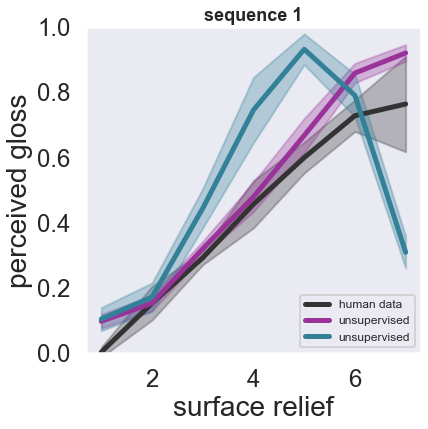

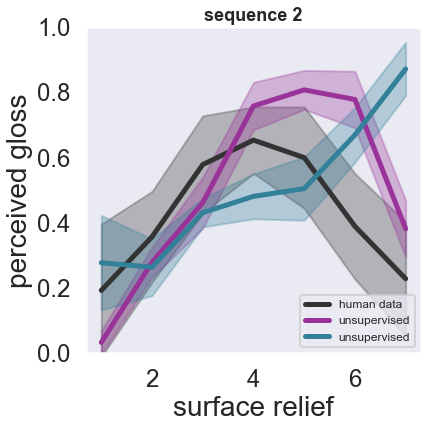

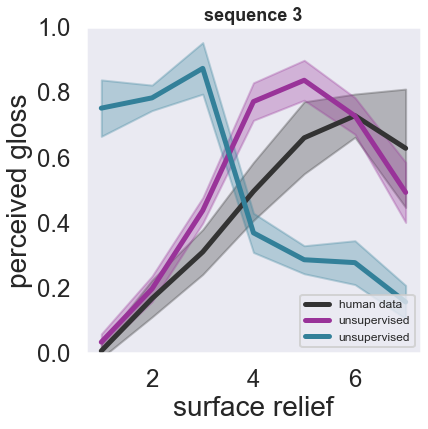

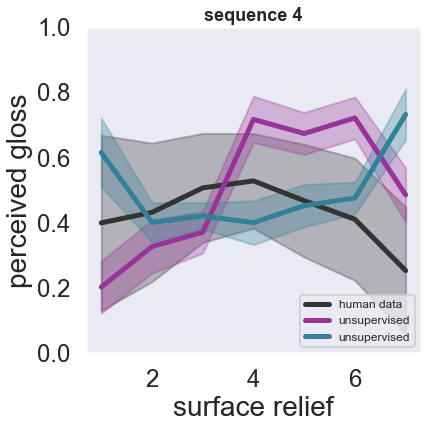

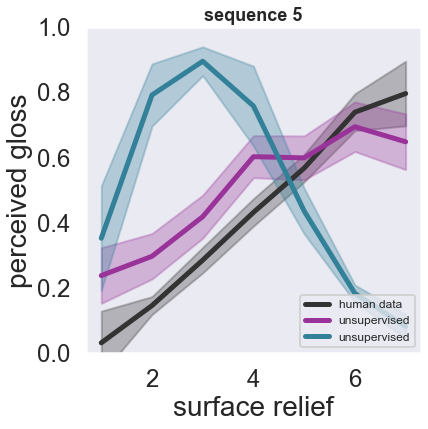

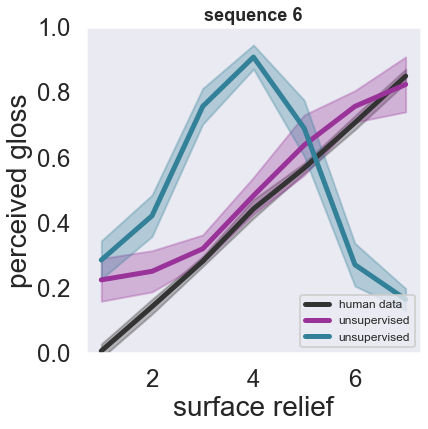

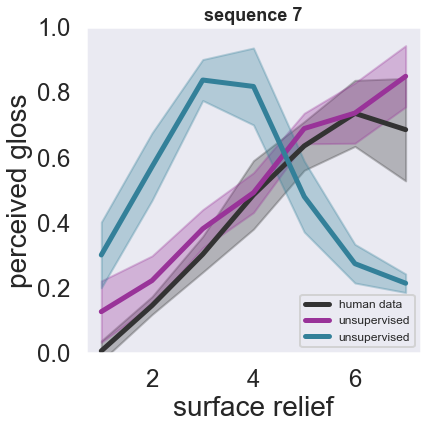

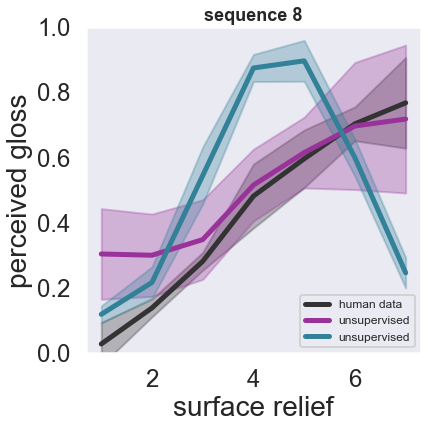

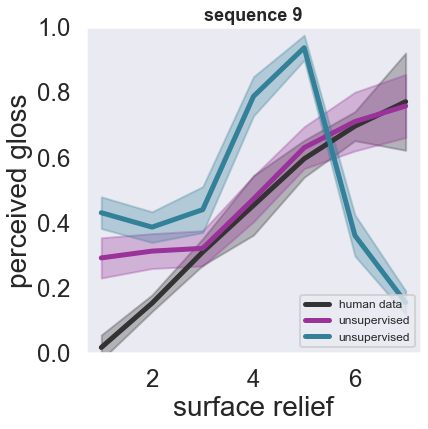

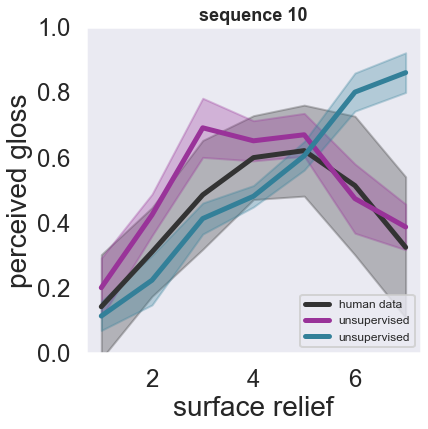

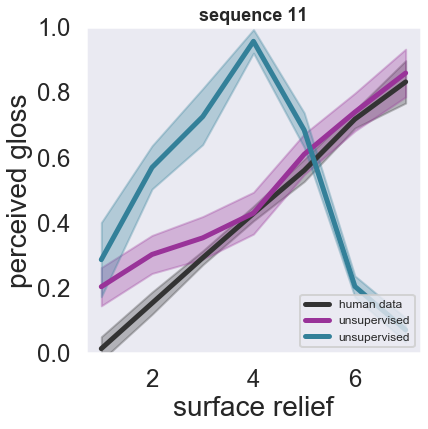

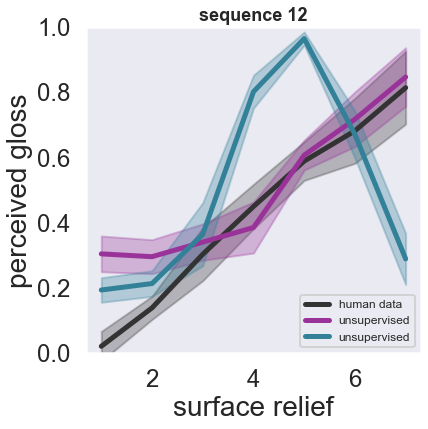

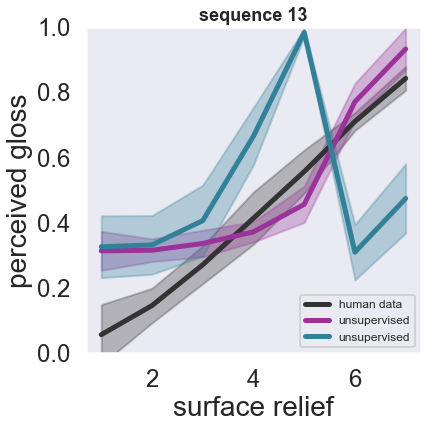

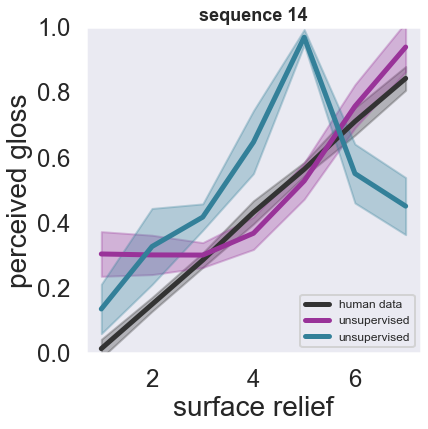

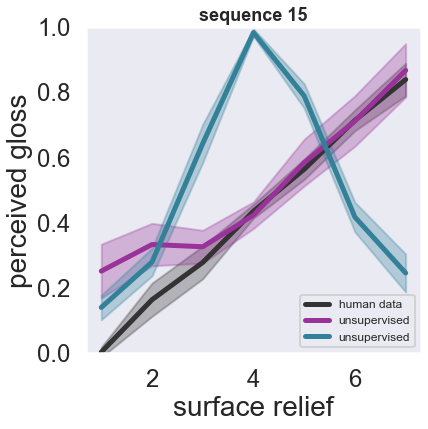

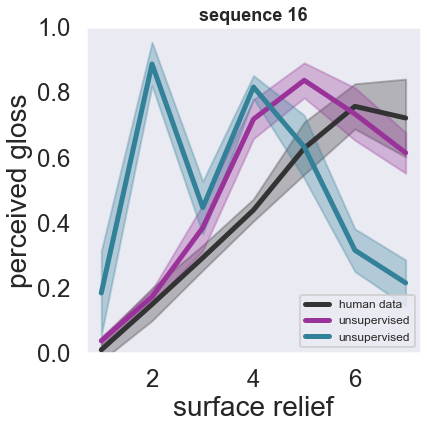

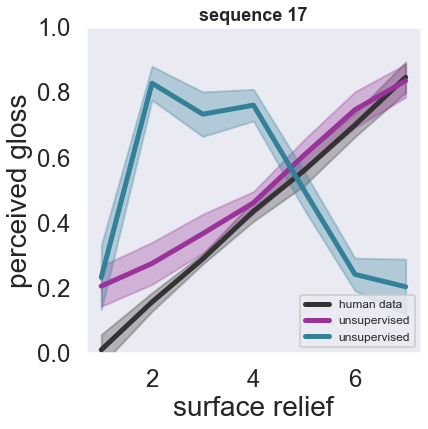

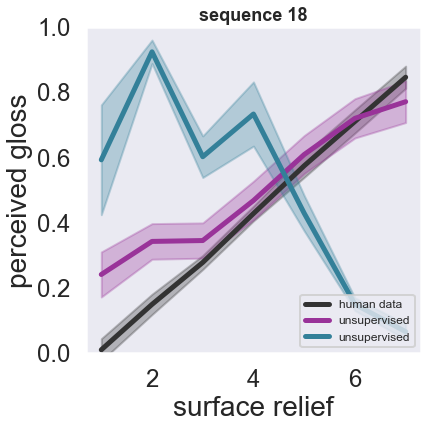

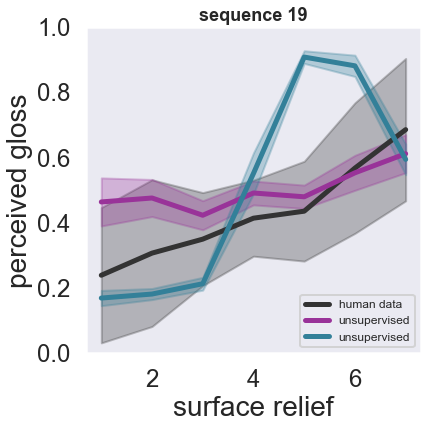

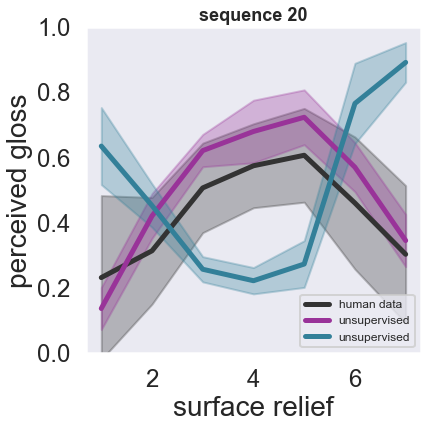

In [311]:
# plot model predictions with human data

pal = sns.color_palette("Set2",9)
h_col = [0.2, 0.2, 0.2] 

n_steps=7
for seq in range(all_data.shape[0]):
    plt.figure(figsize=(6,6))

    # show human data
    y = np.mean(all_data[seq,:,:],1)
    err = np.std(all_data[seq,:,:],1)
    plt.plot(range(1, n_steps+1), y, '-', color=h_col, linewidth=5, label='human data')
    plt.fill_between(range(1, n_steps+1), y-err, y+err, alpha=0.3, edgecolor=h_col, facecolor=h_col)
    
    # pixelVAE
    y_unsup = pixelVAE[seq,:,:].mean(axis=0)
    err = pixelVAE[seq,:,:].std(axis=0)
    plt.plot(range(1, n_steps+1), y_unsup, '-', color=pixelVAE_col, linewidth=5, label='unsupervised')
    plt.fill_between(range(1, n_steps+1), y_unsup-err, y_unsup+err, alpha=0.3, edgecolor=pixelVAE_col, facecolor=pixelVAE_col)
    
    # resnet
    y_sup = resnet[seq,:,:].mean(axis=0)
    err = resnet[seq,:,:].std(axis=0)
    plt.plot(range(1, n_steps+1), y_sup, '-', color=resnet_col, linewidth=5, label='unsupervised')
    plt.fill_between(range(1, n_steps+1), y_sup-err, y_sup+err, alpha=0.3, edgecolor=resnet_col, facecolor=resnet_col)
    
    plt.title('sequence {}'.format(seq+1), fontsize=18, fontweight='bold') # to match file numbers
    plt.xlabel('surface relief', fontsize=28)
    plt.ylabel('perceived gloss', fontsize=28)
    plt.legend(loc='lower right', fontsize=12)
    plt.ylim([0,1])
    plt.yticks(fontsize=24)
    plt.xticks(fontsize=24)
    frame1 = plt.gca()
#     frame1.axes.xaxis.set_ticklabels([])
#     frame1.axes.yaxis.set_ticklabels([])
    plt.show()

**Calculate error for all models, and inter-subject reliability**

In [352]:
# create a trivial "ground truth" model
groundtruth = np.empty([20,1,7])
for seq in range(20):
    groundtruth[seq,0,:] = [0.5 for i in range(7)]
groundtruth.shape

(20, 1, 7)

In [353]:
def model_performance_and_noise_ceilings_expt3(all_data, model_predictions, metric='rmse'):
    '''
    Calculate how well model predicts human data,
    and how well each human participant predicts others' data,
    using specified metric.
    
    - all_data should be shape [sequences X 7 steps X participants]
    - model_predictions should be shape [sequences X 7 steps] (but are squeezed in case N x 1 x 7)
    '''
    model_predictions = np.squeeze(model_predictions)
    
    model_performance = []
    lower_ceiling = []
    upper_ceiling = []

    for seq in range(all_data.shape[0]):
        model_thisseq = []
        lowceil_thisseq = []
        uppceil_thisseq = []
        
        for subj in range(all_data.shape[2]):
            target = all_data[seq,:,subj]
            
            if metric=='rmse':
                _model = np.sqrt(mean_squared_error(target, model_predictions[seq,:]))
                _lowceil = np.sqrt(mean_squared_error(target, np.delete(all_data[seq,:,:],subj,axis=1).mean(axis=1))) # lower bound - all subjs averaged, excluding this one
                _uppceil = np.sqrt(mean_squared_error(target, all_data[seq,:,:].mean(axis=1))) # upper bound - all subjs averaged, including this one
            elif metric=='corr':
                _model = pearsonr(target, model_predictions[seq,:])[0]
                _lowceil = pearsonr(target, np.delete(all_data[seq,:,:],subj,axis=1).mean(axis=1))[0] # lower bound - all subjs averaged, excluding this one
                _uppceil = pearsonr(target, all_data[seq,:,:].mean(axis=1))[0] # upper bound - all subjs averaged, including this one
            elif metric=='r2':
                _model = r2_score(target, model_predictions[seq,:])
                _lowceil = r2_score(target, np.delete(all_data[seq,:,:],subj,axis=1).mean(axis=1)) # lower bound - all subjs averaged, excluding this one
                _uppceil = r2_score(target, all_data[seq,:,:].mean(axis=1)) # upper bound - all subjs averaged, including this one
            else: print('This metric not supported. Options: rmse, corr, r2')
            
            model_thisseq.append(_model)
            lowceil_thisseq.append(_lowceil)
            uppceil_thisseq.append(_uppceil)
    
        model_performance.append(np.mean(model_thisseq))
        lower_ceiling.append(np.mean(lowceil_thisseq))
        upper_ceiling.append(np.mean(uppceil_thisseq))
    
    return model_performance, lower_ceiling, upper_ceiling

In [354]:
# get performances of ground truth and noise ceilings (measure of inter-subject reliability)
groundtruth_rmse_expt3, lower_ceiling_rmse_expt3, upper_ceiling_rmse_expt3 = model_performance_and_noise_ceilings_expt3(all_data, groundtruth, metric='rmse')

# core models
pixelVAE_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, np.mean(pixelVAE,axis=1), metric='rmse')
resnet_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, np.mean(resnet,axis=1), metric='rmse')
MDS_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, MDS, metric='rmse')
tSNE_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, tSNE, metric='rmse')
LLE_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, LLE, metric='rmse')
texture_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, texture, metric='rmse')
skew_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, skew, metric='rmse')
imagenet_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, imagenet, metric='rmse')
simpleAE_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, simpleAE, metric='rmse')

# test individual pixelVAE training instances
pixelVAE00_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,0,:], metric='rmse')
pixelVAE01_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,1,:], metric='rmse')
pixelVAE02_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,2,:], metric='rmse')
pixelVAE03_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,3,:], metric='rmse')
pixelVAE04_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,4,:], metric='rmse')
pixelVAE05_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,5,:], metric='rmse')
pixelVAE06_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,6,:], metric='rmse')
pixelVAE07_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,7,:], metric='rmse')
pixelVAE08_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,8,:], metric='rmse')
pixelVAE09_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,9,:], metric='rmse')

# test individual resnet training instances
resnet00_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,0,:], metric='rmse')
resnet01_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,1,:], metric='rmse')
resnet02_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,2,:], metric='rmse')
resnet03_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,3,:], metric='rmse')
resnet04_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,4,:], metric='rmse')
resnet05_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,5,:], metric='rmse')
resnet06_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,6,:], metric='rmse')
resnet07_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,7,:], metric='rmse')
resnet08_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,8,:], metric='rmse')
resnet09_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,9,:], metric='rmse')

# PixelVAE variants for Figure 7
contPVAE00_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, contPVAE[:,0,:], metric='rmse')
contPVAE01_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, contPVAE[:,1,:], metric='rmse')
contPVAE02_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, contPVAE[:,2,:], metric='rmse')
contPVAE03_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, contPVAE[:,3,:], metric='rmse')
contPVAE04_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, contPVAE[:,4,:], metric='rmse')

highvarPVAE_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, highvarPVAE, metric='rmse')

regPVAE00_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, regPVAE00, metric='rmse')
regPVAE01_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, regPVAE01, metric='rmse')

# hyperparameter variant PixelVAEs for Supplementary Figure 5
pvae_f80l2_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_f80l2, metric='rmse')
pvae_f48l4_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_f48l4, metric='rmse')
pvae_log4_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_log4, metric='rmse')
pvae_log6_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_log6, metric='rmse')
pvae_log24_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_log24, metric='rmse')
pvae_log30_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_log30, metric='rmse')
pvae_lr01_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_lr01, metric='rmse')
pvae_lr005_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_lr005, metric='rmse')
pvae_lr0005_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_lr0005, metric='rmse')
pvae_lr0001_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_lr0001, metric='rmse')
pvae_d0_25_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_d0_25, metric='rmse')
pvae_d0_50_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_d0_50, metric='rmse')
pvae_d2_00_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_d2_00, metric='rmse')
pvae_d4_00_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_d4_00, metric='rmse')

# hyperparameter variant Resnets for Supplementary Figure 5
res_f80l2_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_f80l2, metric='rmse')
res_f48l4_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_f48l4, metric='rmse')
res_b12_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_b12, metric='rmse')
res_b22_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_b22, metric='rmse')
res_b42_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_b42, metric='rmse')
res_b50_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_b50, metric='rmse')
res_lr01_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_lr01, metric='rmse')
res_lr005_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_lr005, metric='rmse')
res_lr0005_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_lr0005, metric='rmse')
res_lr0001_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_lr0001, metric='rmse')
res_d0_25_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_d0_25, metric='rmse')
res_d0_50_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_d0_50, metric='rmse')
res_d2_00_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_d2_00, metric='rmse')
res_d4_00_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_d4_00, metric='rmse')

# conv layers for Supplementary Figure 4
pvae_c1_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_conv1, metric='rmse')
pvae_c2_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_conv2, metric='rmse')
pvae_c3_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_conv3, metric='rmse')

res_c1_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_conv1, metric='rmse')
res_c2_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_conv2, metric='rmse')
res_c3_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_conv3, metric='rmse')

# conv layers for Supplementary Figure 4
res_cont00_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_cont00, metric='rmse')
res_cont01_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_cont01, metric='rmse')
res_cont02_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_cont02, metric='rmse')
res_cont03_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_cont03, metric='rmse')
res_cont04_rmse_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_cont04, metric='rmse')

In [355]:
# also correlations...
# get performances of ground truth and noise ceilings (measure of inter-subject reliability)
groundtruth_corr_expt3, lower_ceiling_corr_expt3, upper_ceiling_corr_expt3 = model_performance_and_noise_ceilings_expt3(all_data, groundTruth, metric='corr')

# core models
pixelVAE_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, np.mean(pixelVAE,axis=1), metric='corr')
resnet_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, np.mean(resnet,axis=1), metric='corr')
MDS_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, MDS, metric='corr')
tSNE_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, tSNE, metric='corr')
LLE_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, LLE, metric='corr')
texture_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, texture, metric='corr')
skew_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, skew, metric='corr')
imagenet_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, imagenet, metric='corr')
simpleAE_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, simpleAE, metric='corr')

# test individual pixelVAE training instances
pixelVAE00_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,0,:], metric='corr')
pixelVAE01_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,1,:], metric='corr')
pixelVAE02_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,2,:], metric='corr')
pixelVAE03_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,3,:], metric='corr')
pixelVAE04_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,4,:], metric='corr')
pixelVAE05_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,5,:], metric='corr')
pixelVAE06_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,6,:], metric='corr')
pixelVAE07_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,7,:], metric='corr')
pixelVAE08_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,8,:], metric='corr')
pixelVAE09_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pixelVAE[:,9,:], metric='corr')

# test individual resnet training instances
resnet00_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,0,:], metric='corr')
resnet01_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,1,:], metric='corr')
resnet02_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,2,:], metric='corr')
resnet03_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,3,:], metric='corr')
resnet04_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,4,:], metric='corr')
resnet05_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,5,:], metric='corr')
resnet06_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,6,:], metric='corr')
resnet07_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,7,:], metric='corr')
resnet08_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,8,:], metric='corr')
resnet09_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, resnet[:,9,:], metric='corr')

# PixelVAE variants for Figure 7
contPVAE00_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, contPVAE[:,0,:], metric='corr')
contPVAE01_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, contPVAE[:,1,:], metric='corr')
contPVAE02_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, contPVAE[:,2,:], metric='corr')
contPVAE03_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, contPVAE[:,3,:], metric='corr')
contPVAE04_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, contPVAE[:,4,:], metric='corr')

highvarPVAE_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, highvarPVAE, metric='corr')

regPVAE00_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, regPVAE00, metric='corr')
regPVAE01_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, regPVAE01, metric='corr')

# hyperparameter variant PixelVAEs for Supplementary Figure 5
pvae_f80l2_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_f80l2, metric='corr')
pvae_f48l4_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_f48l4, metric='corr')
pvae_log4_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_log4, metric='corr')
pvae_log6_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_log6, metric='corr')
pvae_log24_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_log24, metric='corr')
pvae_log30_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_log30, metric='corr')
pvae_lr01_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_lr01, metric='corr')
pvae_lr005_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_lr005, metric='corr')
pvae_lr0005_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_lr0005, metric='corr')
pvae_lr0001_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_lr0001, metric='corr')
pvae_d0_25_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_d0_25, metric='corr')
pvae_d0_50_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_d0_50, metric='corr')
pvae_d2_00_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_d2_00, metric='corr')
pvae_d4_00_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_d4_00, metric='corr')

# hyperparameter variant Resnets for Supplementary Figure 5
res_f80l2_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_f80l2, metric='corr')
res_f48l4_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_f48l4, metric='corr')
res_b12_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_b12, metric='corr')
res_b22_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_b22, metric='corr')
res_b42_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_b42, metric='corr')
res_b50_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_b50, metric='corr')
res_lr01_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_lr01, metric='corr')
res_lr005_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_lr005, metric='corr')
res_lr0005_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_lr0005, metric='corr')
res_lr0001_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_lr0001, metric='corr')
res_d0_25_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_d0_25, metric='corr')
res_d0_50_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_d0_50, metric='corr')
res_d2_00_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_d2_00, metric='corr')
res_d4_00_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_d4_00, metric='corr')

# conv layers for Supplementary Figure 4
pvae_c1_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_conv1, metric='corr')
pvae_c2_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_conv2, metric='corr')
pvae_c3_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, pvae_conv3, metric='corr')

res_c1_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_conv1, metric='corr')
res_c2_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_conv2, metric='corr')
res_c3_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_conv3, metric='corr')

# conv layers for Supplementary Figure 4
res_cont00_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_cont00, metric='corr')
res_cont01_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_cont01, metric='corr')
res_cont02_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_cont02, metric='corr')
res_cont03_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_cont03, metric='corr')
res_cont04_corr_expt3, _, _ = model_performance_and_noise_ceilings_expt3(all_data, res_cont04, metric='corr')

D:\kates\Anaconda3\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [362]:
# also calculate R2 value for models against average human data, disregarding inter-subject variability
pixelVAE_instances_r2agg_expt3 = [np.median([r2_score(all_data.mean(axis=2)[s,:], pixelVAE[s,m,:]) for s in range(20)]) for m in range(10)]
resnet_instances_r2agg_expt3 = [np.median([r2_score(all_data.mean(axis=2)[s,:], resnet[s,m,:]) for s in range(20)]) for m in range(10)]

groundtruth_r2agg_expt3 = np.median([r2_score(all_data.mean(axis=2)[s,:], groundtruth[s,:][0]) for s in range(20)])
MDS_r2agg_expt3 = np.median([r2_score(all_data.mean(axis=2)[s,:], MDS[s,:][0]) for s in range(20)])
tSNE_r2agg_expt3 = np.median([r2_score(all_data.mean(axis=2)[s,:], tSNE[s,:][0]) for s in range(20)])
LLE_r2agg_expt3 = np.median([r2_score(all_data.mean(axis=2)[s,:], LLE[s,:][0]) for s in range(20)])
texture_r2agg_expt3 = np.median([r2_score(all_data.mean(axis=2)[s,:], texture[s,:][0]) for s in range(20)])
skew_r2agg_expt3 = np.median([r2_score(all_data.mean(axis=2)[s,:], skew[s,:][0]) for s in range(20)])
imagenet_r2agg_expt3 = np.median([r2_score(all_data.mean(axis=2)[s,:], imagenet[s,:][0]) for s in range(20)])
simpleAE_r2agg_expt3 = np.median([r2_score(all_data.mean(axis=2)[s,:], simpleAE[s,:][0]) for s in range(20)])

In [363]:
resnet_instances_rmse_expt3 = np.mean([resnet00_rmse_expt3,
                                       resnet01_rmse_expt3,
                                       resnet02_rmse_expt3,
                                       resnet03_rmse_expt3,
                                       resnet04_rmse_expt3,
                                       resnet05_rmse_expt3,
                                       resnet06_rmse_expt3,
                                       resnet07_rmse_expt3,
                                       resnet08_rmse_expt3,
                                       resnet09_rmse_expt3], axis=0)

pixelVAE_instances_rmse_expt3 = np.mean([pixelVAE00_rmse_expt3,
                                         pixelVAE01_rmse_expt3,
                                         pixelVAE02_rmse_expt3,
                                         pixelVAE03_rmse_expt3,
                                         pixelVAE04_rmse_expt3,
                                         pixelVAE05_rmse_expt3,
                                         pixelVAE06_rmse_expt3,
                                         pixelVAE07_rmse_expt3,
                                         pixelVAE08_rmse_expt3,
                                         pixelVAE09_rmse_expt3], axis=0)

contPVAE_instances_rmse_expt3 = np.mean([contPVAE00_rmse_expt3,
                                         contPVAE01_rmse_expt3,
                                         contPVAE02_rmse_expt3,
                                         contPVAE03_rmse_expt3,
                                         contPVAE04_rmse_expt3], axis=0)
# also variances
resnet_instances_rmse_sem_expt3 = np.mean([np.std(resnet00_rmse_expt3)/np.sqrt(20),
                                       np.std(resnet01_rmse_expt3)/np.sqrt(20),
                                       np.std(resnet02_rmse_expt3)/np.sqrt(20),
                                       np.std(resnet03_rmse_expt3)/np.sqrt(20),
                                       np.std(resnet04_rmse_expt3)/np.sqrt(20),
                                       np.std(resnet05_rmse_expt3)/np.sqrt(20),
                                       np.std(resnet06_rmse_expt3)/np.sqrt(20),
                                       np.std(resnet07_rmse_expt3)/np.sqrt(20),
                                       np.std(resnet08_rmse_expt3)/np.sqrt(20),
                                       np.std(resnet09_rmse_expt3)/np.sqrt(20)], axis=0)

pixelVAE_instances_rmse_sem_expt3 = np.mean([np.std(pixelVAE00_rmse_expt3)/np.sqrt(20),
                                         np.std(pixelVAE01_rmse_expt3)/np.sqrt(20),
                                         np.std(pixelVAE02_rmse_expt3)/np.sqrt(20),
                                         np.std(pixelVAE03_rmse_expt3)/np.sqrt(20),
                                         np.std(pixelVAE04_rmse_expt3)/np.sqrt(20),
                                         np.std(pixelVAE05_rmse_expt3)/np.sqrt(20),
                                         np.std(pixelVAE06_rmse_expt3)/np.sqrt(20),
                                         np.std(pixelVAE07_rmse_expt3)/np.sqrt(20),
                                         np.std(pixelVAE08_rmse_expt3)/np.sqrt(20),
                                         np.std(pixelVAE09_rmse_expt3)/np.sqrt(20)], axis=0)

contPVAE_instances_rmse_sem_expt3 = np.mean([np.std(contPVAE00_rmse_expt3)/np.sqrt(20),
                                         np.std(contPVAE01_rmse_expt3)/np.sqrt(20),
                                         np.std(contPVAE02_rmse_expt3)/np.sqrt(20),
                                         np.std(contPVAE03_rmse_expt3)/np.sqrt(20),
                                         np.std(contPVAE04_rmse_expt3)/np.sqrt(20)], axis=0)

In [364]:
# also for correlations...
resnet_instances_corr_expt3 = np.mean([resnet00_corr_expt3,
                                       resnet01_corr_expt3,
                                       resnet02_corr_expt3,
                                       resnet03_corr_expt3,
                                       resnet04_corr_expt3,
                                       resnet05_corr_expt3,
                                       resnet06_corr_expt3,
                                       resnet07_corr_expt3,
                                       resnet08_corr_expt3,
                                       resnet09_corr_expt3], axis=0)

pixelVAE_instances_corr_expt3 = np.mean([pixelVAE00_corr_expt3,
                                         pixelVAE01_corr_expt3,
                                         pixelVAE02_corr_expt3,
                                         pixelVAE03_corr_expt3,
                                         pixelVAE04_corr_expt3,
                                         pixelVAE05_corr_expt3,
                                         pixelVAE06_corr_expt3,
                                         pixelVAE07_corr_expt3,
                                         pixelVAE08_corr_expt3,
                                         pixelVAE09_corr_expt3], axis=0)

contPVAE_instances_corr_expt3 = np.mean([contPVAE00_corr_expt3,
                                         contPVAE01_corr_expt3,
                                         contPVAE02_corr_expt3,
                                         contPVAE03_corr_expt3,
                                         contPVAE04_corr_expt3], axis=0)
# also variances
resnet_instances_corr_sem_expt3 = np.mean([np.std(resnet00_corr_expt3)/np.sqrt(20),
                                       np.std(resnet01_corr_expt3)/np.sqrt(20),
                                       np.std(resnet02_corr_expt3)/np.sqrt(20),
                                       np.std(resnet03_corr_expt3)/np.sqrt(20),
                                       np.std(resnet04_corr_expt3)/np.sqrt(20),
                                       np.std(resnet05_corr_expt3)/np.sqrt(20),
                                       np.std(resnet06_corr_expt3)/np.sqrt(20),
                                       np.std(resnet07_corr_expt3)/np.sqrt(20),
                                       np.std(resnet08_corr_expt3)/np.sqrt(20),
                                       np.std(resnet09_corr_expt3)/np.sqrt(20)], axis=0)

pixelVAE_instances_corr_sem_expt3 = np.mean([np.std(pixelVAE00_corr_expt3)/np.sqrt(20),
                                         np.std(pixelVAE01_corr_expt3)/np.sqrt(20),
                                         np.std(pixelVAE02_corr_expt3)/np.sqrt(20),
                                         np.std(pixelVAE03_corr_expt3)/np.sqrt(20),
                                         np.std(pixelVAE04_corr_expt3)/np.sqrt(20),
                                         np.std(pixelVAE05_corr_expt3)/np.sqrt(20),
                                         np.std(pixelVAE06_corr_expt3)/np.sqrt(20),
                                         np.std(pixelVAE07_corr_expt3)/np.sqrt(20),
                                         np.std(pixelVAE08_corr_expt3)/np.sqrt(20),
                                         np.std(pixelVAE09_corr_expt3)/np.sqrt(20)], axis=0)

contPVAE_instances_corr_sem_expt3 = np.mean([np.std(contPVAE00_corr_expt3)/np.sqrt(20),
                                         np.std(contPVAE01_corr_expt3)/np.sqrt(20),
                                         np.std(contPVAE02_corr_expt3)/np.sqrt(20),
                                         np.std(contPVAE03_corr_expt3)/np.sqrt(20),
                                         np.std(contPVAE04_corr_expt3)/np.sqrt(20)], axis=0)

### _Figure 5c: Experiment 3 data vs all model predictions summary barplot_

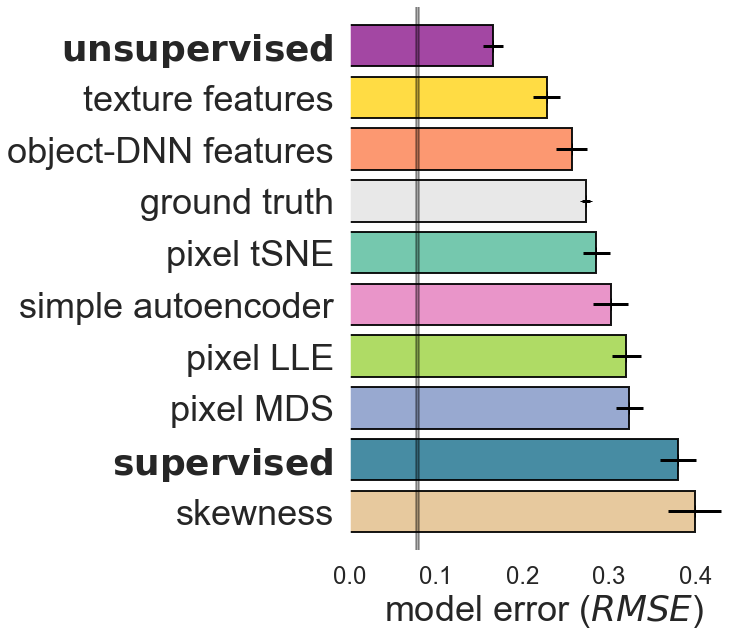

In [365]:
tmp_blu = [0.4, 0.4, 0.8]

plt.figure(figsize=(7,10))

# bars
plt.barh(9, np.mean(pixelVAE_instances_rmse_expt3), edgecolor='k', alpha=0.9, color=pixelVAE_col)
plt.barh(8, np.mean(texture_rmse_expt3), edgecolor='k', alpha=0.9, color=texture_col)
plt.barh(7, np.mean(imagenet_rmse_expt3), edgecolor='k', alpha=0.9, color=imagenet_col)
plt.barh(6, np.mean(groundtruth_rmse_expt3), edgecolor='k', alpha=0.9, color=groundtruth_col)
plt.barh(5, np.mean(tSNE_rmse_expt3), edgecolor='k', alpha=0.9, color=tSNE_col)
plt.barh(4, np.mean(simpleAE_rmse_expt3), edgecolor='k', alpha=0.9, color=simpleAE_col)
plt.barh(3, np.mean(LLE_rmse_expt3), edgecolor='k', alpha=0.9, color=LLE_col)
plt.barh(2, np.mean(MDS_rmse_expt3), edgecolor='k', alpha=0.9, color=MDS_col)
plt.barh(1, np.mean(resnet_instances_rmse_expt3), edgecolor='k', alpha=0.9, color=resnet_col)
plt.barh(0, np.mean(skew_rmse_expt3), edgecolor='k', alpha=0.9, color=skew_col)

# SEM errors
plt.errorbar(np.mean(pixelVAE_instances_rmse_expt3), 9, xerr=np.mean(pixelVAE_instances_rmse_sem_expt3), fmt='k+-')
plt.errorbar(np.mean(texture_rmse_expt3), 8, xerr=np.std(texture_rmse_expt3)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(imagenet_rmse_expt3), 7, xerr=np.std(imagenet_rmse_expt3)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(groundtruth_rmse_expt3), 6, xerr=np.std(groundtruth_rmse_expt3)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(tSNE_rmse_expt3), 5, xerr=np.std(tSNE_rmse_expt3)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(simpleAE_rmse_expt3), 4, xerr=np.std(simpleAE_rmse_expt3)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(LLE_rmse_expt3), 3, xerr=np.std(LLE_rmse_expt3)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(MDS_rmse_expt3), 2, xerr=np.std(MDS_rmse_expt3)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(resnet_instances_rmse_expt3), 1, xerr=np.mean(resnet_instances_rmse_sem_expt3), fmt='k+-')
plt.errorbar(np.mean(skew_rmse_expt3), 0, xerr=np.std(skew_rmse_expt3)/np.sqrt(20), fmt='k+-')

# add noise floor.
plt.fill_between([np.mean(lower_ceiling_rmse_expt3), np.mean(upper_ceiling_rmse_expt3)], -1, 13, alpha=0.3, edgecolor='k', facecolor='k', zorder=20)

plt.yticks(range(10))
ax = plt.gca()
ax.set_yticklabels(['skewness',
                    '$\mathbf{supervised}$',
                    'pixel MDS',
                    'pixel LLE',
                    'simple autoencoder',
                    'pixel tSNE',
                    'ground truth',
                    'object-DNN features',
                    'texture features',
                    '$\mathbf{unsupervised}$'], fontsize=36)
ax.set_facecolor('w')
plt.plot([0,0],[-1,10],'k-', linewidth=2)
plt.xlabel('model error ($RMSE$)', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=36)
plt.ylim([-0.75,9.75])
# plt.xlim([0,0.23])
plt.show()

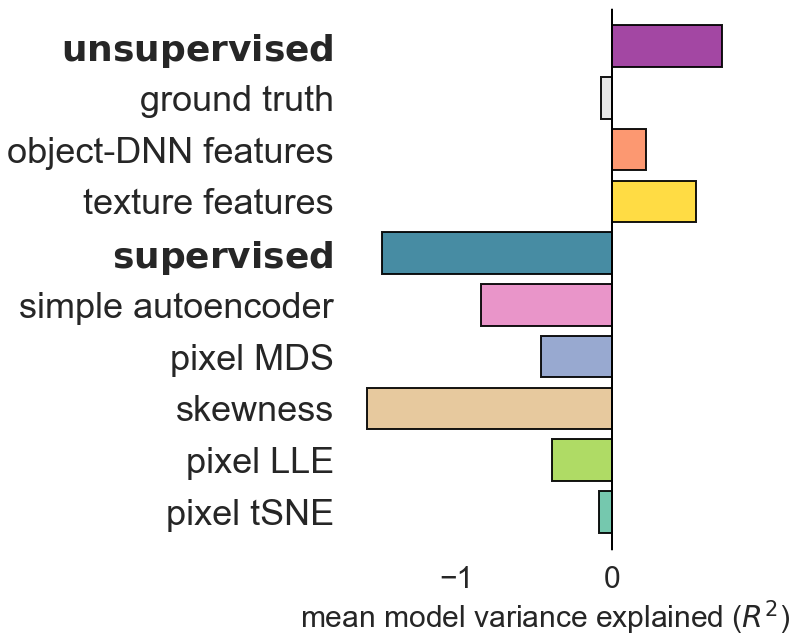

In [367]:
# summary barchart for Figure 4a (right panel)

plt.figure(figsize=(7,10))

# bars - nb. these are manually ordered to display ranked by performance
plt.barh(9, np.mean(pixelVAE_instances_r2agg_expt3), edgecolor='k', alpha=0.9, color=pixelVAE_col)
plt.barh(8, np.mean(groundtruth_r2agg_expt3), edgecolor='k', alpha=0.9, color=groundtruth_col)
plt.barh(7, np.mean(imagenet_r2agg_expt3), edgecolor='k', alpha=0.9, color=imagenet_col)
plt.barh(6, np.mean(texture_r2agg_expt3), edgecolor='k', alpha=0.9, color=texture_col)
plt.barh(5, np.mean(resnet_instances_r2agg_expt3), edgecolor='k', alpha=0.9, color=resnet_col)
plt.barh(4, np.mean(simpleAE_r2agg_expt3), edgecolor='k', alpha=0.9, color=simpleAE_col)
plt.barh(3, np.mean(MDS_r2agg_expt3), edgecolor='k', alpha=0.9, color=MDS_col)
plt.barh(2, np.mean(skew_r2agg_expt3), edgecolor='k', alpha=0.9, color=skew_col)
plt.barh(1, np.mean(LLE_r2agg_expt3), edgecolor='k', alpha=0.9, color=LLE_col)
plt.barh(0, np.mean(tSNE_r2agg_expt3), edgecolor='k', alpha=0.9, color=tSNE_col)

plt.yticks(range(10))
ax = plt.gca()
ax.set_yticklabels(['pixel tSNE',
                    'pixel LLE',
                    'skewness',
                    'pixel MDS',
                    'simple autoencoder',
                    '$\mathbf{supervised}$',
                    'texture features',
                    'object-DNN features',
                    'ground truth',
                    '$\mathbf{unsupervised}$'], fontsize=36)
ax.set_facecolor('w')
plt.plot([0,0],[-1,10],'k-', linewidth=2)
plt.xlabel('mean model variance explained ($R^2$)', fontsize=30)
plt.xticks(fontsize=30)
plt.ylim([-0.75,9.75])
plt.show()


In [374]:
# calculate correlation values and test given in paper
print('PixelVAE r = {}'.format(np.median(pixelVAE_instances_r2agg_expt3)))
print('Resnet r = {}'.format(np.median(resnet_instances_r2agg_expt3)))
print('Texture r = {}\n'.format(np.median(texture_r2agg_expt3)))

print(ttest_1samp([pixelVAE_instances_r2agg_expt3[i]-texture_r2agg_expt3 for i in range(10)], 0))

PixelVAE r = 0.7080290581363148
Resnet r = -1.4470131285456593
Texture r = 0.5380928089864147

Ttest_1sampResult(statistic=10.482442744799796, pvalue=2.4141472777081113e-06)


## Experiment 4 (degrees of gloss-constancy within pairs of images varying shape and lighting)
- Pairwise "which is glossier" 2AFC comparison for 40 pairs, repeated 8 times each.
- Run in same session as 3b, so demographics are as for that group.

In [375]:
expt_path = './analysis_data/psychophysics/expt4/'

data_files = [f for f in os.listdir(expt_path) if f.endswith('.csv')]

In [376]:
# split human response data up according to type of image pair
hdri_bump = np.empty([10, len(data_files)])
hdri_light = np.empty([10, len(data_files)])
lamp_bump = np.empty([10, len(data_files)])
lamp_light = np.empty([10, len(data_files)])

for s in range(len(data_files)):
    this_subj = pd.read_csv(os.path.join(expt_path, data_files[s]))
    # hardcoded split of data according to stimulus type - beware if reusing
    hdri_bump[:,s] = np.asarray(this_subj.sort_values(by='trials_1.thisIndex').groupby("trials_1.thisIndex").mean()["corresponding_image"][0:10])
    hdri_light[:,s] = np.asarray(this_subj.sort_values(by='trials_1.thisIndex').groupby("trials_1.thisIndex").mean()["corresponding_image"][10:20])
    lamp_bump[:,s] = np.asarray(this_subj.sort_values(by='trials_1.thisIndex').groupby("trials_1.thisIndex").mean()["corresponding_image"][20:30])
    lamp_light[:,s] = np.asarray(this_subj.sort_values(by='trials_1.thisIndex').groupby("trials_1.thisIndex").mean()["corresponding_image"][30:40])

# express in terms of deviation from constancy - i.e. signed difference from proportion = 0.5
hb_prop = hdri_bump - 0.5
hl_prop = hdri_light - 0.5
lb_prop = lamp_bump - 0.5
ll_prop = lamp_light - 0.5

all_data_expt4 = np.concatenate([hb_prop,hl_prop,lb_prop,ll_prop])

In [377]:
def load_and_format_expt4(model_file_path):
    '''
    Load model predictions and scale to the range -0.5>0.5
    nb. this scaling retain's model's original zero point.'''
    model = np.squeeze(np.load(model_file_path))
    if len(model.shape) > 1: # if there were multiple model instances, normalise within each and return full array
        tmp_row = []
        tmp_model = []
        for instance in range(model.shape[0]):
            tmp_row = model[instance,:]
            tmp_row = np.array([tmp_row[i+1]-tmp_row[i] for i in range(0, tmp_row.shape[0], 2)])
            tmp_row = 0.5*(tmp_row/abs(tmp_row).max())
            tmp_model.append(tmp_row)
        model = np.array(tmp_model)
    else:
        model = np.array([model[i+1]-model[i] for i in range(0, model.shape[0], 2)])
        model = 0.5*(model/abs(model).max())
    return model

In [378]:
def model_performance_and_noise_ceilings_expt4(all_data, model_predictions, metric='rmse'):
    '''
    Calculate how well model predicts human data,
    and how well each human participant predicts others' data,
    using specified metric.
    '''
    
    model_performance = []
    lower_ceiling = []
    upper_ceiling = []
    
    mean_data = all_data.mean(axis=1)

    for subj in range(all_data.shape[1]):
        tmp_data = np.delete(all_data, subj, axis=1)
        tmp_means = tmp_data.mean(axis=1)

        if metric=='rmse':
            model_performance.append(np.sqrt(mean_squared_error(all_data[:,subj], model_predictions)))
            lower_ceiling.append(np.sqrt(mean_squared_error(all_data[:,subj], tmp_means)))
            upper_ceiling.append(np.sqrt(mean_squared_error(all_data[:,subj], mean_data)))
        elif metric=='corr':
            model_performance.append(pearsonr(all_data[:,subj], model_predictions)[0])
            lower_ceiling.append(pearsonr(all_data[:,subj], tmp_means)[0])
            upper_ceiling.append(pearsonr(all_data[:,subj], mean_data)[0])
        elif metric=='r2':
            model_performance.append(r2_score(all_data[:,subj], model_predictions))
            lower_ceiling.append(r2_score(all_data[:,subj], tmp_means))
            upper_ceiling.append(r2_score(all_data[:,subj], mean_data))
        else: print('This metric not supported. Options: rmse, corr, r2')
    
    return model_performance, lower_ceiling, upper_ceiling

In [379]:
# load and format model predictions
model_path = './analysis_data/model_predicted_gloss/expt4_images/'

# core models
pixelVAE = load_and_format_expt4(os.path.join(model_path,'gloss_vals_all_pixelVAEs_expt4.npy'))
resnet = load_and_format_expt4(os.path.join(model_path,'gloss_vals_all_Resnets_expt4.npy'))
MDS = load_and_format_expt4(os.path.join(model_path,'gloss_vals_pixel-10D-embedding_MDS_expt4.npy'))
tSNE = load_and_format_expt4(os.path.join(model_path,'gloss_vals_pixel-10D-embedding_tSNE_expt4.npy'))
LLE = load_and_format_expt4(os.path.join(model_path,'gloss_vals_pixel-10D-embedding_LLE_expt4.npy'))
texture = load_and_format_expt4(os.path.join(model_path,'gloss_vals_ps_texturefeats_expt4.npy'))
skew = load_and_format_expt4(os.path.join(model_path,'gloss_vals_skewness_expt4.npy'))
imagenet = load_and_format_expt4(os.path.join(model_path,'gloss_vals_imagenetDNN_expt4.npy'))
simpleAE = load_and_format_expt4(os.path.join(model_path,'gloss_vals_simpleAE_expt4.npy'))
groundtruth = np.zeros([40,1]) # dummy groundtruth model = perfect constancy

# PixelVAE variants for Figure 7
contPVAE = load_and_format_expt4(os.path.join(model_path,'gloss_vals_continuous_gloss_trained_pixelVAEs_expt4.npy'))
highvarPVAE = load_and_format_expt4(os.path.join(model_path,'gloss_vals_higher_variance_trained_pixelVAE_expt4.npy'))

regPVAE00 = load_and_format_expt4(os.path.join(model_path,'gloss_vals_contPixelVAE00_expt4.npy'))
regPVAE01 = load_and_format_expt4(os.path.join(model_path,'gloss_vals_contPixelVAE01_expt4.npy'))

# hyperparameter variant PixelVAEs for Supplementary Figure 5
pvae_f80l2 = load_and_format_expt4(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_filters-80_resnets-2_logmixes-12_lr-0.001_decay-1.0_expt4.npy'))
pvae_f48l4 = load_and_format_expt4(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_filters-48_resnets-4_logmixes-12_lr-0.001_decay-1.0_expt4.npy'))
pvae_log4 = load_and_format_expt4(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_filters-64_resnets-3_logmixes-4_lr-0.001_decay-1.0_expt4.npy'))
pvae_log6 = load_and_format_expt4(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_filters-64_resnets-3_logmixes-6_lr-0.001_decay-1.0_expt4.npy'))
pvae_log24 = load_and_format_expt4(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_filters-64_resnets-3_logmixes-24_lr-0.001_decay-1.0_expt4.npy'))
pvae_log30 = load_and_format_expt4(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_filters-64_resnets-3_logmixes-30_lr-0.001_decay-1.0_expt4.npy'))
pvae_lr01 = load_and_format_expt4(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_filters-64_resnets-3_logmixes-12_lr-0.01_decay-1.0_expt4.npy'))
pvae_lr005 = load_and_format_expt4(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_filters-64_resnets-3_logmixes-12_lr-0.005_decay-1.0_expt4.npy'))
pvae_lr0005 = load_and_format_expt4(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_filters-64_resnets-3_logmixes-12_lr-0.0005_decay-1.0_expt4.npy'))
pvae_lr0001 = load_and_format_expt4(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_filters-64_resnets-3_logmixes-12_lr-0.0001_decay-1.0_expt4.npy'))
pvae_d0_25 = load_and_format_expt4(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_filters-64_resnets-3_logmixes-12_lr-0.001_decay-0.25_expt4.npy'))
pvae_d0_50 = load_and_format_expt4(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_filters-64_resnets-3_logmixes-12_lr-0.001_decay-0.5_expt4.npy'))
pvae_d2_00 = load_and_format_expt4(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_filters-64_resnets-3_logmixes-12_lr-0.001_decay-2.0_expt4.npy'))
pvae_d4_00 = load_and_format_expt4(os.path.join(model_path,'hyperparam_pixelvaes/gloss_vals_filters-64_resnets-3_logmixes-12_lr-0.001_decay-4.0_expt4.npy'))

# hyperparameter variant Resnets for Supplementary Figure 5
res_f80l2 = load_and_format_expt4(os.path.join(model_path,'hyperparam_resnets/gloss_vals_filters-80_resnets-2_batchsize-32_lr-0.01_decay-0.1_expt4.npy'))
res_f48l4 = load_and_format_expt4(os.path.join(model_path,'hyperparam_resnets/gloss_vals_filters-48_resnets-4_batchsize-32_lr-0.01_decay-0.1_expt4.npy'))
res_b12 = load_and_format_expt4(os.path.join(model_path,'hyperparam_resnets/gloss_vals_filters-56_resnets-3_batchsize-12_lr-0.001_decay-1.0_expt4.npy'))
res_b22 = load_and_format_expt4(os.path.join(model_path,'hyperparam_resnets/gloss_vals_filters-56_resnets-3_batchsize-22_lr-0.001_decay-1.0_expt4.npy'))
res_b42 = load_and_format_expt4(os.path.join(model_path,'hyperparam_resnets/gloss_vals_filters-56_resnets-3_batchsize-42_lr-0.001_decay-1.0_expt4.npy'))
res_b50 = load_and_format_expt4(os.path.join(model_path,'hyperparam_resnets/gloss_vals_filters-56_resnets-3_batchsize-50_lr-0.001_decay-1.0_expt4.npy'))
res_lr01 = load_and_format_expt4(os.path.join(model_path,'hyperparam_resnets/gloss_vals_filters-56_resnets-3_batchsize-32_lr-0.01_decay-1.0_expt4.npy'))
res_lr005 = load_and_format_expt4(os.path.join(model_path,'hyperparam_resnets/gloss_vals_filters-56_resnets-3_batchsize-32_lr-0.005_decay-1.0_expt4.npy'))
res_lr0005 = load_and_format_expt4(os.path.join(model_path,'hyperparam_resnets/gloss_vals_filters-56_resnets-3_batchsize-32_lr-0.0005_decay-1.0_expt4.npy'))
res_lr0001 = load_and_format_expt4(os.path.join(model_path,'hyperparam_resnets/gloss_vals_filters-56_resnets-3_batchsize-32_lr-0.0001_decay-1.0_expt4.npy'))
res_d0_25 = load_and_format_expt4(os.path.join(model_path,'hyperparam_resnets/gloss_vals_filters-56_resnets-3_batchsize-32_lr-0.001_decay-0.25_expt4.npy'))
res_d0_50 = load_and_format_expt4(os.path.join(model_path,'hyperparam_resnets/gloss_vals_filters-56_resnets-3_batchsize-32_lr-0.001_decay-0.50_expt4.npy'))
res_d2_00 = load_and_format_expt4(os.path.join(model_path,'hyperparam_resnets/gloss_vals_filters-56_resnets-3_batchsize-32_lr-0.001_decay-2.00_expt4.npy'))
res_d4_00 = load_and_format_expt4(os.path.join(model_path,'hyperparam_resnets/gloss_vals_filters-56_resnets-3_batchsize-32_lr-0.001_decay-4.00_expt4.npy'))

# conv layers for Supplementary Figure 4
pvae_conv1 = load_and_format_expt4(os.path.join(model_path,'gloss_vals_pixelvae01_conv1_expt4.npy'))
pvae_conv2 = load_and_format_expt4(os.path.join(model_path,'gloss_vals_pixelvae01_conv2_expt4.npy'))
pvae_conv3 = load_and_format_expt4(os.path.join(model_path,'gloss_vals_pixelvae01_conv3_expt4.npy'))

res_conv1 = load_and_format_expt4(os.path.join(model_path,'gloss_vals_resnet09_conv1_expt4.npy'))
res_conv2 = load_and_format_expt4(os.path.join(model_path,'gloss_vals_resnet09_conv2_expt4.npy'))
res_conv3 = load_and_format_expt4(os.path.join(model_path,'gloss_vals_resnet09_conv3_expt4.npy'))

# continuous regression Resnet for Supplementary Figure 4
res_cont00 = load_and_format_expt4(os.path.join(model_path,'gloss_vals_contResnet00_expt4.npy'))
res_cont01 = load_and_format_expt4(os.path.join(model_path,'gloss_vals_contResnet01_expt4.npy'))
res_cont02 = load_and_format_expt4(os.path.join(model_path,'gloss_vals_contResnet02_expt4.npy'))
res_cont03 = load_and_format_expt4(os.path.join(model_path,'gloss_vals_contResnet03_expt4.npy'))
res_cont04 = load_and_format_expt4(os.path.join(model_path,'gloss_vals_contResnet04_expt4.npy'))


### _Figure 5e: Experiment 4 data vs PixelVAE model predictions scatterplot_

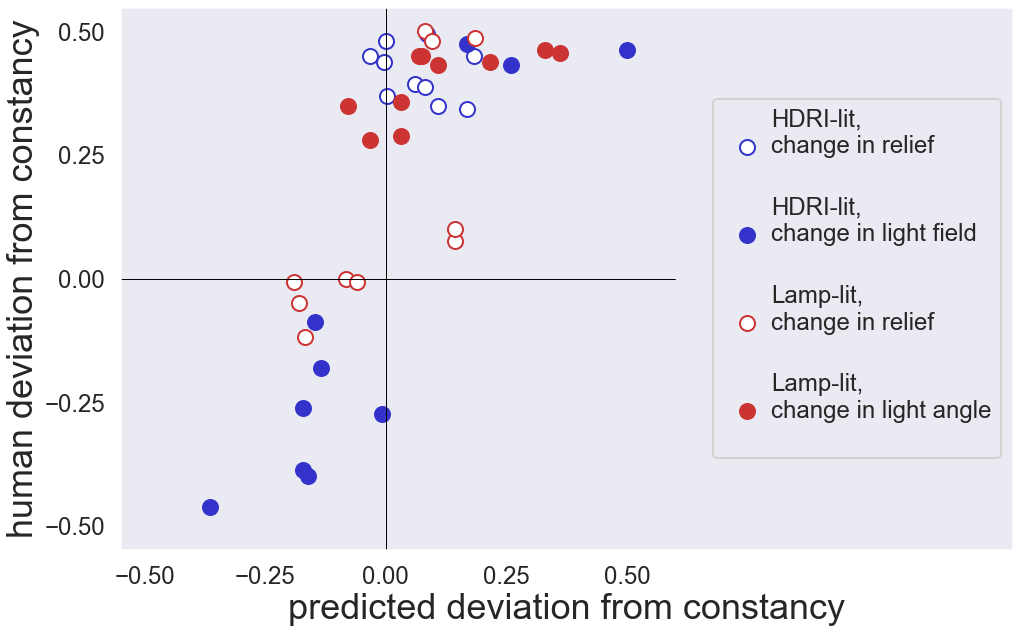

In [452]:
tmp_blu = [0.2, 0.2, 0.8]
tmp_red = [0.8, 0.2, 0.2]

plt.figure(figsize=(16,10))
plt.plot(np.mean(pixelVAE[:,0:10],axis=0), hb_prop.mean(axis=1),'o', markersize=15, markerfacecolor='w', markeredgecolor=tmp_blu, markeredgewidth=2, label='HDRI-lit,\nchange in relief\n')
plt.plot(np.mean(pixelVAE[:,10:20],axis=0), hl_prop.mean(axis=1),'o', markersize=15, markerfacecolor=tmp_blu, markeredgecolor=tmp_blu, markeredgewidth=2, label='HDRI-lit,\nchange in light field\n')
plt.plot(np.mean(pixelVAE[:,20:30],axis=0), lb_prop.mean(axis=1),'o', markersize=15, markerfacecolor='w', markeredgecolor=tmp_red, markeredgewidth=2, label='Lamp-lit,\nchange in relief\n')
plt.plot(np.mean(pixelVAE[:,30:40],axis=0), ll_prop.mean(axis=1),'o', markersize=15, markerfacecolor=tmp_red, markeredgecolor=tmp_red, markeredgewidth=2, label='Lamp-lit,\nchange in light angle\n')
plt.xlabel('predicted deviation from constancy', fontsize=36)
plt.ylabel('human deviation from constancy', fontsize=36)
plt.xticks([-0.50, -0.25, 0, 0.25, 0.50], fontsize=24)
plt.yticks([-0.50, -0.25, 0, 0.25, 0.50], fontsize=24)
plt.plot([-0.6,0.6],[0,0],'k-',linewidth=1)
plt.plot([0,0],[-0.6,0.6],'k-',linewidth=1)
plt.xlim([-0.55, 1.3])
plt.ylim([-0.55, 0.55])
plt.legend(loc='center right', fontsize=24, handletextpad=0)
plt.show()

In [384]:
# logistic fit
import scipy.optimize as opt

def logistic(x, a, b, c, d):
    return a / (1. + np.exp(-c * (x - d))) + b

def line(x, m, s):
    return m*x + s

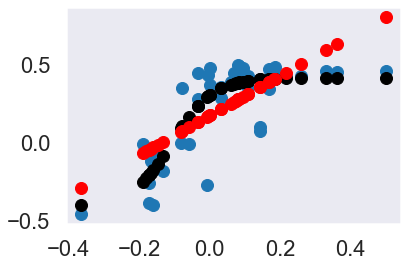

Average logistic gof (across model instances): 0.7434619501789759
Average linear gof (across model instances): 0.5977196421724194


D:\kates\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [423]:
# visualise average and calculate for all training instances
(a_, b_, c_, d_), _ = opt.curve_fit(logistic, np.mean(pixelVAE,axis=0), np.mean(all_data_expt4,axis=1))
(m_, s_), _ = opt.curve_fit(line, np.mean(pixelVAE,axis=0), np.mean(all_data_expt4,axis=1))

y_fit = logistic(np.mean(pixelVAE,axis=0), a_, b_, c_, d_)
yy_fit = line(np.mean(pixelVAE,axis=0), m_, s_)

plt.plot(np.mean(pixelVAE,axis=0), np.mean(all_data_expt4,axis=1), 'o')
plt.plot(np.mean(pixelVAE,axis=0), y_fit, 'ko')
plt.plot(np.mean(pixelVAE,axis=0), yy_fit, 'ro')
plt.show()

pixelVAE_instances_r2agg_logistic_expt4 = []
pixelVAE_instances_r2agg_linear_expt4 = []

for m in range(10):
    (a_, b_, c_, d_), _ = opt.curve_fit(logistic, pixelVAE[m,:], np.mean(all_data_expt4,axis=1))
    y_fit = logistic(pixelVAE[m,:], a_, b_, c_, d_)
    pixelVAE_instances_r2agg_logistic_expt4.append(r2_score(np.mean(all_data_expt4,axis=1), y_fit))
    
    (m_, s_), _ = opt.curve_fit(line, pixelVAE[m,:], np.mean(all_data_expt4,axis=1))
    yy_fit = line(pixelVAE[m,:], m_, s_)
    pixelVAE_instances_r2agg_linear_expt4.append(r2_score(np.mean(all_data_expt4,axis=1), yy_fit))
    

print('Average logistic gof (across model instances): {}'.format(r2_score(np.mean(all_data_expt4,axis=1), y_fit)))
print('Average linear gof (across model instances): {}'.format(r2_score(np.mean(all_data_expt4,axis=1), yy_fit)))


In [418]:
# calculate correlations and R2 for all models with average human data
pixelVAE_instances_ragg_expt4 = [pearsonr(np.mean(all_data_expt4,axis=1), pixelVAE[m,:])[0] for m in range(10)]
resnet_instances_ragg_expt4 = [pearsonr(np.mean(all_data_expt4,axis=1), resnet[m,:])[0] for m in range(10)]

groundtruth_ragg_expt4 = pearsonr(np.mean(all_data_expt4,axis=1), groundtruth)[0]
MDS_ragg_expt4 = pearsonr(np.mean(all_data_expt4,axis=1), MDS)[0]
tSNE_ragg_expt4 = pearsonr(np.mean(all_data_expt4,axis=1), tSNE)[0]
LLE_ragg_expt4 = pearsonr(np.mean(all_data_expt4,axis=1), LLE)[0]
texture_ragg_expt4 = pearsonr(np.mean(all_data_expt4,axis=1), texture)[0]
skew_ragg_expt4 = pearsonr(np.mean(all_data_expt4,axis=1), skew)[0]
imagenet_ragg_expt4 = pearsonr(np.mean(all_data_expt4,axis=1), imagenet)[0]
simpleAE_ragg_expt4 = pearsonr(np.mean(all_data_expt4,axis=1), simpleAE)[0]

# ---

pixelVAE_instances_r2agg_expt4 = [r2_score(np.mean(all_data_expt4,axis=1), pixelVAE[m,:]) for m in range(10)]
resnet_instances_r2agg_expt4 = [r2_score(np.mean(all_data_expt4,axis=1), resnet[m,:]) for m in range(10)]

groundtruth_r2agg_expt4 = r2_score(np.mean(all_data_expt4,axis=1), groundtruth)
MDS_r2agg_expt4 = r2_score(np.mean(all_data_expt4,axis=1), MDS)
tSNE_r2agg_expt4 = r2_score(np.mean(all_data_expt4,axis=1), tSNE)
LLE_r2agg_expt4 = r2_score(np.mean(all_data_expt4,axis=1), LLE)
texture_r2agg_expt4 = r2_score(np.mean(all_data_expt4,axis=1), texture)
skew_r2agg_expt4 = r2_score(np.mean(all_data_expt4,axis=1), skew)
imagenet_r2agg_expt4 = r2_score(np.mean(all_data_expt4,axis=1), imagenet)
simpleAE_r2agg_expt4 = r2_score(np.mean(all_data_expt4,axis=1), simpleAE)

D:\kates\Anaconda3\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [422]:
# correlation values and tests for paper
print('PixelVAE instance average correlation = {}'.format(np.mean(pixelVAE_instances_ragg_expt4)))
print('PixelVAE instance average correlation = {}'.format(imagenet_ragg_expt4))

ttest_1samp([pixelVAE_instances_ragg_expt4[m]-imagenet_ragg_expt4 for m in range(10)], 0)

PixelVAE instance average correlation = 0.6951323377299923
PixelVAE instance average correlation = 0.6387140102365435


Ttest_1sampResult(statistic=4.003078695681566, pvalue=0.0030960167526047928)

**Calculate performances for all other models**

In [425]:
# get performances of ground truth and noise ceilings (measure of inter-subject reliability)
groundtruth_rmse_expt4, lower_ceiling_rmse_expt4, upper_ceiling_rmse_expt4 = model_performance_and_noise_ceilings_expt4(all_data_expt4, groundtruth, metric='rmse')

# core models
pixelVAE_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, np.mean(pixelVAE,axis=0), metric='rmse')
resnet_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, np.mean(resnet,axis=0), metric='rmse')
MDS_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, MDS, metric='rmse')
tSNE_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, tSNE, metric='rmse')
LLE_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, LLE, metric='rmse')
texture_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, texture, metric='rmse')
skew_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, skew, metric='rmse')
imagenet_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, imagenet, metric='rmse')
simpleAE_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, simpleAE, metric='rmse')

# test individual pixelVAE training instances
pixelVAE00_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[0,:], metric='rmse')
pixelVAE01_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[1,:], metric='rmse')
pixelVAE02_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[2,:], metric='rmse')
pixelVAE03_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[3,:], metric='rmse')
pixelVAE04_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[4,:], metric='rmse')
pixelVAE05_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[5,:], metric='rmse')
pixelVAE06_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[6,:], metric='rmse')
pixelVAE07_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[7,:], metric='rmse')
pixelVAE08_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[8,:], metric='rmse')
pixelVAE09_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[9,:], metric='rmse')

# test individual resnet training instances
resnet00_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[0,:], metric='rmse')
resnet01_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[1,:], metric='rmse')
resnet02_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[2,:], metric='rmse')
resnet03_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[3,:], metric='rmse')
resnet04_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[4,:], metric='rmse')
resnet05_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[5,:], metric='rmse')
resnet06_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[6,:], metric='rmse')
resnet07_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[7,:], metric='rmse')
resnet08_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[8,:], metric='rmse')
resnet09_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[9,:], metric='rmse')

# PixelVAE variants for Figure 7
contPVAE00_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, contPVAE[0,:], metric='rmse')
contPVAE01_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, contPVAE[1,:], metric='rmse')
contPVAE02_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, contPVAE[2,:], metric='rmse')
contPVAE03_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, contPVAE[3,:], metric='rmse')
contPVAE04_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, contPVAE[4,:], metric='rmse')

highvarPVAE_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, highvarPVAE, metric='rmse')

regPVAE00_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, regPVAE00, metric='rmse')
regPVAE01_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, regPVAE01, metric='rmse')

# hyperparameter variant PixelVAEs for Supplementary Figure 5
pvae_f80l2_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_f80l2, metric='rmse')
pvae_f48l4_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_f48l4, metric='rmse')
pvae_log4_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_log4, metric='rmse')
pvae_log6_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_log6, metric='rmse')
pvae_log24_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_log24, metric='rmse')
pvae_log30_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_log30, metric='rmse')
pvae_lr01_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_lr01, metric='rmse')
pvae_lr005_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_lr005, metric='rmse')
pvae_lr0005_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_lr0005, metric='rmse')
pvae_lr0001_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_lr0001, metric='rmse')
pvae_d0_25_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_d0_25, metric='rmse')
pvae_d0_50_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_d0_50, metric='rmse')
pvae_d2_00_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_d2_00, metric='rmse')
pvae_d4_00_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_d4_00, metric='rmse')

# hyperparameter variant Resnets for Supplementary Figure 5
res_f80l2_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_f80l2, metric='rmse')
res_f48l4_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_f48l4, metric='rmse')
res_b12_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_b12, metric='rmse')
res_b22_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_b22, metric='rmse')
res_b42_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_b42, metric='rmse')
res_b50_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_b50, metric='rmse')
res_lr01_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_lr01, metric='rmse')
res_lr005_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_lr005, metric='rmse')
res_lr0005_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_lr0005, metric='rmse')
res_lr0001_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_lr0001, metric='rmse')
res_d0_25_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_d0_25, metric='rmse')
res_d0_50_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_d0_50, metric='rmse')
res_d2_00_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_d2_00, metric='rmse')
res_d4_00_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_d4_00, metric='rmse')

# conv layers for Supplementary Figure 4
pvae_c1_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_conv1, metric='rmse')
pvae_c2_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_conv2, metric='rmse')
pvae_c3_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_conv3, metric='rmse')

res_c1_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_conv1, metric='rmse')
res_c2_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_conv2, metric='rmse')
res_c3_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_conv3, metric='rmse')

# continuous regression Resnet for Supplementary Figure 4
res_cont00_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_cont00, metric='rmse')
res_cont01_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_cont01, metric='rmse')
res_cont02_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_cont02, metric='rmse')
res_cont03_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_cont03, metric='rmse')
res_cont04_rmse_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_cont04, metric='rmse')


In [426]:
# also for correlations...
# get performances of ground truth and noise ceilings (measure of inter-subject reliability)
groundtruth_corr_expt4, lower_ceiling_corr_expt4, upper_ceiling_corr_expt4 = model_performance_and_noise_ceilings_expt4(all_data_expt4, groundtruth, metric='corr')

# core models
pixelVAE_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, np.mean(pixelVAE,axis=0), metric='corr')
resnet_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, np.mean(resnet,axis=0), metric='corr')
MDS_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, MDS, metric='corr')
tSNE_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, tSNE, metric='corr')
LLE_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, LLE, metric='corr')
texture_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, texture, metric='corr')
skew_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, skew, metric='corr')
imagenet_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, imagenet, metric='corr')
simpleAE_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, simpleAE, metric='corr')

# test individual pixelVAE training instances
pixelVAE00_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[0,:], metric='corr')
pixelVAE01_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[1,:], metric='corr')
pixelVAE02_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[2,:], metric='corr')
pixelVAE03_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[3,:], metric='corr')
pixelVAE04_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[4,:], metric='corr')
pixelVAE05_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[5,:], metric='corr')
pixelVAE06_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[6,:], metric='corr')
pixelVAE07_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[7,:], metric='corr')
pixelVAE08_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[8,:], metric='corr')
pixelVAE09_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pixelVAE[9,:], metric='corr')

# test individual resnet training instances
resnet00_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[0,:], metric='corr')
resnet01_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[1,:], metric='corr')
resnet02_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[2,:], metric='corr')
resnet03_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[3,:], metric='corr')
resnet04_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[4,:], metric='corr')
resnet05_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[5,:], metric='corr')
resnet06_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[6,:], metric='corr')
resnet07_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[7,:], metric='corr')
resnet08_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[8,:], metric='corr')
resnet09_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, resnet[9,:], metric='corr')

# PixelVAE variants for Figure 7
contPVAE00_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, contPVAE[0,:], metric='corr')
contPVAE01_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, contPVAE[1,:], metric='corr')
contPVAE02_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, contPVAE[2,:], metric='corr')
contPVAE03_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, contPVAE[3,:], metric='corr')
contPVAE04_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, contPVAE[4,:], metric='corr')

highvarPVAE_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, highvarPVAE, metric='corr')

regPVAE00_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, regPVAE00, metric='corr')
regPVAE01_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, regPVAE01, metric='corr')

# hyperparameter variant PixelVAEs for Supplementary Figure 5
pvae_f80l2_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_f80l2, metric='corr')
pvae_f48l4_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_f48l4, metric='corr')
pvae_log4_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_log4, metric='corr')
pvae_log6_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_log6, metric='corr')
pvae_log24_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_log24, metric='corr')
pvae_log30_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_log30, metric='corr')
pvae_lr01_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_lr01, metric='corr')
pvae_lr005_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_lr005, metric='corr')
pvae_lr0005_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_lr0005, metric='corr')
pvae_lr0001_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_lr0001, metric='corr')
pvae_d0_25_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_d0_25, metric='corr')
pvae_d0_50_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_d0_50, metric='corr')
pvae_d2_00_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_d2_00, metric='corr')
pvae_d4_00_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_d4_00, metric='corr')

# hyperparameter variant Resnets for Supplementary Figure 5
res_f80l2_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_f80l2, metric='corr')
res_f48l4_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_f48l4, metric='corr')
res_b12_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_b12, metric='corr')
res_b22_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_b22, metric='corr')
res_b42_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_b42, metric='corr')
res_b50_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_b50, metric='corr')
res_lr01_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_lr01, metric='corr')
res_lr005_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_lr005, metric='corr')
res_lr0005_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_lr0005, metric='corr')
res_lr0001_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_lr0001, metric='corr')
res_d0_25_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_d0_25, metric='corr')
res_d0_50_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_d0_50, metric='corr')
res_d2_00_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_d2_00, metric='corr')
res_d4_00_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_d4_00, metric='corr')

# conv layers for Supplementary Figure 4
pvae_c1_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_conv1, metric='corr')
pvae_c2_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_conv2, metric='corr')
pvae_c3_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, pvae_conv3, metric='corr')

res_c1_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_conv1, metric='corr')
res_c2_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_conv2, metric='corr')
res_c3_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_conv3, metric='corr')

# continuous regression Resnet for Supplementary Figure 4
res_cont00_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_cont00, metric='corr')
res_cont01_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_cont01, metric='corr')
res_cont02_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_cont02, metric='corr')
res_cont03_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_cont03, metric='corr')
res_cont04_corr_expt4, _, _ = model_performance_and_noise_ceilings_expt4(all_data_expt4, res_cont04, metric='corr')


D:\kates\Anaconda3\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [427]:
resnet_instances_rmse_expt4 = np.mean([resnet00_rmse_expt4,
                                       resnet01_rmse_expt4,
                                       resnet02_rmse_expt4,
                                       resnet03_rmse_expt4,
                                       resnet04_rmse_expt4,
                                       resnet05_rmse_expt4,
                                       resnet06_rmse_expt4,
                                       resnet07_rmse_expt4,
                                       resnet08_rmse_expt4,
                                       resnet09_rmse_expt4], axis=0)

pixelVAE_instances_rmse_expt4 = np.mean([pixelVAE00_rmse_expt4,
                                         pixelVAE01_rmse_expt4,
                                         pixelVAE02_rmse_expt4,
                                         pixelVAE03_rmse_expt4,
                                         pixelVAE04_rmse_expt4,
                                         pixelVAE05_rmse_expt4,
                                         pixelVAE06_rmse_expt4,
                                         pixelVAE07_rmse_expt4,
                                         pixelVAE08_rmse_expt4,
                                         pixelVAE09_rmse_expt4], axis=0)

contPVAE_instances_rmse_expt4 = np.mean([contPVAE00_rmse_expt4,
                                         contPVAE01_rmse_expt4,
                                         contPVAE02_rmse_expt4,
                                         contPVAE03_rmse_expt4,
                                         contPVAE04_rmse_expt4], axis=0)
# also variances
resnet_instances_rmse_sem_expt4 = np.mean([np.std(resnet00_rmse_expt4)/np.sqrt(20),
                                       np.std(resnet01_rmse_expt4)/np.sqrt(20),
                                       np.std(resnet02_rmse_expt4)/np.sqrt(20),
                                       np.std(resnet03_rmse_expt4)/np.sqrt(20),
                                       np.std(resnet04_rmse_expt4)/np.sqrt(20),
                                       np.std(resnet05_rmse_expt4)/np.sqrt(20),
                                       np.std(resnet06_rmse_expt4)/np.sqrt(20),
                                       np.std(resnet07_rmse_expt4)/np.sqrt(20),
                                       np.std(resnet08_rmse_expt4)/np.sqrt(20),
                                       np.std(resnet09_rmse_expt4)/np.sqrt(20)], axis=0)

pixelVAE_instances_rmse_sem_expt4 = np.mean([np.std(pixelVAE00_rmse_expt4)/np.sqrt(20),
                                         np.std(pixelVAE01_rmse_expt4)/np.sqrt(20),
                                         np.std(pixelVAE02_rmse_expt4)/np.sqrt(20),
                                         np.std(pixelVAE03_rmse_expt4)/np.sqrt(20),
                                         np.std(pixelVAE04_rmse_expt4)/np.sqrt(20),
                                         np.std(pixelVAE05_rmse_expt4)/np.sqrt(20),
                                         np.std(pixelVAE06_rmse_expt4)/np.sqrt(20),
                                         np.std(pixelVAE07_rmse_expt4)/np.sqrt(20),
                                         np.std(pixelVAE08_rmse_expt4)/np.sqrt(20),
                                         np.std(pixelVAE09_rmse_expt4)/np.sqrt(20)], axis=0)

contPVAE_instances_rmse_sem_expt4 = np.mean([np.std(contPVAE00_rmse_expt4)/np.sqrt(20),
                                         np.std(contPVAE01_rmse_expt4)/np.sqrt(20),
                                         np.std(contPVAE02_rmse_expt4)/np.sqrt(20),
                                         np.std(contPVAE03_rmse_expt4)/np.sqrt(20),
                                         np.std(contPVAE04_rmse_expt4)/np.sqrt(20)], axis=0)

In [428]:
resnet_instances_corr_expt4 = np.mean([resnet00_corr_expt4,
                                       resnet01_corr_expt4,
                                       resnet02_corr_expt4,
                                       resnet03_corr_expt4,
                                       resnet04_corr_expt4,
                                       resnet05_corr_expt4,
                                       resnet06_corr_expt4,
                                       resnet07_corr_expt4,
                                       resnet08_corr_expt4,
                                       resnet09_corr_expt4], axis=0)

pixelVAE_instances_corr_expt4 = np.mean([pixelVAE00_corr_expt4,
                                         pixelVAE01_corr_expt4,
                                         pixelVAE02_corr_expt4,
                                         pixelVAE03_corr_expt4,
                                         pixelVAE04_corr_expt4,
                                         pixelVAE05_corr_expt4,
                                         pixelVAE06_corr_expt4,
                                         pixelVAE07_corr_expt4,
                                         pixelVAE08_corr_expt4,
                                         pixelVAE09_corr_expt4], axis=0)

contPVAE_instances_corr_expt4 = np.mean([contPVAE00_corr_expt4,
                                         contPVAE01_corr_expt4,
                                         contPVAE02_corr_expt4,
                                         contPVAE03_corr_expt4,
                                         contPVAE04_corr_expt4], axis=0)
# also variances
resnet_instances_corr_sem_expt4 = np.mean([np.std(resnet00_corr_expt4)/np.sqrt(20),
                                       np.std(resnet01_corr_expt4)/np.sqrt(20),
                                       np.std(resnet02_corr_expt4)/np.sqrt(20),
                                       np.std(resnet03_corr_expt4)/np.sqrt(20),
                                       np.std(resnet04_corr_expt4)/np.sqrt(20),
                                       np.std(resnet05_corr_expt4)/np.sqrt(20),
                                       np.std(resnet06_corr_expt4)/np.sqrt(20),
                                       np.std(resnet07_corr_expt4)/np.sqrt(20),
                                       np.std(resnet08_corr_expt4)/np.sqrt(20),
                                       np.std(resnet09_corr_expt4)/np.sqrt(20)], axis=0)

pixelVAE_instances_corr_sem_expt4 = np.mean([np.std(pixelVAE00_corr_expt4)/np.sqrt(20),
                                         np.std(pixelVAE01_corr_expt4)/np.sqrt(20),
                                         np.std(pixelVAE02_corr_expt4)/np.sqrt(20),
                                         np.std(pixelVAE03_corr_expt4)/np.sqrt(20),
                                         np.std(pixelVAE04_corr_expt4)/np.sqrt(20),
                                         np.std(pixelVAE05_corr_expt4)/np.sqrt(20),
                                         np.std(pixelVAE06_corr_expt4)/np.sqrt(20),
                                         np.std(pixelVAE07_corr_expt4)/np.sqrt(20),
                                         np.std(pixelVAE08_corr_expt4)/np.sqrt(20),
                                         np.std(pixelVAE09_corr_expt4)/np.sqrt(20)], axis=0)

contPVAE_instances_corr_sem_expt4 = np.mean([np.std(contPVAE00_corr_expt4)/np.sqrt(20),
                                         np.std(contPVAE01_corr_expt4)/np.sqrt(20),
                                         np.std(contPVAE02_corr_expt4)/np.sqrt(20),
                                         np.std(contPVAE03_corr_expt4)/np.sqrt(20),
                                         np.std(contPVAE04_corr_expt4)/np.sqrt(20)], axis=0)

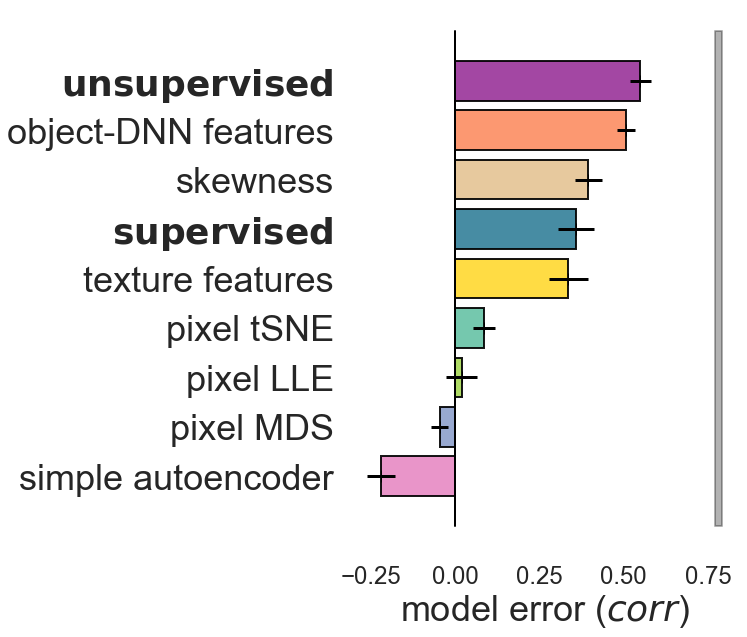

In [429]:
# or for correlations
tmp_blu = [0.4, 0.4, 0.8]

plt.figure(figsize=(7,10))

# bars
plt.barh(8, np.mean(pixelVAE_instances_corr_expt4), edgecolor='k', alpha=0.9, color=pixelVAE_col)
plt.barh(7, np.mean(imagenet_corr_expt4), edgecolor='k', alpha=0.9, color=imagenet_col)
plt.barh(6, np.mean(skew_corr_expt4), edgecolor='k', alpha=0.9, color=skew_col)
plt.barh(5, np.mean(resnet_instances_corr_expt4), edgecolor='k', alpha=0.9, color=resnet_col)
plt.barh(4, np.mean(texture_corr_expt4), edgecolor='k', alpha=0.9, color=texture_col)
plt.barh(3, np.mean(tSNE_corr_expt4), edgecolor='k', alpha=0.9, color=tSNE_col)
plt.barh(2, np.mean(LLE_corr_expt4), edgecolor='k', alpha=0.9, color=LLE_col)
plt.barh(1, np.mean(MDS_corr_expt4), edgecolor='k', alpha=0.9, color=MDS_col)
plt.barh(0, np.mean(simpleAE_corr_expt4), edgecolor='k', alpha=0.9, color=simpleAE_col)

# SEM errors
plt.errorbar(np.mean(pixelVAE_instances_corr_expt4), 8, xerr=np.std(pixelVAE_instances_corr_expt4)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(imagenet_corr_expt4), 7, xerr=np.std(imagenet_corr_expt4)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(skew_corr_expt4), 6, xerr=np.std(skew_corr_expt4)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(resnet_instances_corr_expt4), 5, xerr=np.std(resnet_instances_corr_expt4)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(texture_corr_expt4), 4, xerr=np.std(texture_corr_expt4)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(tSNE_corr_expt4), 3, xerr=np.std(tSNE_corr_expt4)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(LLE_corr_expt4), 2, xerr=np.std(LLE_corr_expt4)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(MDS_corr_expt4), 1, xerr=np.std(MDS_corr_expt4)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(simpleAE_corr_expt4), 0, xerr=np.std(simpleAE_corr_expt4)/np.sqrt(20), fmt='k+-')

# add noise floor.
plt.fill_between([np.mean(lower_ceiling_corr_expt4), np.mean(upper_ceiling_corr_expt4)], -1, 9, alpha=0.3, edgecolor='k', facecolor='k', zorder=20)

plt.yticks(range(9))
ax = plt.gca()
ax.set_yticklabels(['simple autoencoder',
                    'pixel MDS',
                    'pixel LLE',
                    'pixel tSNE',
                    'texture features',
                    '$\mathbf{supervised}$',
                    'skewness',
                    'object-DNN features',
                    '$\mathbf{unsupervised}$'], fontsize=30)
ax.set_facecolor('w')
plt.plot([0,0],[-1,9],'k-', linewidth=2)
plt.xlabel('model error ($corr$)', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=36)
# plt.ylim([-0.75,9.75])
# plt.xlim([0,0.23])
plt.show()

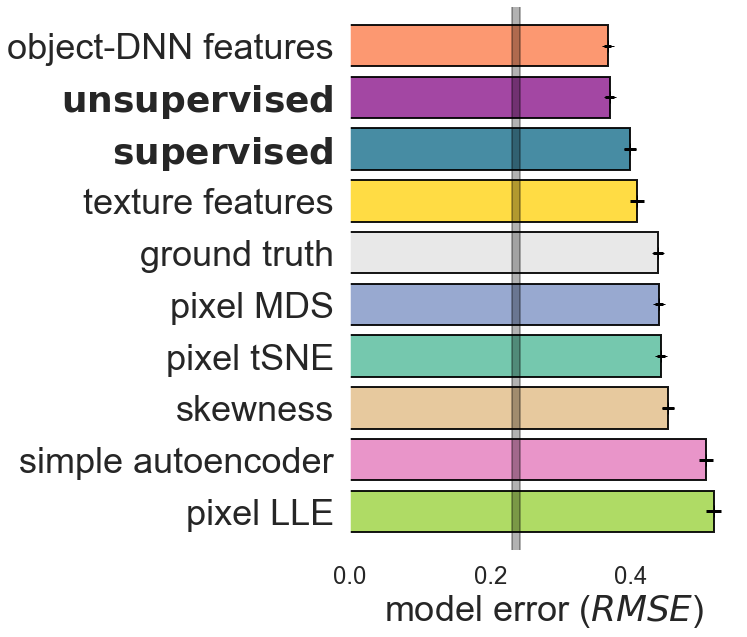

In [430]:
tmp_blu = [0.4, 0.4, 0.8]

plt.figure(figsize=(7,10))

# bars
plt.barh(9, np.mean(imagenet_rmse_expt4), edgecolor='k', alpha=0.9, color=imagenet_col)
plt.barh(8, np.mean(pixelVAE_instances_rmse_expt4), edgecolor='k', alpha=0.9, color=pixelVAE_col)
plt.barh(7, np.mean(resnet_instances_rmse_expt4), edgecolor='k', alpha=0.9, color=resnet_col)
plt.barh(6, np.mean(texture_rmse_expt4), edgecolor='k', alpha=0.9, color=texture_col)
plt.barh(5, np.mean(groundtruth_rmse_expt4), edgecolor='k', alpha=0.9, color=groundtruth_col)
plt.barh(4, np.mean(MDS_rmse_expt4), edgecolor='k', alpha=0.9, color=MDS_col)
plt.barh(3, np.mean(tSNE_rmse_expt4), edgecolor='k', alpha=0.9, color=tSNE_col)
plt.barh(2, np.mean(skew_rmse_expt4), edgecolor='k', alpha=0.9, color=skew_col)
plt.barh(1, np.mean(simpleAE_rmse_expt4), edgecolor='k', alpha=0.9, color=simpleAE_col)
plt.barh(0, np.mean(LLE_rmse_expt4), edgecolor='k', alpha=0.9, color=LLE_col)

# SEM errors
plt.errorbar(np.mean(imagenet_rmse_expt4), 9, xerr=np.std(imagenet_rmse_expt4)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(pixelVAE_instances_rmse_expt4), 8, xerr=np.mean(pixelVAE_instances_rmse_sem_expt4), fmt='k+-')
plt.errorbar(np.mean(resnet_instances_rmse_expt4), 7, xerr=np.mean(resnet_instances_rmse_sem_expt4), fmt='k+-')
plt.errorbar(np.mean(texture_rmse_expt4), 6, xerr=np.std(texture_rmse_expt4)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(groundtruth_rmse_expt4), 5, xerr=np.std(groundtruth_rmse_expt4)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(MDS_rmse_expt4), 4, xerr=np.std(MDS_rmse_expt4)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(tSNE_rmse_expt4), 3, xerr=np.std(tSNE_rmse_expt4)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(skew_rmse_expt4), 2, xerr=np.std(skew_rmse_expt4)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(simpleAE_rmse_expt4), 1, xerr=np.std(simpleAE_rmse_expt4)/np.sqrt(20), fmt='k+-')
plt.errorbar(np.mean(LLE_rmse_expt4), 0, xerr=np.std(LLE_rmse_expt4)/np.sqrt(20), fmt='k+-')

# add noise floor.
plt.fill_between([np.mean(lower_ceiling_rmse_expt4), np.mean(upper_ceiling_rmse_expt4)], -1, 13, alpha=0.3, edgecolor='k', facecolor='k', zorder=20)

plt.yticks(range(10))
ax = plt.gca()
ax.set_yticklabels(['pixel LLE',
                    'simple autoencoder',
                    'skewness',
                    'pixel tSNE',
                    'pixel MDS',
                    'ground truth',
                    'texture features',
                    '$\mathbf{supervised}$',
                    '$\mathbf{unsupervised}$',
                    'object-DNN features'], fontsize=30)
ax.set_facecolor('w')
plt.plot([0,0],[-1,10],'k-', linewidth=2)
plt.xlabel('model error ($RMSE$)', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=36)
plt.ylim([-0.75,9.75])
# plt.xlim([0,0.23])
plt.show()

## Summaries over all experiments
Notes:
1. These exclude Experiment 2, which used images generated by PixelVAE networks, for which there is no ground-truth gloss, so not all models make meaningful predictions.
2. Some of these include additional models not shown so far, specifically the variants of PixelVAE networks trained on two alternative training datasets (continuously-varying gloss, and higher-variance shape and lighting, respectively).

In [431]:
# TODO: import accuracy file

# accuracies expressed as % errors 
pixelVAE_acc = 100-99.30
resnet_acc = 100-99.40
skew_acc = 100-87.87
texture_acc = 100-86.15
groundtruth_acc = 100-100.0
MDS_acc = 100-51.42
tSNE_acc = 100-57.29
LLE_acc = 100-63.69
simpleAE_acc = 100-76.86
imagenet_acc = 100-99.64

# dimensionalities
pixelVAE_dim = 10
resnet_dim = 10
skew_dim = 1
texture_dim = 1350
groundtruth_dim = 1
MDS_dim = 10
tSNE_dim = 10
LLE_dim = 10
simpleAE_dim = 4096
imagenet_dim = 1000

In [432]:
# get average performances for all models over the three key expts
pixelVAE_instances_rmse_avg = np.mean([pixelVAE_instances_rmse_expt1,pixelVAE_instances_rmse_expt3,pixelVAE_instances_rmse_expt4])
resnet_instances_rmse_avg = np.mean([resnet_instances_rmse_expt1,resnet_instances_rmse_expt3,resnet_instances_rmse_expt4])
texture_rmse_avg = np.mean([texture_rmse_expt1,texture_rmse_expt3,texture_rmse_expt4])
imagenet_rmse_avg = np.mean([imagenet_rmse_expt1,imagenet_rmse_expt3,imagenet_rmse_expt4])
groundtruth_rmse_avg = np.mean([groundtruth_rmse_expt1,groundtruth_rmse_expt3,groundtruth_rmse_expt4])
tSNE_rmse_avg = np.mean([tSNE_rmse_expt1,tSNE_rmse_expt3,tSNE_rmse_expt4])
MDS_rmse_avg = np.mean([MDS_rmse_expt1,MDS_rmse_expt3,MDS_rmse_expt4])
LLE_rmse_avg = np.mean([LLE_rmse_expt1,LLE_rmse_expt3,LLE_rmse_expt4])
skew_rmse_avg = np.mean([skew_rmse_expt1,skew_rmse_expt3,skew_rmse_expt4])
simpleAE_rmse_avg = np.mean([simpleAE_rmse_expt1,simpleAE_rmse_expt3,simpleAE_rmse_expt4])

### _Figure 6a: Summary scatterplot of model performance vs ground-truth gloss classification accuracy_

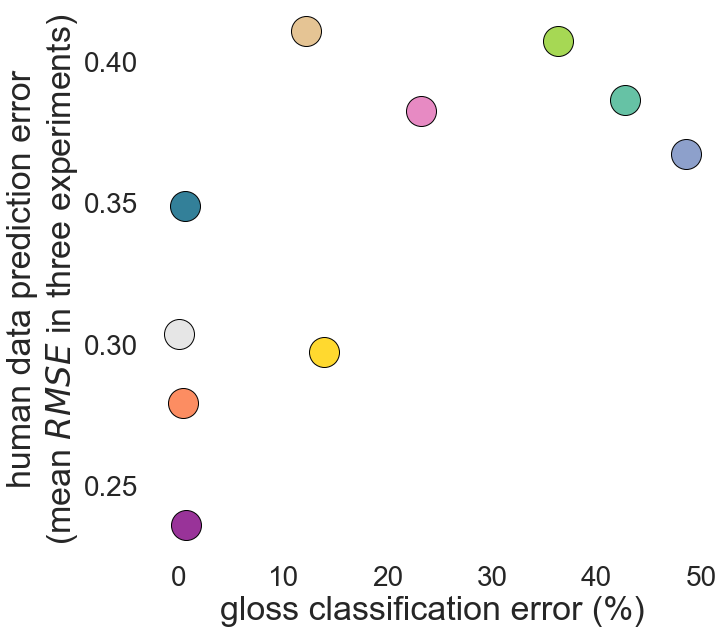

In [442]:
plt.figure(figsize=(10,10))
plt.plot(pixelVAE_acc, pixelVAE_instances_rmse_avg, 'o', markersize=30, label='$\mathbf{unsupervised}$', markerfacecolor=pixelVAE_col, markeredgecolor='k')
plt.plot(texture_acc, texture_rmse_avg, 'o', markersize=30, label='texture features', markerfacecolor=texture_col, markeredgecolor='k')
plt.plot(imagenet_acc, imagenet_rmse_avg, 'o', markersize=30, label='imagenet-trained\nfeatures', markerfacecolor=imagenet_col, markeredgecolor='k')
plt.plot(groundtruth_acc, groundtruth_rmse_avg, 'o', markersize=30, label='ground truth', markerfacecolor=groundtruth_col, markeredgecolor='k')
plt.plot(resnet_acc, resnet_instances_rmse_avg, 'o', markersize=30, label='supervised', markerfacecolor=resnet_col, markeredgecolor='k')
plt.plot(simpleAE_acc, simpleAE_rmse_avg, 'o', markersize=30, label='vanilla AE (4096)', markerfacecolor=simpleAE_col, markeredgecolor='k')
plt.plot(skew_acc, skew_rmse_avg, 'o', markersize=30, label='skewness', markerfacecolor=skew_col, markeredgecolor='k')
plt.plot(MDS_acc, MDS_rmse_avg, 'o', markersize=30, label='pixel MDS', markerfacecolor=MDS_col, markeredgecolor='k')
plt.plot(tSNE_acc, tSNE_rmse_avg, 'o', markersize=30, label='pixel tSNE', markerfacecolor=tSNE_col, markeredgecolor='k')
plt.plot(LLE_acc, LLE_rmse_avg, 'o', markersize=30, label='pixel LLE', markerfacecolor=LLE_col, markeredgecolor='k')

ax = plt.gca()
ax.set_facecolor([0.5,0.5,0.5,0.0])

plt.xlabel('gloss classification error (%)', fontsize=34)
plt.ylabel('human data prediction error\n(mean $RMSE$ in three experiments)', fontsize=34)
plt.xticks(fontsize=28)
plt.yticks([0.25, 0.30, 0.35, 0.40],fontsize=28)
# plt.ylim([0,0.45])
# plt.legend(fontsize=22, frameon=False, markerscale=0.5)
plt.show()


### _Figure 6b: Summary scatterplot of model performance vs model dimensionality_

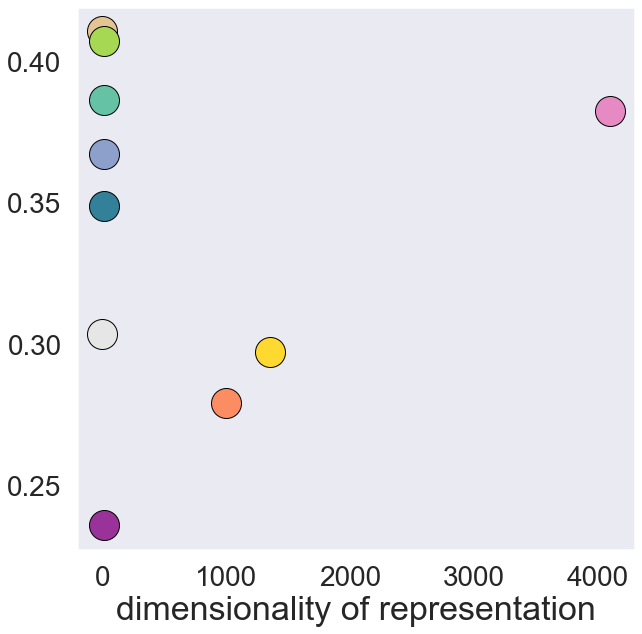

In [443]:
plt.figure(figsize=(10,10))
plt.plot(pixelVAE_dim, pixelVAE_instances_rmse_avg, 'o', markersize=30, label='$\mathbf{unsupervised}$', markerfacecolor=pixelVAE_col, markeredgecolor='k')
plt.plot(texture_dim, texture_rmse_avg, 'o', markersize=30, label='texture features', markerfacecolor=texture_col, markeredgecolor='k')
plt.plot(imagenet_dim, imagenet_rmse_avg, 'o', markersize=30, label='imagenet-trained\nfeatures', markerfacecolor=imagenet_col, markeredgecolor='k')
plt.plot(groundtruth_dim, groundtruth_rmse_avg, 'o', markersize=30, label='ground truth', markerfacecolor=groundtruth_col, markeredgecolor='k')
plt.plot(resnet_dim, resnet_instances_rmse_avg, 'o', markersize=30, label='supervised', markerfacecolor=resnet_col, markeredgecolor='k')
plt.plot(simpleAE_dim, simpleAE_rmse_avg, 'o', markersize=30, label='vanilla AE (4096)', markerfacecolor=simpleAE_col, markeredgecolor='k')
plt.plot(skew_dim, skew_rmse_avg, 'o', markersize=30, label='skewness', markerfacecolor=skew_col, markeredgecolor='k')
plt.plot(MDS_dim, MDS_rmse_avg, 'o', markersize=30, label='pixel MDS', markerfacecolor=MDS_col, markeredgecolor='k')
plt.plot(tSNE_dim, tSNE_rmse_avg, 'o', markersize=30, label='pixel tSNE', markerfacecolor=tSNE_col, markeredgecolor='k')
plt.plot(LLE_dim, LLE_rmse_avg, 'o', markersize=30, label='pixel LLE', markerfacecolor=LLE_col, markeredgecolor='k')

plt.xlabel('dimensionality of representation', fontsize=34)
# plt.ylabel('human data prediction error\n(mean $RMSE$ across three experiments)', fontsize=34)
plt.xticks(fontsize=28)
plt.yticks([0.25, 0.30, 0.35, 0.40],fontsize=28)
# plt.legend(fontsize=22, frameon=False, markerscale=0.5)
plt.show()


### _Figure 7b: Representational similarity analysis of gloss prediction patterns across all models_

### _Figure 7c: Barplot of performance for PixelVAE variants_

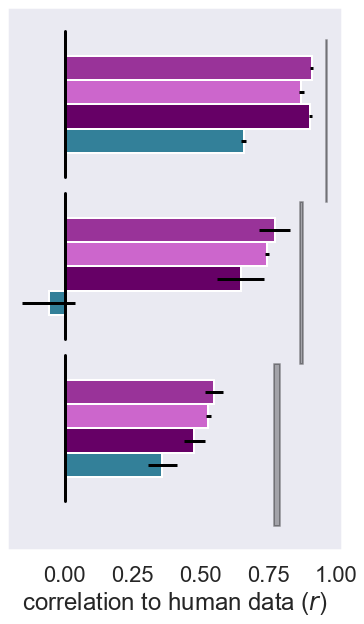

In [449]:
# Expressed as Correlation

width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(6,10))
rects4 = ax.barh([2+1.5*width,1+1.5*width,0+1.5*width],
                 [np.mean(pixelVAE_instances_corr_expt1), np.mean(pixelVAE_instances_corr_expt3), np.mean(pixelVAE_instances_corr_expt4)],
                 width,
                 xerr=[pixelVAE_instances_corr_sem_expt1, pixelVAE_instances_corr_sem_expt3, pixelVAE_instances_corr_sem_expt4],
                 label='$\mathbf{PixelVAE}$\n(original)',
                 color=pixelVAE_col)

# Trained on 2-D continuous "glossfeats" dataset
rects3 = ax.barh([2+width/2,1+width/2,0+width/2],
                 [np.mean(contPVAE_instances_corr_expt1), np.mean(contPVAE_instances_corr_expt3), np.mean(contPVAE_instances_corr_expt4)],
                 width,
                 xerr=[contPVAE_instances_corr_sem_expt1, contPVAE_instances_corr_sem_expt1, contPVAE_instances_corr_sem_expt1],
                 label='$\mathbf{PixelVAE}$\n(continuous gloss)',
                 color=[i+0.2 for i in pixelVAE_col])

rects2 = ax.barh([2-width/2, 1-width/2, 0-width/2],
                 [np.mean(highvarPVAE_corr_expt1), np.mean(highvarPVAE_corr_expt3), np.mean(highvarPVAE_corr_expt4)],
                 width,
                 xerr=[np.std(highvarPVAE_corr_expt1)/np.sqrt(20), np.std(highvarPVAE_corr_expt3)/np.sqrt(20), np.std(highvarPVAE_corr_expt4)/np.sqrt(20)],
                 label='$\mathbf{PixelVAE}$\n(higher variation)',
                 color=[i-0.2 for i in pixelVAE_col])

rects1 = ax.barh([2-1.5*width, 1-1.5*width, 0-1.5*width],
                 [np.mean(resnet_instances_corr_expt1), np.mean(resnet_instances_corr_expt3), np.mean(resnet_instances_corr_expt4)],
                 width,
                 xerr=[resnet_instances_corr_sem_expt1, resnet_instances_corr_sem_expt3, resnet_instances_corr_sem_expt4],
                 label='supervised (original)',
                 color=resnet_col)


# noise ceilings and "y axis"
plt.fill_between([np.mean(lower_ceiling_corr_expt1), np.mean(upper_ceiling_corr_expt1)], 1.4, 2.4, alpha=0.3, edgecolor='k', facecolor='k', zorder=20)
plt.plot([0,0],[1.55, 2.45],'k')
plt.fill_between([np.mean(lower_ceiling_corr_expt3), np.mean(upper_ceiling_corr_expt3)], 0.4, 1.4, alpha=0.3, edgecolor='k', facecolor='k', zorder=20)
plt.plot([0,0],[0.55, 1.45],'k')
plt.fill_between([np.mean(lower_ceiling_corr_expt4), np.mean(upper_ceiling_corr_expt4)], -0.6, 0.4, alpha=0.3, edgecolor='k', facecolor='k', zorder=20)
plt.plot([0,0],[-0.45, 0.45],'k')

plt.xlabel('correlation to human data ($r$)')
plt.yticks([0,1,2])
# plt.xticks([0,0.1,0.2])
ax.set_yticklabels(['', '', ''], fontsize=30)
# plt.legend(frameon=False, fontsize=18, loc='lower right')
plt.show()

In [485]:
# t-tests against supervised models
print(ttest_rel(pixelVAE_instances_corr_expt1, resnet_instances_corr_expt1))
print(ttest_rel(contPVAE_instances_corr_expt1, resnet_instances_corr_expt1))
print(ttest_rel(highvarPVAE_corr_expt1, resnet_instances_corr_expt1))

print(ttest_rel(pixelVAE_instances_corr_expt3, resnet_instances_corr_expt3))
print(ttest_rel(contPVAE_instances_corr_expt3, resnet_instances_corr_expt3))
print(ttest_rel(highvarPVAE_corr_expt3, resnet_instances_corr_expt3))

print(ttest_rel(pixelVAE_instances_corr_expt4, resnet_instances_corr_expt4))
print(ttest_rel(contPVAE_instances_corr_expt4, resnet_instances_corr_expt4))
print(ttest_rel(highvarPVAE_corr_expt4, resnet_instances_corr_expt4))

Ttest_relResult(statistic=31.082290111899383, pvalue=9.348333505351621e-18)
Ttest_relResult(statistic=17.515463493650007, pvalue=3.49831860512287e-13)
Ttest_relResult(statistic=20.63209159303207, pvalue=1.8075578321785916e-14)
Ttest_relResult(statistic=7.407938550877146, pvalue=5.149779841237117e-07)
Ttest_relResult(statistic=7.16000652166438, pvalue=8.35652395212512e-07)
Ttest_relResult(statistic=4.819984904174646, pvalue=0.00011899663200715783)
Ttest_relResult(statistic=7.098091104130687, pvalue=9.44258786680326e-07)
Ttest_relResult(statistic=5.4031246629954754, pvalue=3.257033848604829e-05)
Ttest_relResult(statistic=4.0138282040356605, pvalue=0.0007423689448228988)


In [509]:
# t-tests against texture model
print(ttest_rel(pixelVAE_instances_corr_expt1, texture_corr_expt1))
print(ttest_rel(contPVAE_instances_corr_expt1, texture_corr_expt1))
print(ttest_rel(highvarPVAE_corr_expt1, texture_corr_expt1))

print(ttest_rel(pixelVAE_instances_corr_expt3, texture_corr_expt3))
print(ttest_rel(contPVAE_instances_corr_expt3, texture_corr_expt3))
print(ttest_rel(highvarPVAE_corr_expt3, texture_corr_expt3))

print(ttest_rel(pixelVAE_instances_corr_expt4, texture_corr_expt4))
print(ttest_rel(contPVAE_instances_corr_expt4, texture_corr_expt4))
print(ttest_rel(highvarPVAE_corr_expt4, texture_corr_expt4))

Ttest_relResult(statistic=5.35548770667725, pvalue=3.616134380001807e-05)
Ttest_relResult(statistic=1.206683715548213, pvalue=0.24236388907186923)
Ttest_relResult(statistic=5.845402089961515, pvalue=1.248555392679486e-05)
Ttest_relResult(statistic=3.455876503162269, pvalue=0.0026474349206162704)
Ttest_relResult(statistic=2.7045348347355076, pvalue=0.014051117276739189)
Ttest_relResult(statistic=0.7326397690711381, pvalue=0.4727204747360967)
Ttest_relResult(statistic=4.87254175503739, pvalue=0.0001057480206886743)
Ttest_relResult(statistic=4.117468728822115, pvalue=0.0005859053944441869)
Ttest_relResult(statistic=3.7975363637619433, pvalue=0.001216594237476995)


In [62]:
# # Alternative plot: show all training instances individually

# fig, ax = plt.subplots(figsize=(10,8))

# offset = 0.2

# # original PixelVAEs
# plt.plot(1-2*offset, np.mean(pixelVAE00_corr_expt1), 'o', color=pixelVAE_col)
# plt.plot(1-2*offset, np.mean(pixelVAE01_corr_expt1), 'o', color=pixelVAE_col)
# plt.plot(1-2*offset, np.mean(pixelVAE02_corr_expt1), 'o', color=pixelVAE_col)
# plt.plot(1-2*offset, np.mean(pixelVAE03_corr_expt1), 'o', color=pixelVAE_col)
# plt.plot(1-2*offset, np.mean(pixelVAE04_corr_expt1), 'o', color=pixelVAE_col)
# plt.plot(1-2*offset, np.mean(pixelVAE05_corr_expt1), 'o', color=pixelVAE_col)
# plt.plot(1-2*offset, np.mean(pixelVAE06_corr_expt1), 'o', color=pixelVAE_col)
# plt.plot(1-2*offset, np.mean(pixelVAE07_corr_expt1), 'o', color=pixelVAE_col)
# plt.plot(1-2*offset, np.mean(pixelVAE08_corr_expt1), 'o', color=pixelVAE_col)
# plt.plot(1-2*offset, np.mean(pixelVAE09_corr_expt1), 'o', color=pixelVAE_col)

# # glossfeat10k-trained pixelVAEs
# plt.plot(1-offset, np.mean(contPVAE00_corr_expt1), 'o', color=pixelVAE_col)
# plt.plot(1-offset, np.mean(contPVAE01_corr_expt1), 'o', color=pixelVAE_col)
# plt.plot(1-offset, np.mean(contPVAE02_corr_expt1), 'o', color=pixelVAE_col)
# plt.plot(1-offset, np.mean(contPVAE03_corr_expt1), 'o', color=pixelVAE_col)
# plt.plot(1-offset, np.mean(contPVAE04_corr_expt1), 'o', color=pixelVAE_col)

# # # 1D continuous gloss trained PixelVAE
# # plt.plot(1-offset, np.mean(regPVAE_corr_expt1), 'o', color='k')

# # higher-variance-trained pixelVAE
# plt.plot(1, np.mean(highvarPVAE_corr_expt1), 'o', color=pixelVAE_col)

# # original Resnets
# plt.plot(1+offset, np.mean(resnet00_corr_expt1), 'o', color=resnet_col)
# plt.plot(1+offset, np.mean(resnet01_corr_expt1), 'o', color=resnet_col)
# plt.plot(1+offset, np.mean(resnet02_corr_expt1), 'o', color=resnet_col)
# plt.plot(1+offset, np.mean(resnet03_corr_expt1), 'o', color=resnet_col)
# plt.plot(1+offset, np.mean(resnet04_corr_expt1), 'o', color=resnet_col)
# plt.plot(1+offset, np.mean(resnet05_corr_expt1), 'o', color=resnet_col)
# plt.plot(1+offset, np.mean(resnet06_corr_expt1), 'o', color=resnet_col)
# plt.plot(1+offset, np.mean(resnet07_corr_expt1), 'o', color=resnet_col)
# plt.plot(1+offset, np.mean(resnet08_corr_expt1), 'o', color=resnet_col)
# plt.plot(1+offset, np.mean(resnet09_corr_expt1), 'o', color=resnet_col)

# # continuous1D_10k regression-trained Resnet
# plt.plot(1+2*offset, np.mean(res_cont_corr_expt1), 'o', color=resnet_col)

# # ---

# # original PixelVAEs
# plt.plot(2-2*offset, np.mean(pixelVAE00_corr_expt3), 'o', color=pixelVAE_col)
# plt.plot(2-2*offset, np.mean(pixelVAE01_corr_expt3), 'o', color=pixelVAE_col)
# plt.plot(2-2*offset, np.mean(pixelVAE02_corr_expt3), 'o', color=pixelVAE_col)
# plt.plot(2-2*offset, np.mean(pixelVAE03_corr_expt3), 'o', color=pixelVAE_col)
# plt.plot(2-2*offset, np.mean(pixelVAE04_corr_expt3), 'o', color=pixelVAE_col)
# plt.plot(2-2*offset, np.mean(pixelVAE05_corr_expt3), 'o', color=pixelVAE_col)
# plt.plot(2-2*offset, np.mean(pixelVAE06_corr_expt3), 'o', color=pixelVAE_col)
# plt.plot(2-2*offset, np.mean(pixelVAE07_corr_expt3), 'o', color=pixelVAE_col)
# plt.plot(2-2*offset, np.mean(pixelVAE08_corr_expt3), 'o', color=pixelVAE_col)
# plt.plot(2-2*offset, np.mean(pixelVAE09_corr_expt3), 'o', color=pixelVAE_col)

# # glossfeat10k-trained pixelVAEs
# plt.plot(2-offset, np.mean(contPVAE00_corr_expt3), 'o', color=pixelVAE_col)
# plt.plot(2-offset, np.mean(contPVAE01_corr_expt3), 'o', color=pixelVAE_col)
# plt.plot(2-offset, np.mean(contPVAE02_corr_expt3), 'o', color=pixelVAE_col)
# plt.plot(2-offset, np.mean(contPVAE03_corr_expt3), 'o', color=pixelVAE_col)
# plt.plot(2-offset, np.mean(contPVAE04_corr_expt3), 'o', color=pixelVAE_col)

# # # 1D continuous gloss trained PixelVAE
# # plt.plot(2-offset, np.mean(regPVAE_corr_expt3), 'o', color='k')

# # higher-variance-trained pixelVAE
# plt.plot(2, np.mean(highvarPVAE_corr_expt3), 'o', color=pixelVAE_col)

# # original Resnets
# plt.plot(2+offset, np.mean(resnet00_corr_expt3), 'o', color=resnet_col)
# plt.plot(2+offset, np.mean(resnet01_corr_expt3), 'o', color=resnet_col)
# plt.plot(2+offset, np.mean(resnet02_corr_expt3), 'o', color=resnet_col)
# plt.plot(2+offset, np.mean(resnet03_corr_expt3), 'o', color=resnet_col)
# plt.plot(2+offset, np.mean(resnet04_corr_expt3), 'o', color=resnet_col)
# plt.plot(2+offset, np.mean(resnet05_corr_expt3), 'o', color=resnet_col)
# plt.plot(2+offset, np.mean(resnet06_corr_expt3), 'o', color=resnet_col)
# plt.plot(2+offset, np.mean(resnet07_corr_expt3), 'o', color=resnet_col)
# plt.plot(2+offset, np.mean(resnet08_corr_expt3), 'o', color=resnet_col)
# plt.plot(2+offset, np.mean(resnet09_corr_expt3), 'o', color=resnet_col)

# # continuous1D_10k regression-trained Resnet
# plt.plot(2+2*offset, np.mean(res_cont_corr_expt3), 'o', color=resnet_col)

# # ---

# # original PixelVAEs
# plt.plot(3-2*offset, np.mean(pixelVAE00_corr_expt4), 'o', color=pixelVAE_col)
# plt.plot(3-2*offset, np.mean(pixelVAE01_corr_expt4), 'o', color=pixelVAE_col)
# plt.plot(3-2*offset, np.mean(pixelVAE02_corr_expt4), 'o', color=pixelVAE_col)
# plt.plot(3-2*offset, np.mean(pixelVAE03_corr_expt4), 'o', color=pixelVAE_col)
# plt.plot(3-2*offset, np.mean(pixelVAE04_corr_expt4), 'o', color=pixelVAE_col)
# plt.plot(3-2*offset, np.mean(pixelVAE05_corr_expt4), 'o', color=pixelVAE_col)
# plt.plot(3-2*offset, np.mean(pixelVAE06_corr_expt4), 'o', color=pixelVAE_col)
# plt.plot(3-2*offset, np.mean(pixelVAE07_corr_expt4), 'o', color=pixelVAE_col)
# plt.plot(3-2*offset, np.mean(pixelVAE08_corr_expt4), 'o', color=pixelVAE_col)
# plt.plot(3-2*offset, np.mean(pixelVAE09_corr_expt4), 'o', color=pixelVAE_col)

# # glossfeat10k-trained pixelVAEs
# plt.plot(3-offset, np.mean(contPVAE00_corr_expt4), 'o', color=pixelVAE_col)
# plt.plot(3-offset, np.mean(contPVAE01_corr_expt4), 'o', color=pixelVAE_col)
# plt.plot(3-offset, np.mean(contPVAE02_corr_expt4), 'o', color=pixelVAE_col)
# plt.plot(3-offset, np.mean(contPVAE03_corr_expt4), 'o', color=pixelVAE_col)
# plt.plot(3-offset, np.mean(contPVAE04_corr_expt4), 'o', color=pixelVAE_col)

# # # 1D continuous gloss trained PixelVAE
# # plt.plot(3-offset, np.mean(regPVAE_corr_expt4), 'o', color='k')

# # higher-variance-trained pixelVAE
# plt.plot(3, np.mean(highvarPVAE_corr_expt4), 'o', color=pixelVAE_col)

# # original Resnets
# plt.plot(3+offset, np.mean(resnet00_corr_expt4), 'o', color=resnet_col)
# plt.plot(3+offset, np.mean(resnet01_corr_expt4), 'o', color=resnet_col)
# plt.plot(3+offset, np.mean(resnet02_corr_expt4), 'o', color=resnet_col)
# plt.plot(3+offset, np.mean(resnet03_corr_expt4), 'o', color=resnet_col)
# plt.plot(3+offset, np.mean(resnet04_corr_expt4), 'o', color=resnet_col)
# plt.plot(3+offset, np.mean(resnet05_corr_expt4), 'o', color=resnet_col)
# plt.plot(3+offset, np.mean(resnet06_corr_expt4), 'o', color=resnet_col)
# plt.plot(3+offset, np.mean(resnet07_corr_expt4), 'o', color=resnet_col)
# plt.plot(3+offset, np.mean(resnet08_corr_expt4), 'o', color=resnet_col)
# plt.plot(3+offset, np.mean(resnet09_corr_expt4), 'o', color=resnet_col)

# # continuous1D_10k regression-trained Resnet
# plt.plot(3+2*offset, np.mean(res_cont_corr_expt4), 'o', color=resnet_col)

# # ---

# # noise ceilings
# plt.fill_between([0.6,1.2], np.mean(lower_ceiling_corr_expt1), np.mean(upper_ceiling_corr_expt1), alpha=0.3, edgecolor='k', facecolor='k', zorder=20)
# plt.fill_between([1.6,2.2], np.mean(lower_ceiling_corr_expt3), np.mean(upper_ceiling_corr_expt3), alpha=0.3, edgecolor='k', facecolor='k', zorder=20)
# plt.fill_between([2.6,3.2], np.mean(lower_ceiling_corr_expt4), np.mean(upper_ceiling_corr_expt4), alpha=0.3, edgecolor='k', facecolor='k', zorder=20)

# plt.ylabel('model correlation ($Pearson$)')
# # plt.yticks([0,1,2])
# plt.xticks([1,2,3])
# ax.set_xticklabels(['Expt1', 'Expt3', 'Expt4'], fontsize=30)
# # plt.legend(frameon=False, fontsize=18, loc='lower right')
# plt.show()

## Convolutional layer analysis

In [63]:
# objective gloss classification accuracies (for the specific model instances
# from [remote]_decode_MKA_cues_from_convlayers_1.2 notebook)

pvae_acc_latent = 0.993186372745
pvae_acc_c1 = 0.818436873747
pvae_acc_c2 = 0.97755511022
pvae_acc_c3 = 0.991983967936

res_acc_latent = 0.990303030303
res_acc_c1 = 0.993131313131
res_acc_c2 = 0.986666666667
res_acc_c3 = 0.988686868687

In [64]:
# average performances over the three psychophysics experiments 
pvae_c1_rmse_avg = np.mean([pvae_c1_rmse_expt1,pvae_c1_rmse_expt3,pvae_c1_rmse_expt4])
pvae_c2_rmse_avg = np.mean([pvae_c2_rmse_expt1,pvae_c2_rmse_expt3,pvae_c2_rmse_expt4])
pvae_c3_rmse_avg = np.mean([pvae_c3_rmse_expt1,pvae_c3_rmse_expt3,pvae_c3_rmse_expt4])

res_c1_rmse_avg = np.mean([res_c1_rmse_expt1,res_c1_rmse_expt3,res_c1_rmse_expt4])
res_c2_rmse_avg = np.mean([res_c2_rmse_expt1,res_c2_rmse_expt3,res_c2_rmse_expt4])
res_c3_rmse_avg = np.mean([res_c3_rmse_expt1,res_c3_rmse_expt3,res_c3_rmse_expt4])

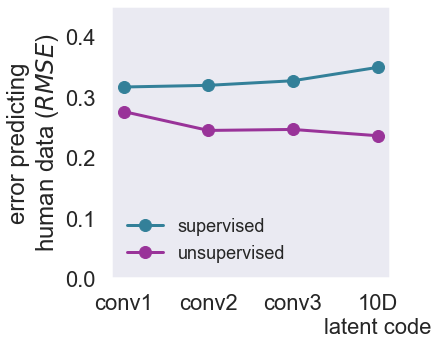

In [65]:
plt.figure(figsize=(5,5))
plt.plot([1,2,3,4],[res_c1_rmse_avg, res_c2_rmse_avg, res_c3_rmse_avg, resnet_instances_rmse_avg], 'o-', color=resnet_col, label='supervised')
plt.plot([1,2,3,4],[pvae_c1_rmse_avg, pvae_c2_rmse_avg, pvae_c3_rmse_avg, pixelVAE_instances_rmse_avg], 'o-', color=pixelVAE_col, label='unsupervised')

plt.ylabel('error predicting\nhuman data ($RMSE$)', fontsize=24)
plt.xticks([1,2,3,4])
ax = plt.gca()
ax.set_xticklabels(['conv1','conv2','conv3','10D\nlatent code'])
plt.legend(fontsize=18, frameon=False, loc='lower left')
plt.ylim([0,0.45])
plt.show()

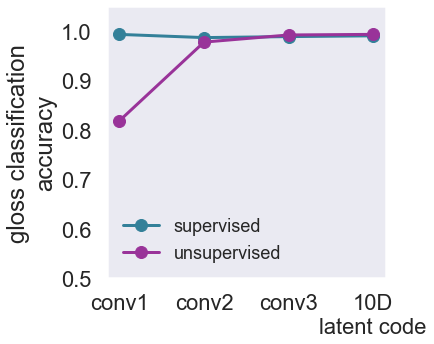

In [66]:
plt.figure(figsize=(5,5))
plt.plot([1,2,3,4],[res_acc_c1, res_acc_c2, res_acc_c3, res_acc_latent], 'o-', color=resnet_col, label='supervised')
plt.plot([1,2,3,4],[pvae_acc_c1, pvae_acc_c2, pvae_acc_c3, pvae_acc_latent], 'o-', color=pixelVAE_col, label='unsupervised')

plt.ylabel('gloss classification\naccuracy', fontsize=24)
plt.xticks([1,2,3,4])
ax = plt.gca()
ax.set_xticklabels(['conv1','conv2','conv3','10D\nlatent code'])
plt.legend(fontsize=18, frameon=False, loc='lower left')
plt.ylim([0.5,1.05])
plt.show()

## Continuous regression supervised net analysis

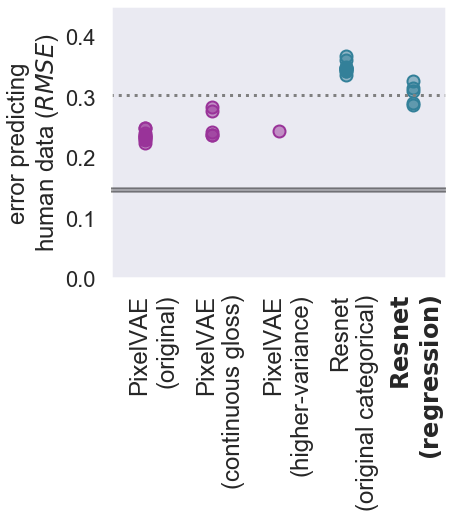

In [465]:
# Or averaged across experiments:
lower_ceiling_rmse_avg = np.mean([lower_ceiling_rmse_expt1,lower_ceiling_rmse_expt3,lower_ceiling_rmse_expt4])
upper_ceiling_rmse_avg = np.mean([upper_ceiling_rmse_expt1,upper_ceiling_rmse_expt3,upper_ceiling_rmse_expt4])

pixelVAE00_rmse_avg = np.mean([pixelVAE00_rmse_expt1,pixelVAE00_rmse_expt3,pixelVAE00_rmse_expt4])
pixelVAE01_rmse_avg = np.mean([pixelVAE01_rmse_expt1,pixelVAE01_rmse_expt3,pixelVAE01_rmse_expt4])
pixelVAE02_rmse_avg = np.mean([pixelVAE02_rmse_expt1,pixelVAE02_rmse_expt3,pixelVAE02_rmse_expt4])
pixelVAE03_rmse_avg = np.mean([pixelVAE03_rmse_expt1,pixelVAE03_rmse_expt3,pixelVAE03_rmse_expt4])
pixelVAE04_rmse_avg = np.mean([pixelVAE04_rmse_expt1,pixelVAE04_rmse_expt3,pixelVAE04_rmse_expt4])
pixelVAE05_rmse_avg = np.mean([pixelVAE05_rmse_expt1,pixelVAE05_rmse_expt3,pixelVAE05_rmse_expt4])
pixelVAE06_rmse_avg = np.mean([pixelVAE06_rmse_expt1,pixelVAE06_rmse_expt3,pixelVAE06_rmse_expt4])
pixelVAE07_rmse_avg = np.mean([pixelVAE07_rmse_expt1,pixelVAE07_rmse_expt3,pixelVAE07_rmse_expt4])
pixelVAE08_rmse_avg = np.mean([pixelVAE08_rmse_expt1,pixelVAE08_rmse_expt3,pixelVAE08_rmse_expt4])
pixelVAE09_rmse_avg = np.mean([pixelVAE09_rmse_expt1,pixelVAE09_rmse_expt3,pixelVAE09_rmse_expt4])

contPVAE00_rmse_avg = np.mean([contPVAE00_rmse_expt1,contPVAE00_rmse_expt3,contPVAE00_rmse_expt4])
contPVAE01_rmse_avg = np.mean([contPVAE01_rmse_expt1,contPVAE01_rmse_expt3,contPVAE01_rmse_expt4])
contPVAE02_rmse_avg = np.mean([contPVAE02_rmse_expt1,contPVAE02_rmse_expt3,contPVAE02_rmse_expt4])
contPVAE03_rmse_avg = np.mean([contPVAE03_rmse_expt1,contPVAE03_rmse_expt3,contPVAE03_rmse_expt4])
contPVAE04_rmse_avg = np.mean([contPVAE04_rmse_expt1,contPVAE04_rmse_expt3,contPVAE04_rmse_expt4])

regPVAE00_rmse_avg = np.mean([regPVAE00_rmse_expt1,regPVAE00_rmse_expt3,regPVAE00_rmse_expt4])
regPVAE01_rmse_avg = np.mean([regPVAE01_rmse_expt1,regPVAE01_rmse_expt3,regPVAE01_rmse_expt4])

highvarPVAE_rmse_avg = np.mean([highvarPVAE_rmse_expt1,highvarPVAE_rmse_expt3,highvarPVAE_rmse_expt4])

resnet00_rmse_avg = np.mean([resnet00_rmse_expt1,resnet00_rmse_expt3,resnet00_rmse_expt4])
resnet01_rmse_avg = np.mean([resnet01_rmse_expt1,resnet01_rmse_expt3,resnet01_rmse_expt4])
resnet02_rmse_avg = np.mean([resnet02_rmse_expt1,resnet02_rmse_expt3,resnet02_rmse_expt4])
resnet03_rmse_avg = np.mean([resnet03_rmse_expt1,resnet03_rmse_expt3,resnet03_rmse_expt4])
resnet04_rmse_avg = np.mean([resnet04_rmse_expt1,resnet04_rmse_expt3,resnet04_rmse_expt4])
resnet05_rmse_avg = np.mean([resnet05_rmse_expt1,resnet05_rmse_expt3,resnet05_rmse_expt4])
resnet06_rmse_avg = np.mean([resnet06_rmse_expt1,resnet06_rmse_expt3,resnet06_rmse_expt4])
resnet07_rmse_avg = np.mean([resnet07_rmse_expt1,resnet07_rmse_expt3,resnet07_rmse_expt4])
resnet08_rmse_avg = np.mean([resnet08_rmse_expt1,resnet08_rmse_expt3,resnet08_rmse_expt4])
resnet09_rmse_avg = np.mean([resnet09_rmse_expt1,resnet09_rmse_expt3,resnet09_rmse_expt4])

res_cont00_rmse_avg = np.mean([res_cont00_rmse_expt1,res_cont00_rmse_expt3,res_cont00_rmse_expt4])
res_cont01_rmse_avg = np.mean([res_cont01_rmse_expt1,res_cont01_rmse_expt3,res_cont01_rmse_expt4])
res_cont02_rmse_avg = np.mean([res_cont02_rmse_expt1,res_cont02_rmse_expt3,res_cont02_rmse_expt4])
res_cont03_rmse_avg = np.mean([res_cont03_rmse_expt1,res_cont03_rmse_expt3,res_cont03_rmse_expt4])
res_cont04_rmse_avg = np.mean([res_cont04_rmse_expt1,res_cont04_rmse_expt3,res_cont04_rmse_expt4])

groundtruth_rmse_avg = np.mean([groundtruth_rmse_expt1,groundtruth_rmse_expt3,groundtruth_rmse_expt4])

# plotting:

fig, ax = plt.subplots(figsize=(6,5))

offset = 0.2

# original PixelVAEs
plt.plot(1-2*offset, np.mean(pixelVAE00_rmse_avg), 'o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)
plt.plot(1-2*offset, np.mean(pixelVAE01_rmse_avg), 'o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)
plt.plot(1-2*offset, np.mean(pixelVAE02_rmse_avg), 'o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)
plt.plot(1-2*offset, np.mean(pixelVAE03_rmse_avg), 'o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)
plt.plot(1-2*offset, np.mean(pixelVAE04_rmse_avg), 'o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)
plt.plot(1-2*offset, np.mean(pixelVAE05_rmse_avg), 'o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)
plt.plot(1-2*offset, np.mean(pixelVAE06_rmse_avg), 'o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)
plt.plot(1-2*offset, np.mean(pixelVAE07_rmse_avg), 'o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)
plt.plot(1-2*offset, np.mean(pixelVAE08_rmse_avg), 'o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)
plt.plot(1-2*offset, np.mean(pixelVAE09_rmse_avg), 'o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)

# glossfeat10k-trained pixelVAEs
plt.plot(1-offset, np.mean(contPVAE00_rmse_avg), 'o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)
plt.plot(1-offset, np.mean(contPVAE01_rmse_avg), 'o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)
plt.plot(1-offset, np.mean(contPVAE02_rmse_avg), 'o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)
plt.plot(1-offset, np.mean(contPVAE03_rmse_avg), 'o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)
plt.plot(1-offset, np.mean(contPVAE04_rmse_avg), 'o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)

# # 1D gloss trained PixelVAE
# plt.plot(1-offset, np.mean(regPVAE00_rmse_avg), 'o', color='k')
# plt.plot(1-offset, np.mean(regPVAE01_rmse_avg), 'o', color='k')

# higher-variance-trained pixelVAE
plt.plot(1, np.mean(highvarPVAE_rmse_avg), 'o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)

# original Resnets
plt.plot(1+offset, np.mean(resnet00_rmse_avg), 'o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.plot(1+offset, np.mean(resnet01_rmse_avg), 'o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.plot(1+offset, np.mean(resnet02_rmse_avg), 'o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.plot(1+offset, np.mean(resnet03_rmse_avg), 'o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.plot(1+offset, np.mean(resnet04_rmse_avg), 'o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.plot(1+offset, np.mean(resnet05_rmse_avg), 'o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.plot(1+offset, np.mean(resnet06_rmse_avg), 'o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.plot(1+offset, np.mean(resnet07_rmse_avg), 'o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.plot(1+offset, np.mean(resnet08_rmse_avg), 'o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.plot(1+offset, np.mean(resnet09_rmse_avg), 'o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)

# continuous1D_10k regression-trained Resnets
plt.plot(1+2*offset, np.mean(res_cont00_rmse_avg), 'o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.plot(1+2*offset, np.mean(res_cont01_rmse_avg), 'o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.plot(1+2*offset, np.mean(res_cont02_rmse_avg), 'o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.plot(1+2*offset, np.mean(res_cont03_rmse_avg), 'o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.plot(1+2*offset, np.mean(res_cont04_rmse_avg), 'o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)


# ground truth
plt.plot([0,2], [np.mean(groundtruth_rmse_avg),np.mean(groundtruth_rmse_avg)], ':', color=[0.5,0.5,0.5])

# noise ceilings
plt.fill_between([0,2], np.mean(lower_ceiling_rmse_avg), np.mean(upper_ceiling_rmse_avg), alpha=0.3, edgecolor='k', facecolor='k', zorder=20)

plt.ylabel('error predicting\nhuman data ($RMSE$)', fontsize=24)
# plt.yticks([0,1,2])
plt.xticks([1-2*offset+0.1, 1-offset+0.1, 1+0.1, 1+offset+0.1, 1+2*offset+0.1])
plt.ylim([0,0.45])
plt.xlim([1-2.5*offset, 1+2.5*offset])
ax.set_xticklabels(['PixelVAE\n(original)', 'PixelVAE\n(continuous gloss)', 'PixelVAE\n(higher-variance)', 'Resnet\n(original categorical)', '$\mathbf{Resnet}$\n$\mathbf{(regression)}$'], fontsize=24, rotation=90, ha='right')
# plt.legend(frameon=False, fontsize=18, loc='lower right')
plt.show()

In [475]:
# statistically compare continuous-resnets to groundtruth and unsupervised models
all_res_cont = [res_cont00_rmse_avg, res_cont01_rmse_avg, res_cont02_rmse_avg, res_cont03_rmse_avg, res_cont04_rmse_avg]
all_pvae_cont = [contPVAE00_rmse_avg, contPVAE01_rmse_avg, contPVAE02_rmse_avg, contPVAE03_rmse_avg, contPVAE04_rmse_avg]
all_pvae_orig = [contPVAE00_rmse_avg, contPVAE01_rmse_avg, contPVAE02_rmse_avg, contPVAE03_rmse_avg, contPVAE04_rmse_avg]


print(ttest_1samp([all_res_cont[m]-groundtruth_rmse_avg for m in range(5)], 0))
print(ttest_1samp([all_pvae_cont[m]-groundtruth_rmse_avg for m in range(5)], 0))
print(ttest_ind(all_res_cont, all_pvae_cont, equal_var=False))


Ttest_1sampResult(statistic=0.23783954918323524, pvalue=0.823691779937764)
Ttest_1sampResult(statistic=-4.777857502057884, pvalue=0.008789312918093267)
Ttest_indResult(statistic=3.9832665610090694, pvalue=0.004778678844536537)


## Hyperparameter search

In [68]:
# average performances over the three psychophysics experiments 
pvae_f80l2_rmse_avg = np.mean([pvae_f80l2_rmse_expt1,pvae_f80l2_rmse_expt3,pvae_f80l2_rmse_expt4]) 
pvae_f48l4_rmse_avg = np.mean([pvae_f48l4_rmse_expt1,pvae_f48l4_rmse_expt3,pvae_f48l4_rmse_expt4]) 
pvae_log4_rmse_avg = np.mean([pvae_log4_rmse_expt1,pvae_log4_rmse_expt3,pvae_log4_rmse_expt4]) 
pvae_log6_rmse_avg = np.mean([pvae_log6_rmse_expt1,pvae_log6_rmse_expt3,pvae_log6_rmse_expt4]) 
pvae_log24_rmse_avg = np.mean([pvae_log24_rmse_expt1,pvae_log24_rmse_expt3,pvae_log24_rmse_expt4]) 
pvae_log30_rmse_avg = np.mean([pvae_log30_rmse_expt1,pvae_log30_rmse_expt3,pvae_log30_rmse_expt4]) 
pvae_lr01_rmse_avg = np.mean([pvae_lr01_rmse_expt1,pvae_lr01_rmse_expt3,pvae_lr01_rmse_expt4]) 
pvae_lr005_rmse_avg = np.mean([pvae_lr005_rmse_expt1,pvae_lr005_rmse_expt3,pvae_lr005_rmse_expt4]) 
pvae_lr0005_rmse_avg = np.mean([pvae_lr0005_rmse_expt1,pvae_lr0005_rmse_expt3,pvae_lr0005_rmse_expt4]) 
pvae_lr0001_rmse_avg = np.mean([pvae_lr0001_rmse_expt1,pvae_lr0001_rmse_expt3,pvae_lr0001_rmse_expt4]) 
pvae_d0_25_rmse_avg = np.mean([pvae_d0_25_rmse_expt1,pvae_d0_25_rmse_expt3,pvae_d0_25_rmse_expt4]) 
pvae_d0_50_rmse_avg = np.mean([pvae_d0_50_rmse_expt1,pvae_d0_50_rmse_expt3,pvae_d0_50_rmse_expt4]) 
pvae_d2_00_rmse_avg = np.mean([pvae_d2_00_rmse_expt1,pvae_d2_00_rmse_expt3,pvae_d2_00_rmse_expt4]) 
pvae_d4_00_rmse_avg = np.mean([pvae_d4_00_rmse_expt1,pvae_d4_00_rmse_expt3,pvae_d4_00_rmse_expt4]) 

res_f80l2_rmse_avg = np.mean([res_f80l2_rmse_expt1,res_f80l2_rmse_expt3,res_f80l2_rmse_expt4]) 
res_f48l4_rmse_avg = np.mean([res_f48l4_rmse_expt1,res_f48l4_rmse_expt3,res_f48l4_rmse_expt4]) 
res_b12_rmse_avg = np.mean([res_b12_rmse_expt1,res_b12_rmse_expt3,res_b12_rmse_expt4]) 
res_b22_rmse_avg = np.mean([res_b22_rmse_expt1,res_b22_rmse_expt3,res_b22_rmse_expt4]) 
res_b42_rmse_avg = np.mean([res_b42_rmse_expt1,res_b42_rmse_expt3,res_b42_rmse_expt4]) 
res_b50_rmse_avg = np.mean([res_b50_rmse_expt1,res_b50_rmse_expt3,res_b50_rmse_expt4]) 
res_lr01_rmse_avg = np.mean([res_lr01_rmse_expt1,res_lr01_rmse_expt3,res_lr01_rmse_expt4]) 
res_lr005_rmse_avg = np.mean([res_lr005_rmse_expt1,res_lr005_rmse_expt3,res_lr005_rmse_expt4]) 
res_lr0005_rmse_avg = np.mean([res_lr0005_rmse_expt1,res_lr0005_rmse_expt3,res_lr0005_rmse_expt4]) 
res_lr0001_rmse_avg = np.mean([res_lr0001_rmse_expt1,res_lr0001_rmse_expt3,res_lr0001_rmse_expt4]) 
res_d0_25_rmse_avg = np.mean([res_d0_25_rmse_expt1,res_d0_25_rmse_expt3,res_d0_25_rmse_expt4]) 
res_d0_50_rmse_avg = np.mean([res_d0_50_rmse_expt1,res_d0_50_rmse_expt3,res_d0_50_rmse_expt4]) 
res_d2_00_rmse_avg = np.mean([res_d2_00_rmse_expt1,res_d2_00_rmse_expt3,res_d2_00_rmse_expt4]) 
res_d4_00_rmse_avg = np.mean([res_d4_00_rmse_expt1,res_d4_00_rmse_expt3,res_d4_00_rmse_expt4])

# also for the main versions of the two architectures
pixelVAE_instances_rmse_avg = np.mean([pixelVAE_instances_rmse_expt1,pixelVAE_instances_rmse_expt3,pixelVAE_instances_rmse_expt4])
resnet_instances_rmse_avg = np.mean([resnet_instances_rmse_expt1,resnet_instances_rmse_expt3,resnet_instances_rmse_expt4])

# ...and for individual training instances of the two architectures
pixelVAE00_rmse_avg = np.mean([pixelVAE00_rmse_expt1,pixelVAE00_rmse_expt3,pixelVAE00_rmse_expt4])
pixelVAE01_rmse_avg = np.mean([pixelVAE01_rmse_expt1,pixelVAE01_rmse_expt3,pixelVAE01_rmse_expt4])
pixelVAE02_rmse_avg = np.mean([pixelVAE02_rmse_expt1,pixelVAE02_rmse_expt3,pixelVAE02_rmse_expt4])
pixelVAE03_rmse_avg = np.mean([pixelVAE03_rmse_expt1,pixelVAE03_rmse_expt3,pixelVAE03_rmse_expt4])
pixelVAE04_rmse_avg = np.mean([pixelVAE04_rmse_expt1,pixelVAE04_rmse_expt3,pixelVAE04_rmse_expt4])
pixelVAE05_rmse_avg = np.mean([pixelVAE05_rmse_expt1,pixelVAE05_rmse_expt3,pixelVAE05_rmse_expt4])
pixelVAE06_rmse_avg = np.mean([pixelVAE06_rmse_expt1,pixelVAE06_rmse_expt3,pixelVAE06_rmse_expt4])
pixelVAE07_rmse_avg = np.mean([pixelVAE07_rmse_expt1,pixelVAE07_rmse_expt3,pixelVAE07_rmse_expt4])
pixelVAE08_rmse_avg = np.mean([pixelVAE08_rmse_expt1,pixelVAE08_rmse_expt3,pixelVAE08_rmse_expt4])
pixelVAE09_rmse_avg = np.mean([pixelVAE09_rmse_expt1,pixelVAE09_rmse_expt3,pixelVAE09_rmse_expt4])

resnet_instances_rmse_avg = np.mean([resnet_instances_rmse_expt1,resnet_instances_rmse_expt3,resnet_instances_rmse_expt4])
resnet00_rmse_avg = np.mean([resnet00_rmse_expt1,resnet00_rmse_expt3,resnet00_rmse_expt4])
resnet01_rmse_avg = np.mean([resnet01_rmse_expt1,resnet01_rmse_expt3,resnet01_rmse_expt4])
resnet02_rmse_avg = np.mean([resnet02_rmse_expt1,resnet02_rmse_expt3,resnet02_rmse_expt4])
resnet03_rmse_avg = np.mean([resnet03_rmse_expt1,resnet03_rmse_expt3,resnet03_rmse_expt4])
resnet04_rmse_avg = np.mean([resnet04_rmse_expt1,resnet04_rmse_expt3,resnet04_rmse_expt4])
resnet05_rmse_avg = np.mean([resnet05_rmse_expt1,resnet05_rmse_expt3,resnet05_rmse_expt4])
resnet06_rmse_avg = np.mean([resnet06_rmse_expt1,resnet06_rmse_expt3,resnet06_rmse_expt4])
resnet07_rmse_avg = np.mean([resnet07_rmse_expt1,resnet07_rmse_expt3,resnet07_rmse_expt4])
resnet08_rmse_avg = np.mean([resnet08_rmse_expt1,resnet08_rmse_expt3,resnet08_rmse_expt4])
resnet09_rmse_avg = np.mean([resnet09_rmse_expt1,resnet09_rmse_expt3,resnet09_rmse_expt4])

# also get average standard error of the mean, over participants
pvae_f80l2_rmse_sem = np.mean([np.std(pvae_f80l2_rmse_expt1)/np.sqrt(20), np.std(pvae_f80l2_rmse_expt3)/np.sqrt(20), np.std(pvae_f80l2_rmse_expt4)/np.sqrt(20)])
pvae_f48l4_rmse_sem = np.mean([np.std(pvae_f48l4_rmse_expt1)/np.sqrt(20), np.std(pvae_f48l4_rmse_expt3)/np.sqrt(20), np.std(pvae_f48l4_rmse_expt4)/np.sqrt(20)])
pvae_log4_rmse_sem = np.mean([np.std(pvae_log4_rmse_expt1)/np.sqrt(20), np.std(pvae_log4_rmse_expt3)/np.sqrt(20), np.std(pvae_log4_rmse_expt4)/np.sqrt(20)])
pvae_log6_rmse_sem = np.mean([np.std(pvae_log6_rmse_expt1)/np.sqrt(20), np.std(pvae_log6_rmse_expt3)/np.sqrt(20), np.std(pvae_log6_rmse_expt4)/np.sqrt(20)])
pvae_log24_rmse_sem = np.mean([np.std(pvae_log24_rmse_expt1)/np.sqrt(20), np.std(pvae_log24_rmse_expt3)/np.sqrt(20), np.std(pvae_log24_rmse_expt4)/np.sqrt(20)])
pvae_log30_rmse_sem = np.mean([np.std(pvae_log30_rmse_expt1)/np.sqrt(20), np.std(pvae_log30_rmse_expt3)/np.sqrt(20), np.std(pvae_log30_rmse_expt4)/np.sqrt(20)])
pvae_lr01_rmse_sem = np.mean([np.std(pvae_lr01_rmse_expt1)/np.sqrt(20), np.std(pvae_lr01_rmse_expt3)/np.sqrt(20), np.std(pvae_lr01_rmse_expt4)/np.sqrt(20)])
pvae_lr005_rmse_sem = np.mean([np.std(pvae_lr005_rmse_expt1)/np.sqrt(20), np.std(pvae_lr005_rmse_expt3)/np.sqrt(20), np.std(pvae_lr005_rmse_expt4)/np.sqrt(20)])
pvae_lr0005_rmse_sem = np.mean([np.std(pvae_lr0005_rmse_expt1)/np.sqrt(20), np.std(pvae_lr0005_rmse_expt3)/np.sqrt(20), np.std(pvae_lr0005_rmse_expt4)/np.sqrt(20)])
pvae_lr0001_rmse_sem = np.mean([np.std(pvae_lr0001_rmse_expt1)/np.sqrt(20), np.std(pvae_lr0001_rmse_expt3)/np.sqrt(20), np.std(pvae_lr0001_rmse_expt4)/np.sqrt(20)])
pvae_d0_25_rmse_sem = np.mean([np.std(pvae_d0_25_rmse_expt1)/np.sqrt(20), np.std(pvae_d0_25_rmse_expt3)/np.sqrt(20), np.std(pvae_d0_25_rmse_expt4)/np.sqrt(20)])
pvae_d0_50_rmse_sem = np.mean([np.std(pvae_d0_50_rmse_expt1)/np.sqrt(20), np.std(pvae_d0_50_rmse_expt3)/np.sqrt(20), np.std(pvae_d0_50_rmse_expt4)/np.sqrt(20)])
pvae_d2_00_rmse_sem = np.mean([np.std(pvae_d2_00_rmse_expt1)/np.sqrt(20), np.std(pvae_d2_00_rmse_expt3)/np.sqrt(20), np.std(pvae_d2_00_rmse_expt4)/np.sqrt(20)])
pvae_d4_00_rmse_sem = np.mean([np.std(pvae_d4_00_rmse_expt1)/np.sqrt(20), np.std(pvae_d4_00_rmse_expt3)/np.sqrt(20), np.std(pvae_d4_00_rmse_expt4)/np.sqrt(20)])

res_f80l2_rmse_sem = np.mean([np.std(res_f80l2_rmse_expt1)/np.sqrt(20), np.std(res_f80l2_rmse_expt3)/np.sqrt(20), np.std(res_f80l2_rmse_expt4)/np.sqrt(20)])
res_f48l4_rmse_sem = np.mean([np.std(res_f48l4_rmse_expt1)/np.sqrt(20), np.std(res_f48l4_rmse_expt3)/np.sqrt(20), np.std(res_f48l4_rmse_expt4)/np.sqrt(20)])
res_b12_rmse_sem = np.mean([np.std(res_b12_rmse_expt1)/np.sqrt(20), np.std(res_b12_rmse_expt3)/np.sqrt(20), np.std(res_b12_rmse_expt4)/np.sqrt(20)])
res_b22_rmse_sem = np.mean([np.std(res_b22_rmse_expt1)/np.sqrt(20), np.std(res_b22_rmse_expt3)/np.sqrt(20), np.std(res_b22_rmse_expt4)/np.sqrt(20)])
res_b42_rmse_sem = np.mean([np.std(res_b42_rmse_expt1)/np.sqrt(20), np.std(res_b42_rmse_expt3)/np.sqrt(20), np.std(res_b42_rmse_expt4)/np.sqrt(20)])
res_b50_rmse_sem = np.mean([np.std(res_b50_rmse_expt1)/np.sqrt(20), np.std(res_b50_rmse_expt3)/np.sqrt(20), np.std(res_b50_rmse_expt4)/np.sqrt(20)])
res_lr01_rmse_sem = np.mean([np.std(res_lr01_rmse_expt1)/np.sqrt(20), np.std(res_lr01_rmse_expt3)/np.sqrt(20), np.std(res_lr01_rmse_expt4)/np.sqrt(20)])
res_lr005_rmse_sem = np.mean([np.std(res_lr005_rmse_expt1)/np.sqrt(20), np.std(res_lr005_rmse_expt3)/np.sqrt(20), np.std(res_lr005_rmse_expt4)/np.sqrt(20)])
res_lr0005_rmse_sem = np.mean([np.std(res_lr0005_rmse_expt1)/np.sqrt(20), np.std(res_lr0005_rmse_expt3)/np.sqrt(20), np.std(res_lr0005_rmse_expt4)/np.sqrt(20)])
res_lr0001_rmse_sem = np.mean([np.std(res_lr0001_rmse_expt1)/np.sqrt(20), np.std(res_lr0001_rmse_expt3)/np.sqrt(20), np.std(res_lr0001_rmse_expt4)/np.sqrt(20)])
res_d0_25_rmse_sem = np.mean([np.std(res_d0_25_rmse_expt1)/np.sqrt(20), np.std(res_d0_25_rmse_expt3)/np.sqrt(20), np.std(res_d0_25_rmse_expt4)/np.sqrt(20)])
res_d0_50_rmse_sem = np.mean([np.std(res_d0_50_rmse_expt1)/np.sqrt(20), np.std(res_d0_50_rmse_expt3)/np.sqrt(20), np.std(res_d0_50_rmse_expt4)/np.sqrt(20)])
res_d2_00_rmse_sem = np.mean([np.std(res_d2_00_rmse_expt1)/np.sqrt(20), np.std(res_d2_00_rmse_expt3)/np.sqrt(20), np.std(res_d2_00_rmse_expt4)/np.sqrt(20)])
res_d4_00_rmse_sem = np.mean([np.std(res_d4_00_rmse_expt1)/np.sqrt(20), np.std(res_d4_00_rmse_expt3)/np.sqrt(20), np.std(res_d4_00_rmse_expt4)/np.sqrt(20)])

pixelVAE_instances_rmse_sem = np.mean([np.std(pixelVAE_instances_rmse_expt1)/np.sqrt(20), np.std(pixelVAE_instances_rmse_expt3)/np.sqrt(20), np.std(pixelVAE_instances_rmse_expt4)/np.sqrt(20)])
pixelVAE00_rmse_sem = np.mean([np.std(pixelVAE00_rmse_expt1)/np.sqrt(20), np.std(pixelVAE00_rmse_expt3)/np.sqrt(20), np.std(pixelVAE00_rmse_expt4)/np.sqrt(20)])
pixelVAE01_rmse_sem = np.mean([np.std(pixelVAE01_rmse_expt1)/np.sqrt(20), np.std(pixelVAE01_rmse_expt3)/np.sqrt(20), np.std(pixelVAE01_rmse_expt4)/np.sqrt(20)])
pixelVAE02_rmse_sem = np.mean([np.std(pixelVAE02_rmse_expt1)/np.sqrt(20), np.std(pixelVAE02_rmse_expt3)/np.sqrt(20), np.std(pixelVAE02_rmse_expt4)/np.sqrt(20)])
pixelVAE03_rmse_sem = np.mean([np.std(pixelVAE03_rmse_expt1)/np.sqrt(20), np.std(pixelVAE03_rmse_expt3)/np.sqrt(20), np.std(pixelVAE03_rmse_expt4)/np.sqrt(20)])
pixelVAE04_rmse_sem = np.mean([np.std(pixelVAE04_rmse_expt1)/np.sqrt(20), np.std(pixelVAE04_rmse_expt3)/np.sqrt(20), np.std(pixelVAE04_rmse_expt4)/np.sqrt(20)])
pixelVAE05_rmse_sem = np.mean([np.std(pixelVAE05_rmse_expt1)/np.sqrt(20), np.std(pixelVAE05_rmse_expt3)/np.sqrt(20), np.std(pixelVAE05_rmse_expt4)/np.sqrt(20)])
pixelVAE06_rmse_sem = np.mean([np.std(pixelVAE06_rmse_expt1)/np.sqrt(20), np.std(pixelVAE06_rmse_expt3)/np.sqrt(20), np.std(pixelVAE06_rmse_expt4)/np.sqrt(20)])
pixelVAE07_rmse_sem = np.mean([np.std(pixelVAE07_rmse_expt1)/np.sqrt(20), np.std(pixelVAE07_rmse_expt3)/np.sqrt(20), np.std(pixelVAE07_rmse_expt4)/np.sqrt(20)])
pixelVAE08_rmse_sem = np.mean([np.std(pixelVAE08_rmse_expt1)/np.sqrt(20), np.std(pixelVAE08_rmse_expt3)/np.sqrt(20), np.std(pixelVAE08_rmse_expt4)/np.sqrt(20)])
pixelVAE09_rmse_sem = np.mean([np.std(pixelVAE09_rmse_expt1)/np.sqrt(20), np.std(pixelVAE09_rmse_expt3)/np.sqrt(20), np.std(pixelVAE09_rmse_expt4)/np.sqrt(20)])

resnet_instances_rmse_sem = np.mean([np.std(resnet_instances_rmse_expt1)/np.sqrt(20), np.std(resnet_instances_rmse_expt3)/np.sqrt(20), np.std(pixelVAE_instances_rmse_expt4)/np.sqrt(20)])

### _Supplementary Figure 5: Summary of PixelVAE and Resnet models with different architectural and training hyperparameters_

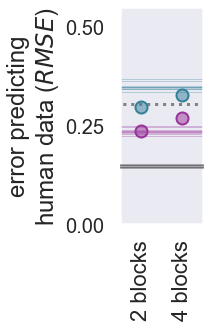

In [69]:
plt.figure(figsize=(1.5,4))
# plt.plot([0,3], [np.mean(resnet_instances_rmse_avg), np.mean(resnet_instances_rmse_avg)], '--', color=resnet_col, linewidth=1)
plt.plot([0,3], [np.mean(resnet00_rmse_avg), np.mean(resnet00_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,3], [np.mean(resnet01_rmse_avg), np.mean(resnet01_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,3], [np.mean(resnet02_rmse_avg), np.mean(resnet02_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,3], [np.mean(resnet03_rmse_avg), np.mean(resnet03_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,3], [np.mean(resnet04_rmse_avg), np.mean(resnet04_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,3], [np.mean(resnet05_rmse_avg), np.mean(resnet05_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,3], [np.mean(resnet06_rmse_avg), np.mean(resnet06_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,3], [np.mean(resnet07_rmse_avg), np.mean(resnet07_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,3], [np.mean(resnet08_rmse_avg), np.mean(resnet08_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,3], [np.mean(resnet09_rmse_avg), np.mean(resnet09_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)

# plt.plot([0,3], [np.mean(pixelVAE_instances_rmse_avg), np.mean(pixelVAE_instances_rmse_avg)], '--', color=pixelVAE_col, linewidth=1)
plt.plot([0,3], [np.mean(pixelVAE00_rmse_avg), np.mean(pixelVAE00_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,3], [np.mean(pixelVAE01_rmse_avg), np.mean(pixelVAE01_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,3], [np.mean(pixelVAE02_rmse_avg), np.mean(pixelVAE02_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,3], [np.mean(pixelVAE03_rmse_avg), np.mean(pixelVAE03_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,3], [np.mean(pixelVAE04_rmse_avg), np.mean(pixelVAE04_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,3], [np.mean(pixelVAE05_rmse_avg), np.mean(pixelVAE05_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,3], [np.mean(pixelVAE06_rmse_avg), np.mean(pixelVAE06_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,3], [np.mean(pixelVAE07_rmse_avg), np.mean(pixelVAE07_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,3], [np.mean(pixelVAE08_rmse_avg), np.mean(pixelVAE08_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,3], [np.mean(pixelVAE09_rmse_avg), np.mean(pixelVAE09_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)

# ground truth
plt.plot([0,3], [np.mean(groundtruth_rmse_avg),np.mean(groundtruth_rmse_avg)], ':', color=[0.5,0.5,0.5])

# noise ceilings
plt.fill_between([0,3], np.mean(lower_ceiling_rmse_avg), np.mean(upper_ceiling_rmse_avg), alpha=0.3, edgecolor='k', facecolor='k', zorder=20)

plt.errorbar(1, np.mean(res_f80l2_rmse_avg), marker='o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.errorbar(1, np.mean(pvae_f80l2_rmse_avg), marker='o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)

plt.errorbar(2, np.mean(res_f48l4_rmse_avg), marker='o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.errorbar(2, np.mean(pvae_f48l4_rmse_avg), marker='o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)


plt.xticks([1,2])
ax = plt.gca()
ax.set_xticklabels(['2 blocks','4 blocks'], rotation=90)
plt.xlim([0.5,2.5])
plt.ylim([0,0.55])
plt.yticks([0.0,0.25,0.5],fontsize=20)
# plt.legend(frameon=False, fontsize=11)
# plt.title('Effect of varying depth of network\n', fontsize=18)
plt.ylabel('error predicting\nhuman data ($RMSE$)', fontsize=24)
plt.show()


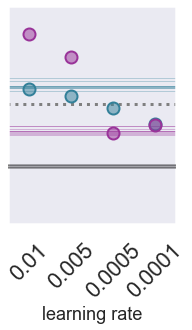

In [70]:
plt.figure(figsize=(3,4))
# plt.plot([0,5], [np.mean(resnet_instances_rmse_avg), np.mean(resnet_instances_rmse_avg)], '--', color=resnet_col, linewidth=1)
# plt.plot([0,5], [np.mean(pixelVAE_instances_rmse_avg), np.mean(pixelVAE_instances_rmse_avg)], '--', color=pixelVAE_col, linewidth=1)

plt.plot([0,5], [np.mean(resnet00_rmse_avg), np.mean(resnet00_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet01_rmse_avg), np.mean(resnet01_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet02_rmse_avg), np.mean(resnet02_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet03_rmse_avg), np.mean(resnet03_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet04_rmse_avg), np.mean(resnet04_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet05_rmse_avg), np.mean(resnet05_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet06_rmse_avg), np.mean(resnet06_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet07_rmse_avg), np.mean(resnet07_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet08_rmse_avg), np.mean(resnet08_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet09_rmse_avg), np.mean(resnet09_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)

plt.plot([0,5], [np.mean(pixelVAE00_rmse_avg), np.mean(pixelVAE00_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE01_rmse_avg), np.mean(pixelVAE01_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE02_rmse_avg), np.mean(pixelVAE02_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE03_rmse_avg), np.mean(pixelVAE03_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE04_rmse_avg), np.mean(pixelVAE04_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE05_rmse_avg), np.mean(pixelVAE05_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE06_rmse_avg), np.mean(pixelVAE06_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE07_rmse_avg), np.mean(pixelVAE07_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE08_rmse_avg), np.mean(pixelVAE08_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE09_rmse_avg), np.mean(pixelVAE09_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)

# ground truth
plt.plot([0,5], [np.mean(groundtruth_rmse_avg),np.mean(groundtruth_rmse_avg)], ':', color=[0.5,0.5,0.5])

# noise ceilings
plt.fill_between([0,5], np.mean(lower_ceiling_rmse_avg), np.mean(upper_ceiling_rmse_avg), alpha=0.3, edgecolor='k', facecolor='k', zorder=20)


plt.errorbar(1, np.mean(res_lr01_rmse_avg), marker='o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.errorbar(1, np.mean(pvae_lr01_rmse_avg), marker='o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)

plt.errorbar(2, np.mean(res_lr005_rmse_avg), marker='o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.errorbar(2, np.mean(pvae_lr005_rmse_avg), marker='o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)

plt.errorbar(3, np.mean(res_lr0005_rmse_avg), marker='o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.errorbar(3, np.mean(pvae_lr0005_rmse_avg), marker='o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)

plt.errorbar(4, np.mean(res_lr0001_rmse_avg), marker='o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.errorbar(4, np.mean(pvae_lr0001_rmse_avg), marker='o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)


plt.xticks([1,2,3,4])
ax = plt.gca()
ax.set_xticklabels(['0.01','0.005','0.0005','0.0001'], rotation=45)
plt.xlim([0.5,4.5])
plt.ylim([0,0.55])
plt.yticks([])
# plt.legend(frameon=False, fontsize=11)
# plt.title('Effect of varying learning rate', fontsize=18)
# plt.ylabel('error predicting human\ndata ($RMSE$)', fontsize=18)
plt.xlabel('learning rate', fontsize=18)
plt.show()

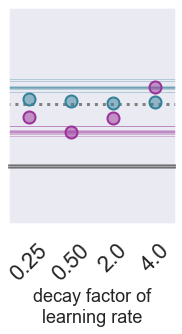

In [71]:
plt.figure(figsize=(3,4))
# plt.plot([0,5], [np.mean(resnet_instances_rmse_avg), np.mean(resnet_instances_rmse_avg)], '--', color=resnet_col, linewidth=1)
# plt.plot([0,5], [np.mean(pixelVAE_instances_rmse_avg), np.mean(pixelVAE_instances_rmse_avg)], '--', color=pixelVAE_col, linewidth=1)
plt.plot([0,5], [np.mean(resnet00_rmse_avg), np.mean(resnet00_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet01_rmse_avg), np.mean(resnet01_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet02_rmse_avg), np.mean(resnet02_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet03_rmse_avg), np.mean(resnet03_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet04_rmse_avg), np.mean(resnet04_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet05_rmse_avg), np.mean(resnet05_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet06_rmse_avg), np.mean(resnet06_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet07_rmse_avg), np.mean(resnet07_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet08_rmse_avg), np.mean(resnet08_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet09_rmse_avg), np.mean(resnet09_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)

plt.plot([0,5], [np.mean(pixelVAE00_rmse_avg), np.mean(pixelVAE00_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE01_rmse_avg), np.mean(pixelVAE01_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE02_rmse_avg), np.mean(pixelVAE02_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE03_rmse_avg), np.mean(pixelVAE03_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE04_rmse_avg), np.mean(pixelVAE04_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE05_rmse_avg), np.mean(pixelVAE05_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE06_rmse_avg), np.mean(pixelVAE06_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE07_rmse_avg), np.mean(pixelVAE07_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE08_rmse_avg), np.mean(pixelVAE08_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE09_rmse_avg), np.mean(pixelVAE09_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)

# ground truth
plt.plot([0,5], [np.mean(groundtruth_rmse_avg),np.mean(groundtruth_rmse_avg)], ':', color=[0.5,0.5,0.5])

# noise ceilings
plt.fill_between([0,5], np.mean(lower_ceiling_rmse_avg), np.mean(upper_ceiling_rmse_avg), alpha=0.3, edgecolor='k', facecolor='k', zorder=20)


plt.errorbar(1, np.mean(res_d0_25_rmse_avg), marker='o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.errorbar(1, np.mean(pvae_d0_25_rmse_avg), marker='o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)

plt.errorbar(2, np.mean(res_d0_50_rmse_avg), marker='o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.errorbar(2, np.mean(pvae_d0_50_rmse_avg), marker='o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)

plt.errorbar(3, np.mean(res_d2_00_rmse_avg), marker='o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.errorbar(3, np.mean(pvae_d2_00_rmse_avg), marker='o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)

plt.errorbar(4, np.mean(res_d4_00_rmse_avg), marker='o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)
plt.errorbar(4, np.mean(pvae_d4_00_rmse_avg), marker='o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)


plt.xticks([1,2,3,4])
ax = plt.gca()
ax.set_xticklabels(['0.25','0.50','2.0','4.0'], rotation=45)
plt.xlim([0.5,4.5])
plt.ylim([0,0.55])
plt.yticks([])
# plt.legend(frameon=False, fontsize=16, loc='upper right')
# plt.title('Effect of varying learning rate decay', fontsize=18)
# plt.ylabel('error predicting human\ndata ($RMSE$)', fontsize=18)
plt.xlabel('decay factor of\nlearning rate', fontsize=18)
plt.show()


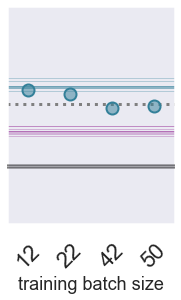

In [72]:
plt.figure(figsize=(3,4))
# plt.plot([0,5], [np.mean(resnet_instances_rmse_avg), np.mean(resnet_instances_rmse_avg)], '--', color=resnet_col, linewidth=1)
# plt.plot([0,5], [np.mean(pixelVAE_instances_rmse_avg), np.mean(pixelVAE_instances_rmse_avg)], '--', color=pixelVAE_col, linewidth=1)

plt.plot([0,5], [np.mean(resnet00_rmse_avg), np.mean(resnet00_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet01_rmse_avg), np.mean(resnet01_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet02_rmse_avg), np.mean(resnet02_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet03_rmse_avg), np.mean(resnet03_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet04_rmse_avg), np.mean(resnet04_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet05_rmse_avg), np.mean(resnet05_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet06_rmse_avg), np.mean(resnet06_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet07_rmse_avg), np.mean(resnet07_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet08_rmse_avg), np.mean(resnet08_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet09_rmse_avg), np.mean(resnet09_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)

plt.plot([0,5], [np.mean(pixelVAE00_rmse_avg), np.mean(pixelVAE00_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE01_rmse_avg), np.mean(pixelVAE01_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE02_rmse_avg), np.mean(pixelVAE02_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE03_rmse_avg), np.mean(pixelVAE03_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE04_rmse_avg), np.mean(pixelVAE04_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE05_rmse_avg), np.mean(pixelVAE05_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE06_rmse_avg), np.mean(pixelVAE06_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE07_rmse_avg), np.mean(pixelVAE07_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE08_rmse_avg), np.mean(pixelVAE08_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE09_rmse_avg), np.mean(pixelVAE09_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)

# ground truth
plt.plot([0,5], [np.mean(groundtruth_rmse_avg),np.mean(groundtruth_rmse_avg)], ':', color=[0.5,0.5,0.5])

# noise ceilings
plt.fill_between([0,5], np.mean(lower_ceiling_rmse_avg), np.mean(upper_ceiling_rmse_avg), alpha=0.3, edgecolor='k', facecolor='k', zorder=20)


plt.errorbar(1, np.mean(res_b12_rmse_avg), marker='o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)

plt.errorbar(2, np.mean(res_b22_rmse_avg), marker='o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)

plt.errorbar(3, np.mean(res_b42_rmse_avg), marker='o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)

plt.errorbar(4, np.mean(res_b50_rmse_avg), marker='o', markerfacecolor=resnet_col+[0.5], markeredgecolor=resnet_col, markersize=12, markeredgewidth=2)

plt.xticks([1,2,3,4])
ax = plt.gca()
ax.set_xticklabels(['12','22','42','50'], rotation=45)
plt.xlim([0.5,4.5])
plt.ylim([0,0.55])
plt.yticks([])
# plt.legend(frameon=False, fontsize=11, loc='lower right')
# plt.title('Effect of varying batch size \n in supervised Resnet models', fontsize=18)
# plt.ylabel('error predicting human\ndata ($RMSE$)', fontsize=18)
plt.xlabel('training batch size', fontsize=18)
plt.show()


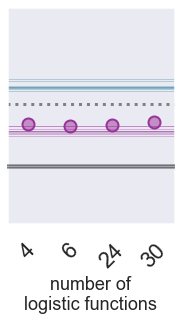

In [73]:
plt.figure(figsize=(3,4))
# plt.plot([0,5], [np.mean(resnet_instances_rmse_avg), np.mean(resnet_instances_rmse_avg)], '--', color=resnet_col, linewidth=1)
# plt.plot([0,5], [np.mean(pixelVAE_instances_rmse_avg), np.mean(pixelVAE_instances_rmse_avg)], '--', color=pixelVAE_col, linewidth=1)

plt.plot([0,5], [np.mean(resnet00_rmse_avg), np.mean(resnet00_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet01_rmse_avg), np.mean(resnet01_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet02_rmse_avg), np.mean(resnet02_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet03_rmse_avg), np.mean(resnet03_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet04_rmse_avg), np.mean(resnet04_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet05_rmse_avg), np.mean(resnet05_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet06_rmse_avg), np.mean(resnet06_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet07_rmse_avg), np.mean(resnet07_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet08_rmse_avg), np.mean(resnet08_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(resnet09_rmse_avg), np.mean(resnet09_rmse_avg)], '-', color=resnet_col, linewidth=1, alpha=0.3)

plt.plot([0,5], [np.mean(pixelVAE00_rmse_avg), np.mean(pixelVAE00_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE01_rmse_avg), np.mean(pixelVAE01_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE02_rmse_avg), np.mean(pixelVAE02_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE03_rmse_avg), np.mean(pixelVAE03_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE04_rmse_avg), np.mean(pixelVAE04_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE05_rmse_avg), np.mean(pixelVAE05_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE06_rmse_avg), np.mean(pixelVAE06_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE07_rmse_avg), np.mean(pixelVAE07_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE08_rmse_avg), np.mean(pixelVAE08_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)
plt.plot([0,5], [np.mean(pixelVAE09_rmse_avg), np.mean(pixelVAE09_rmse_avg)], '-', color=pixelVAE_col, linewidth=1, alpha=0.3)


# ground truth
plt.plot([0,5], [np.mean(groundtruth_rmse_avg),np.mean(groundtruth_rmse_avg)], ':', color=[0.5,0.5,0.5])

# noise ceilings
plt.fill_between([0,5], np.mean(lower_ceiling_rmse_avg), np.mean(upper_ceiling_rmse_avg), alpha=0.3, edgecolor='k', facecolor='k', zorder=20)


plt.errorbar(1, np.mean(pvae_log4_rmse_avg), marker='o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)

plt.errorbar(2, np.mean(pvae_log6_rmse_avg), marker='o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)

plt.errorbar(3, np.mean(pvae_log24_rmse_avg), marker='o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)

plt.errorbar(4, np.mean(pvae_log30_rmse_avg), marker='o', markerfacecolor=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markersize=12, markeredgewidth=2)

plt.xticks([1,2,3,4])
ax = plt.gca()
ax.set_xticklabels(['4','6','24','30'], rotation=45)
plt.xlim([0.5,4.5])
plt.ylim([0,0.55])
plt.yticks([])
# plt.legend(frameon=False, fontsize=11, loc='lower right')
# plt.title('Effect of varying complexity of PixelVAE model \n', fontsize=18)
# plt.ylabel('error predicting human\ndata ($RMSE$)', fontsize=18)
plt.xlabel('number of\nlogistic functions', fontsize=18)
plt.show()


In [453]:
# classification accuracy of a binary gloss SVM trained on latent features

# TODO: move these values out to somewhere else...
pvae_f80l2_acc = 99.4
pvae_f48l4_acc = 95.8
pvae_lr01_acc = 54.8
pvae_lr005_acc = 57.7
pvae_lr0005_acc = 99.4
pvae_lr0001_acc = 96.6
pvae_d0_25_acc = 99.0
pvae_d0_50_acc = 99.4
pvae_d2_00_acc = 95.2
pvae_d4_00_acc = 90.3
pvae_log4_acc = 98.8
pvae_log6_acc = 99.2
pvae_log24_acc = 98.9
pvae_log30_acc = 99.2

pixelVAE00_acc = 99.6
pixelVAE01_acc = 99.7
pixelVAE02_acc = 99.4
pixelVAE03_acc = 99.8
pixelVAE04_acc = 99.5
pixelVAE05_acc = 98.4
pixelVAE06_acc = 99.5
pixelVAE07_acc = 99.6
pixelVAE08_acc = 99.6
pixelVAE09_acc = 98.9

res_f80l2_acc = 99.7
res_f48l4_acc = 98.6
res_lr01_acc = 99.3
res_lr005_acc = 99.2
res_lr0005_acc = 96.9
res_lr0001_acc = 90.1
res_d0_25_acc = 97.7
res_d0_50_acc = 97.8
res_d2_00_acc = 97.3
res_d4_00_acc = 97.6
res_b12_acc = 99.4
res_b22_acc = 98.8
res_b42_acc = 97.2
res_b50_acc = 97.3

resnet00_acc = 99.1
resnet01_acc = 99.4
resnet02_acc = 99.7
resnet03_acc = 99.6
resnet04_acc = 99.5
resnet05_acc = 99.2
resnet06_acc = 99.4
resnet07_acc = 99.4
resnet08_acc = 99.0
resnet09_acc = 99.3

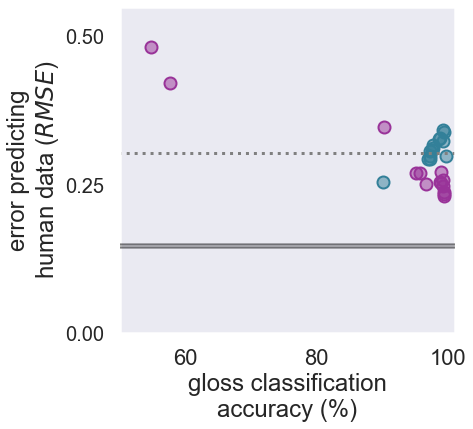

In [454]:
plt.figure(figsize=(6,6))
plt.plot(res_f80l2_acc, np.mean(res_f80l2_rmse_avg), 'o', markersize=12, color=resnet_col+[0.5], label='supervised', markeredgecolor=resnet_col, markeredgewidth=2)
plt.plot(res_f48l4_acc, np.mean(res_f48l4_rmse_avg), 'o', markersize=12, color=resnet_col+[0.5], markeredgecolor=resnet_col, markeredgewidth=2)
plt.plot(res_lr01_acc, np.mean(res_lr01_rmse_avg), 'o', markersize=12, color=resnet_col+[0.5], markeredgecolor=resnet_col, markeredgewidth=2)
plt.plot(res_lr005_acc, np.mean(res_lr005_rmse_avg), 'o', markersize=12, color=resnet_col+[0.5], markeredgecolor=resnet_col, markeredgewidth=2)
plt.plot(res_lr0005_acc, np.mean(res_lr0005_rmse_avg), 'o', markersize=12, color=resnet_col+[0.5], markeredgecolor=resnet_col, markeredgewidth=2)
plt.plot(res_lr0001_acc, np.mean(res_lr0001_rmse_avg), 'o', markersize=12, color=resnet_col+[0.5], markeredgecolor=resnet_col, markeredgewidth=2)
plt.plot(res_d0_25_acc, np.mean(res_d0_25_rmse_avg), 'o', markersize=12, color=resnet_col+[0.5], markeredgecolor=resnet_col, markeredgewidth=2)
plt.plot(res_d0_50_acc, np.mean(res_d0_50_rmse_avg), 'o', markersize=12, color=resnet_col+[0.5], markeredgecolor=resnet_col, markeredgewidth=2)
plt.plot(res_d2_00_acc, np.mean(res_d2_00_rmse_avg), 'o', markersize=12, color=resnet_col+[0.5], markeredgecolor=resnet_col, markeredgewidth=2)
plt.plot(res_d4_00_acc, np.mean(res_d4_00_rmse_avg), 'o', markersize=12, color=resnet_col+[0.5], markeredgecolor=resnet_col, markeredgewidth=2)
plt.plot(res_b12_acc, np.mean(res_b12_rmse_avg), 'o', markersize=12, color=resnet_col+[0.5], markeredgecolor=resnet_col, markeredgewidth=2)
plt.plot(res_b22_acc, np.mean(res_b22_rmse_avg), 'o', markersize=12, color=resnet_col+[0.5], markeredgecolor=resnet_col, markeredgewidth=2)
plt.plot(res_b42_acc, np.mean(res_b42_rmse_avg), 'o', markersize=12, color=resnet_col+[0.5], markeredgecolor=resnet_col, markeredgewidth=2)
plt.plot(res_b50_acc, np.mean(res_b50_rmse_avg), 'o', markersize=12, color=resnet_col+[0.5], markeredgecolor=resnet_col, markeredgewidth=2)

# # show original resnets for reference
# plt.plot(resnet00_acc, np.mean(resnet00_rmse_avg), 'o', markersize=8, color=resnet_col, markeredgecolor='k', markeredgewidth=2)
# plt.plot(resnet01_acc, np.mean(resnet01_rmse_avg), 'o', markersize=8, color=resnet_col, markeredgecolor='k', markeredgewidth=2)
# plt.plot(resnet02_acc, np.mean(resnet02_rmse_avg), 'o', markersize=8, color=resnet_col, markeredgecolor='k', markeredgewidth=2)
# plt.plot(resnet03_acc, np.mean(resnet03_rmse_avg), 'o', markersize=8, color=resnet_col, markeredgecolor='k', markeredgewidth=2)
# plt.plot(resnet04_acc, np.mean(resnet04_rmse_avg), 'o', markersize=8, color=resnet_col, markeredgecolor='k', markeredgewidth=2)
# plt.plot(resnet05_acc, np.mean(resnet05_rmse_avg), 'o', markersize=8, color=resnet_col, markeredgecolor='k', markeredgewidth=2)
# plt.plot(resnet06_acc, np.mean(resnet06_rmse_avg), 'o', markersize=8, color=resnet_col, markeredgecolor='k', markeredgewidth=2)
# plt.plot(resnet07_acc, np.mean(resnet07_rmse_avg), 'o', markersize=8, color=resnet_col, markeredgecolor='k', markeredgewidth=2)
# plt.plot(resnet08_acc, np.mean(resnet08_rmse_avg), 'o', markersize=8, color=resnet_col, markeredgecolor='k', markeredgewidth=2)
# plt.plot(resnet09_acc, np.mean(resnet09_rmse_avg), 'o', markersize=8, color=resnet_col, markeredgecolor='k', markeredgewidth=2)

plt.plot(pvae_f80l2_acc, np.mean(pvae_f80l2_rmse_avg), 'o', markersize=12, color=pixelVAE_col+[0.5], label='unsupervised', markeredgecolor=pixelVAE_col, markeredgewidth=2)
plt.plot(pvae_f48l4_acc, np.mean(pvae_f48l4_rmse_avg), 'o', markersize=12, color=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markeredgewidth=2)
plt.plot(pvae_lr01_acc, np.mean(pvae_lr01_rmse_avg), 'o', markersize=12, color=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markeredgewidth=2)
plt.plot(pvae_lr005_acc, np.mean(pvae_lr005_rmse_avg), 'o', markersize=12, color=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markeredgewidth=2)
plt.plot(pvae_lr0005_acc, np.mean(pvae_lr0005_rmse_avg), 'o', markersize=12, color=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markeredgewidth=2)
plt.plot(pvae_lr0001_acc, np.mean(pvae_lr0001_rmse_avg), 'o', markersize=12, color=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markeredgewidth=2)
plt.plot(pvae_d0_25_acc, np.mean(pvae_d0_25_rmse_avg), 'o', markersize=12, color=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markeredgewidth=2)
plt.plot(pvae_d0_50_acc, np.mean(pvae_d0_50_rmse_avg), 'o', markersize=12, color=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markeredgewidth=2)
plt.plot(pvae_d2_00_acc, np.mean(pvae_d2_00_rmse_avg), 'o', markersize=12, color=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markeredgewidth=2)
plt.plot(pvae_d4_00_acc, np.mean(pvae_d4_00_rmse_avg), 'o', markersize=12, color=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markeredgewidth=2)
plt.plot(pvae_log4_acc, np.mean(pvae_log4_rmse_avg), 'o', markersize=12, color=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markeredgewidth=2)
plt.plot(pvae_log6_acc, np.mean(pvae_log6_rmse_avg), 'o', markersize=12, color=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markeredgewidth=2)
plt.plot(pvae_log24_acc, np.mean(pvae_log24_rmse_avg), 'o', markersize=12, color=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markeredgewidth=2)
plt.plot(pvae_log30_acc, np.mean(pvae_log30_rmse_avg), 'o', markersize=12, color=pixelVAE_col+[0.5], markeredgecolor=pixelVAE_col, markeredgewidth=2)

# # show original pixelvaes for reference
# plt.plot(pixelVAE00_acc, np.mean(pixelVAE00_rmse_avg), 'o', markersize=8, color=pixelVAE_col, markeredgecolor='k', markeredgewidth=2)
# plt.plot(pixelVAE01_acc, np.mean(pixelVAE01_rmse_avg), 'o', markersize=8, color=pixelVAE_col, markeredgecolor='k', markeredgewidth=2)
# plt.plot(pixelVAE02_acc, np.mean(pixelVAE02_rmse_avg), 'o', markersize=8, color=pixelVAE_col, markeredgecolor='k', markeredgewidth=2)
# plt.plot(pixelVAE03_acc, np.mean(pixelVAE03_rmse_avg), 'o', markersize=8, color=pixelVAE_col, markeredgecolor='k', markeredgewidth=2)
# plt.plot(pixelVAE04_acc, np.mean(pixelVAE04_rmse_avg), 'o', markersize=8, color=pixelVAE_col, markeredgecolor='k', markeredgewidth=2)
# plt.plot(pixelVAE05_acc, np.mean(pixelVAE05_rmse_avg), 'o', markersize=8, color=pixelVAE_col, markeredgecolor='k', markeredgewidth=2)
# plt.plot(pixelVAE06_acc, np.mean(pixelVAE06_rmse_avg), 'o', markersize=8, color=pixelVAE_col, markeredgecolor='k', markeredgewidth=2)
# plt.plot(pixelVAE07_acc, np.mean(pixelVAE07_rmse_avg), 'o', markersize=8, color=pixelVAE_col, markeredgecolor='k', markeredgewidth=2)
# plt.plot(pixelVAE08_acc, np.mean(pixelVAE08_rmse_avg), 'o', markersize=8, color=pixelVAE_col, markeredgecolor='k', markeredgewidth=2)
# plt.plot(pixelVAE09_acc, np.mean(pixelVAE09_rmse_avg), 'o', markersize=8, color=pixelVAE_col, markeredgecolor='k', markeredgewidth=2)

# ground truth
plt.plot([0,102], [np.mean(groundtruth_rmse_avg),np.mean(groundtruth_rmse_avg)], ':', color=[0.5,0.5,0.5])

# noise ceilings
plt.fill_between([0,102], np.mean(lower_ceiling_rmse_avg), np.mean(upper_ceiling_rmse_avg), alpha=0.3, edgecolor='k', facecolor='k', zorder=20)


plt.ylabel('error predicting\nhuman data ($RMSE$)', fontsize=24)
plt.xlabel('gloss classification\naccuracy (%)', fontsize=24)
plt.yticks([0.0,0.25,0.5],fontsize=20)

# zoomed out
plt.ylim([0.0,0.55])
plt.xlim([50,101])

# inset
# plt.ylim([0.20,0.42])
# plt.xlim([89,100.5])

plt.show()

In [458]:
all_pvae = [pvae_f80l2_rmse_avg, pvae_f48l4_rmse_avg, pvae_lr01_rmse_avg, pvae_lr005_rmse_avg, pvae_lr0005_rmse_avg, pvae_lr0001_rmse_avg, pvae_d0_25_rmse_avg, pvae_d0_50_rmse_avg, pvae_d2_00_rmse_avg, pvae_d4_00_rmse_avg, pvae_log4_rmse_avg, pvae_log6_rmse_avg, pvae_log24_rmse_avg, pvae_log30_rmse_avg]

all_res = [res_f80l2_rmse_avg, res_f48l4_rmse_avg, res_lr01_rmse_avg, res_lr005_rmse_avg, res_lr0005_rmse_avg, res_lr0001_rmse_avg, res_d0_25_rmse_avg, res_d0_50_rmse_avg, res_d2_00_rmse_avg, res_d4_00_rmse_avg, res_b12_rmse_avg, res_b22_rmse_avg, res_b42_rmse_avg, res_b50_rmse_avg]

In [464]:
ttest_ind(all_pvae, all_res)

Ttest_indResult(statistic=-1.065115099249366, pvalue=0.29661574254471046)